<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/Marine/Marine_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "MHGNONOK"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-06 00:23:26,051 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-06 00:23:26,052 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for MHGNONOK
2019-09-06 00:23:35,465 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-06 00:27:07,952 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-06 00:34:28,111 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-06 00:37:35,852 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-06 00:40:36,114 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-06 00:43:42,741 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-06 00:46:42,337 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-06 00:49:48,404 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.39198  1.39397  1.37347  1.38347  3.283744
2018-01-02 09:00:00  1.38348  1.38948  1.37897  1.37998  2.885913
2018-01-02 10:00:00  1.38047  1.38798  1.37865  1.38248  2.275778
2018-01-02 11:00:00  1.38247  1.38398  1.37748  1.38048  1.588163
2018-01-02 12:00:00  1.38048  1.38287  1.37597  1.37897  2.017779
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  1.83098  1.83948  1.82887  1.83338  3.680000
2018-12-28 12:00:00  1.83247  1.84047  1.83038  1.84037  3.190000
2018-12-28 13:00:00  1.84098  1.84148  1.82737  1.83197  2.980000
2018-12-28 14:00:00  1.83247  1.83398  1.82487  1.82788  3.310000
2018-12-28 15:00:00  1.82837  1.82888  1.82098  1.82647  1.930000

[1983 rows x 5 columns]

Open         High          Low        Close       Volume
count  1983.000000  1983.000000  1983.000000  1983.000000  1983.000000
mean      1.718217     1.724238     1.712431     1.718595     4.110450
std       0.194790     0.195214     0.194133     0.194617     2.213452
min       1.293480     1.302480     1.291880     1.299980     0.440000
25%       1.597425     1.603475     1.591375     1.600175     2.432579
50%       1.721470     1.728470     1.715870     1.721170     3.750000
75%       1.870670     1.875725     1.864425     1.870970     5.320000
max       2.072980     2.073980     2.067870     2.073970    16.660000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 10:00:00  1.39948  1.39948  1.38997  1.39198  2.112016   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  1.387520  1.378716  1.371985  1.392040  1.388767  1.389640    1.388225    1.391475  1.376317  1.385654  1.395518  1.385064  1.389359  1.385654  1.396477  1.385699                1.403153                 1.385654                1.368155                1.411902                 1.385654                1.359405                1.420652                 1.385654                1.350655                1.429402                 1.385654                1.341906  1.388767  1.393104  1.385186                1.406267                 1.388767                1.371268                1.415016                 1.388767                1.362519                1.423766                 1.388767                1.353769                1.432515                 1.388767                1.345020   
2018-01-10 11:00:00  1.39197  1.40048  1.39197  1.39598  1.700630   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  1.387943  1.378946  1.372715  1.394162  1.390370  1.390459    1.388225    1.391475  1.378890  1.388029  1.397271  1.388569  1.391653  1.388029  1.393980  1.385894                1.405331                 1.388029                1.370727                1.413982                 1.388029                1.362076                1.422633                 1.388029                1.353425                1.431283                 1.388029                1.344774  1.390370  1.395205  1.385553                1.407672                 1.390370                1.373068                1.416323                 1.390370                1.364417                1.424974                 1.390370                1.355766                1.433625                 1.390370                1.347116   
2018-01-10 12:00:00  1.3

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000    1933.000000  1933.000000   1933.000000     1933.000000       1933.000000  1933.000000  1933.000000  1933.000000  1933.000000   1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000  1933.000000             1933.000000              1933.000000             1933.000000             1933.000000              1933.000000             1933.000000             1933.000000              1933.000000             1933.000000             1933.000000              1933.000000             1933.000000  1933.000000  1933.000000  1933.000000             1933.000000              1933.000000             1933.000000             1933.000000              1933.000000             1933.000000             1933.000000   
mean      1.726915     1.732968     1.721123     1.727319     4.159643    15.896017     2.024832   186.433523      30.409208    10.879462      0.032592        0.024315          0.004139     6.633213     2.548370    27.201242     2.024832      1.994827    27.201242     1.726335     1.724407     0.127917     1.727342     1.726510     1.726501     1.726632     1.726087     1.724191     1.726517     1.727322     1.726520     1.726788     1.726517     1.727150     1.724825                1.744039                 1.726517                1.708995                1.752800                 1.726517                1.700234                1.761561                 1.726517                1.691473                1.770322                 1.726517                1.682713     1.726510     1.727155     1.725086                1.744032                 1.726510                1.708988                1.752793                 1.726510                1.700227                1.761553   
std       0.189521     0.189906     0.188838     0.189289     2.216203     8.574847     1.413629   101.626184       0.859521     2.337572      0.177612        0.154064          0.064216     3.345600     1.101647    14.516263     1.413629      1.406865    14.516263     0.189335     0.190020     1.731183     0.189410     0.189381     0.189287     0.189426     0.189487     0.190278     0.189517     0.189345     0.189573     0.189390     0.189517     0.189301     0.189984                0.191675                 0.189517                0.187863                0.192938                 0.189517                0.187229                0.194321                 0.189517                0.186726                0.195820                 0.189517                0.186355     0.189381     0.189287     0.189921                0.191541                 0.189381                0.187726                0.192804                 0.189381                0.187093                0.194188   
min       1.293480     1.302480     1.291880     1.299980     0.440000     1.000000     0.000000    10.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 10:00:00  0.135985  0.125729  0.126406  0.118865  0.103084   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  0.108442  0.082512  0.839714  0.122961  0.108626  0.108444    0.112399    0.113850  0.107962  0.108374  0.124941  0.106571  0.113554  0.108374  0.123948  0.094679                0.120196                 0.108374                0.101770                0.125051                 0.108374                0.102772                0.129679                 0.108374                0.109937                0.134097                 0.108374                0.122198  0.108626  0.119807  0.095417                0.120615                 0.108626                0.103949                0.126142                 0.108626                0.109021                0.131463                 0.108626                0.121496                0.136080                 0.108626   
2018-01-10 11:00:00  0.126350  0.127025  0.128984  0.124033  0.077721   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.109005  0.082831  0.839892  0.125714  0.110759  0.109545    0.112399    0.113850  0.111252  0.111515  0.127206  0.111186  0.116572  0.111515  0.120708  0.094947                0.122970                 0.111515                0.105220                0.127636                 0.111515                0.106360                0.132085                 0.111515                0.113591                0.136330                 0.111515                0.125893  0.110759  0.122536  0.095920                0.122418                 0.110759                0.106373                0.127787                 0.110759                0.111566                0.132955                 0.110759                0.124110                0.137420                 0.110759   
2018-01-10 12:00:00  0.131482  0.122489  0.125118  0.118852  0.060731   10          2         10         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyxmczk2r
  JVM stdout: /tmp/tmpyxmczk2r/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyxmczk2r/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_mx5bn3
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.500000  0.693611              0.500000  0.500232  0.250232
1  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.500000  0.691969              0.500000  0.499410  0.249411
2  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.500000  0.693348              0.500000  0.500100  0.250100
3  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.500000  0.697272              0.500000  0.502056  0.252060
4  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.471974  0.861061              0.495098  0.559990  0.313589
5  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.469416  0.971562              0.495098  0.584604  0.341762
6  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.467285  0.697753              0.490196  0.502294  0.252300
7  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.458227  2.396166              0.450980  0.685132  0.469405
8              DeepLearning_1_AutoML_20190906_010929  0.454817  4.276669              0.476023  0.687757  0.473010
9  DeepLearning_grid_1_AutoML_20190906_010929_mod...  0.450128  0.988183              0.500000  0.594188  0.353059

variable  relative_importance  scaled_importance  percentage
0                 HT_TRENDMODE             1.000000           1.000000    0.001490
1                 weekday_name             0.985596           0.985596    0.001468
2               STOCHRSI_fastk             0.967187           0.967187    0.001441
3         HT_PHASOR_quadrature             0.952293           0.952293    0.001419
4                          SUB             0.933937           0.933937    0.001391
...                        ...                  ...                ...         ...
1027   BBANDS_lowerband_30_2_2             0.573033           0.573033    0.000854
1028  BBANDS_middleband_20_0_3             0.572963           0.572963    0.000854
1029                       TAN             0.568423           0.568423    0.000847
1030   BBANDS_lowerband_30_0_3             0.568340           0.568340    0.000847
1031               CDLMARUBOZU             0.566221           0.566221    0.000844

[1032 rows x 4 columns]

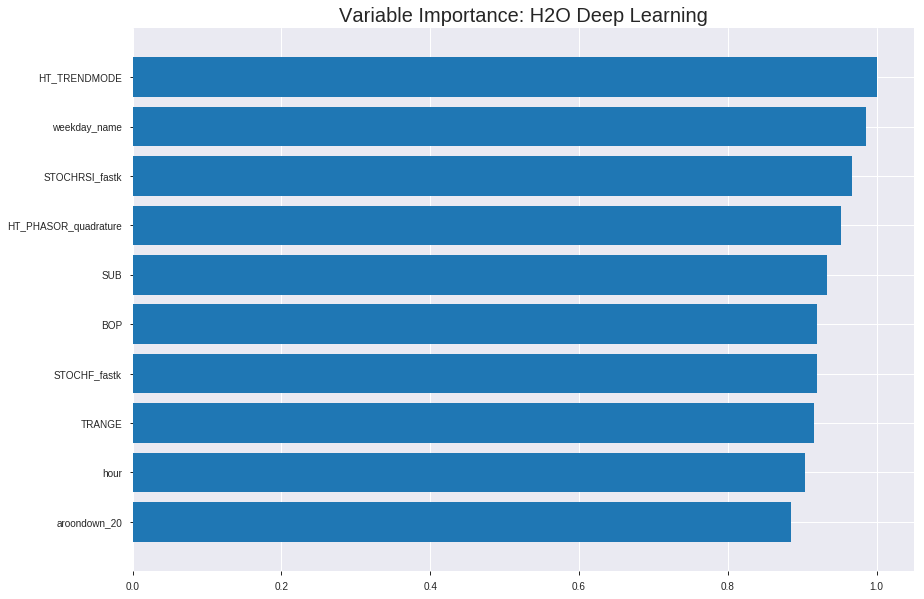

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_010929_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24134845477825942
RMSE: 0.4912722817117402
LogLoss: 0.673516469736218
Mean Per-Class Error: 0.4506194318428015
AUC: 0.5701869565883432
pr_auc: 0.5984929649414462
Gini: 0.14037391317668635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4175512626851717: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      34   637   0.9493   (637.0/671.0)
1      4    677   0.0059   (4.0/681.0)
Total  38   1314  0.4741   (641.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417551     0.678697  364
max f2                       0.353361     0.839911  378
max f0point5                 0.417551     0.570153  364
max accuracy                 0.507511     0.547337  165
max precision                0.972286     1         0
max recall                   0.353361     1         378
max specificity              0.972286     1         0
max absolute_mcc             0.53496      0.158201  101
max min_per_class_accuracy   0.504167     0.494784  176
max mean_per_class_accuracy  0.507511     0.549381  165

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 49.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.880091           1.84351   1.84351            0.928571         0.925795  0.928571                    0.925795            0.0190896       0.0190896                  84.3507     84.3507
    2        0.0207101                   0.743638           1.84351   1.84351            0.928571         0.808289  0.928571                    0.867042            0.0190896       0.0381791                  84.3507     84.3507
    3        0.0303254                   0.663655           1.67988   1.79163            0.846154         0.694789  0.902439                    0.812425            0.0161527       0.0543319                  67.9883     79.1626
    4        0.0406805                   0.626232           1.41808   1.69654            0.714286         0.643394  0.854545                    0.769399            0.0146843       0.0690162                  41.8083     69.6543
    5        0.0502959                   0.589832           0.763583  1.51818            0.384615         0.603555  0.764706                    0.737694            0.00734214      0.0763583                  -23.6417    51.8183
    6        0.100592                    0.529105           1.22622   1.3722             0.617647         0.54873   0.691176                    0.643212            0.061674        0.138032                   22.6224     37.2204
    7        0.150148                    0.517088           1.09637   1.28116            0.552239         0.521882  0.64532                     0.603167            0.0543319       0.192364                   9.63684     28.1164
    8        0.200444                    0.509565           0.992658  1.20877            0.5              0.513371  0.608856                    0.580635            0.0499266       0.242291                   -0.734214   20.8772
    9        0.546598                    0.504167           0.9969    1.0746             0.502137         0.504567  0.541272                    0.532462            0.345081        0.587372                   -0.310002   7.45958
    10       0.599852                    0.501751           0.827215  1.05263            0.416667         0.502992  0.53021                     0.529846            0.0440529       0.631424                   -17.2785    5.26335
    11       0.699704                    0.477517           1.00001   1.04512            0.503704         0.487187  0.526427                    0.523758            0.0998532       0.731278                   0.00108773  4.51239
    12       0.799556                    0.466618           0.985305  1.03765            0.496296         0.472639  0.522664                    0.517374            0.0983847       0.829662                   -1.46952    3.76534
    13       0.899408                    0.429656           0.911775  1.02368            0.459259         0.445069  0.515625                    0.509347            0.0910426       0.920705                   -8.82254    2.36784
    14       1                           0.035389           0.788287  1                  0.397059         0.39006   0.503698                    0.497347            0.0792952       1                          -21.1713    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24986624091563758
RMSE: 0.499866223019357
LogLoss: 0.692879656600535
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5041665796919245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    186  1        (186.0/186.0)
1      0    200  0        (0.0/200.0)
Total  0    386  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504167     0.682594  0
max f2                       0.504167     0.84317   0
max f0point5                 0.504167     0.573394  0
max accuracy                 0.504167     0.518135  0
max precision                0.504167     0.518135  0
max recall                   0.504167     1         0
max specificity              0.504167     0         0
max absolute_mcc             0.504167     0         0
max min_per_class_accuracy   0.504167     0         0
max mean_per_class_accuracy  0.504167     0.5       0

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 50.42 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.504167           1       1                  0.518135         0.504167  0.518135                    0.504167            1               1                          0       0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:23:04  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:23:06  8 min 19.543 sec   333 obs/sec       0.464497  1             628        0.673238         3.46938             -0.813098      0.510708        0.472235           0.85085          0.496302                         0.719816           10.9645               -1.07527         0.570376          0.561974             0                  0.468912
    2019-09-06 01:23:30  8 min 43.005 sec   441 obs/sec       7.54438   16            10200      0.505523         0.704902            -0.0222716     0.541879        0.562048           1.7017           0.496302                         0.555408           0.824674              -0.235535        0.555108          0.538305             0.965              0.448187
    2019-09-06 01:23:53  9 min  6.303 sec   461 obs/sec       15.0577   32            20358      0.498034         0.688978            0.00779588     0.553164        0.570101           1.7017           0.483728                         0.513487           0.721096              -0.0560631       0.519731          0.5505               1.4475             0.46114
    2019-09-06 01:24:17  9 min 29.957 sec   487 obs/sec       23.5939   50            31899      0.493266         0.678728            0.0267031      0.56352         0.585552           1.98532          0.473373                         0.501447           0.696051              -0.00712321      0.52129           0.550367             1.93               0.476684
    2019-09-06 01:24:40  9 min 53.102 sec   517 obs/sec       33.0414   70            44672      0.491272         0.673516            0.0345534      0.570187        0.598493           1.84351          0.474112                         0.499866           0.69288               -0.000781463     0.5               0                    1                  0.481865
    2019-09-06 01:25:03  10 min 16.076 sec  542 obs/sec       42.8839   91            57979      0.491626         0.673241            0.0331639      0.565913        0.616161           1.98532          0.465976                         0.500029           0.693207              -0.00143255      0.5               0                    1                  0.481865
    2019-09-06 01:25:26  10 min 39.542 sec  574 obs/sec       54.3743   115           73514      0.484253         0.656954            0.0619443      0.599883        0.655796           1.98532          0.448964                         0.500294           0.693736              -0.00249647      0.5               0                    1                  0.481865
    2019-09-06 01:25:50  11 min  3.558 sec  601 obs/sec       66.5806   141           90017      0.479086         0.644659            0.0818556      0.613499        0.677233           1.98532          0.449704                         0.500412           0.693971              -0.00296696      0.5               0                    1                  0.481865
    2019-09-0

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE              1.0                    1.0                  0.0014899000479226658
weekday_name              0.985596239566803      0.985596239566803    0.001468439884562979
STOCHRSI_fastk            0.9671869277954102     0.9671869277954102   0.0014410118500725576
HT_PHASOR_quadrature      0.952293336391449      0.952293336391449    0.0014188218875260553
SUB                       0.9339373707771301     0.9339373707771301   0.0013914733334776147
---                       ---                    ---                  ---
BBANDS_lowerband_30_2_2   0.5730326175689697     0.5730326175689697   0.0008537613243772586
BBANDS_middleband_20_0_3  0.5729629993438721     0.5729629993438721   0.0008536576001803494
TAN                       0.5684226155281067     0.5684226155281067   0.0008468928821156532
BBANDS_lowerband_30_0_3   0.5683404803276062     0.5683404803276062   0.0008467705088764915
CDLMARUBOZU               0.5662212371826172     0.5662212371826172   0.0008436130484132126


See the whole table with table.as_data_frame()


('accuracy', 0.4742268041237113)

('F1', 0.6433566433566433)

('auc', 0.5)

('logloss', 0.6936114567794808)

('mean_per_class_error', 0.5)

('rmse', 0.5002320786748858)

('mse', 0.2502321325353972)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


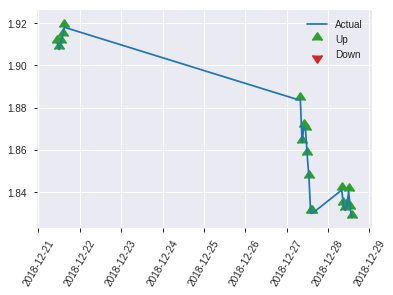


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2502321325353972
RMSE: 0.5002320786748858
LogLoss: 0.6936114567794808
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5041665796919245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504167     0.643357  0
max f2                       0.504167     0.818505  0
max f0point5                 0.504167     0.529954  0
max accuracy                 0.504167     0.474227  0
max precision                0.504167     0.474227  0
max recall                   0.504167     1         0
max specificity              0.504167     0         0
max absolute_mcc             0.504167     0         0
max min_per_class_accuracy   0.504167     0         0
max mean_per_class_accuracy  0.504167     0.5       0

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 50.42 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.504167           1       1                  0.474227         0.504167  0.474227                    0.504167            1               1                          0       0

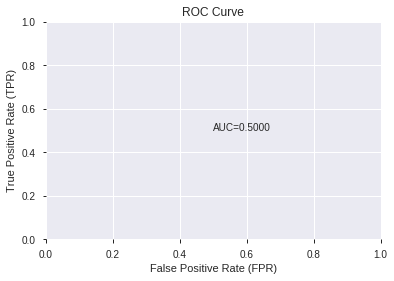

This function is available for GLM models only


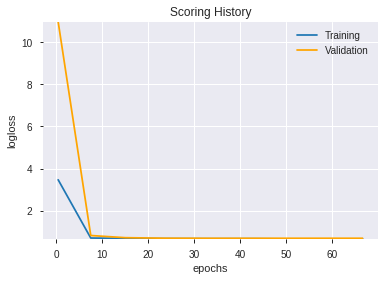

--2019-09-06 01:38:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  12.9MB/s    in 25s     

2019-09-06 01:39:25 (13.9 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_010929_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_010929_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190906_013936  0.525682  0.906035              0.495098  0.561985  0.315827
1  DeepLearning_grid_1_AutoML_20190906_013936_model_7  0.510656  0.861344              0.500000  0.563068  0.317046
2  DeepLearning_grid_1_AutoML_20190906_013936_model_2  0.506714  0.923267              0.495098  0.565779  0.320106
3  DeepLearning_grid_1_AutoML_20190906_013936_model_4  0.503730  0.993090              0.490196  0.584658  0.341825
4  DeepLearning_grid_1_AutoML_20190906_013936_model_3  0.497656  0.915416              0.500000  0.563505  0.317538
5  DeepLearning_grid_1_AutoML_20190906_013936_model_5  0.492221  0.750842              0.495098  0.519775  0.270166
6  DeepLearning_grid_1_AutoML_20190906_013936_model_6  0.491688  0.724548              0.495098  0.512344  0.262496
7  DeepLearning_grid_1_AutoML_20190906_013936_model_8  0.486200  0.693621              0.495098  0.500222  0.250222
8  DeepLearning_grid_1_AutoML_20190906_013936_model_9  0.474105  0.692031              0.500000  0.499442  0.249442
9  DeepLearning_grid_1_AutoML_20190906_013936_model_1  0.468990  1.188727              0.500000  0.613989  0.376982

variable  relative_importance  scaled_importance  percentage
0           HT_TRENDMODE             1.000000           1.000000    0.028447
1           aroondown_14             0.947603           0.947603    0.026956
2              CORREL_14             0.935599           0.935599    0.026615
3              CORREL_20             0.905748           0.905748    0.025765
4           MACDEXT_hist             0.884334           0.884334    0.025156
5                    BOP             0.869665           0.869665    0.024739
6              dayofweek             0.865659           0.865659    0.024625
7                    DIV             0.848336           0.848336    0.024132
8           aroondown_12             0.843654           0.843654    0.023999
9                 SAREXT             0.821586           0.821586    0.023371
10             CORREL_24             0.818074           0.818074    0.023271
11              WILLR_12             0.812325           0.812325    0.023108
12                TRANGE             0.794051           0.794051    0.022588
13                   SIN             0.792263           0.792263    0.022537
14                 DX_20             0.791002           0.791002    0.022501
15            aroonup_12             0.782594           0.782594    0.022262
16                   SUB             0.770410           0.770410    0.021916
17                 DX_14             0.764192           0.764192    0.021739
18            aroonup_14             0.761937           0.761937    0.021674
19                Volume             0.746662           0.746662    0.021240
20               NATR_30             0.744500           0.744500    0.021178
21          aroondown_24             0.744013           0.744013    0.021165
22          aroondown_20             0.730454           0.730454    0.020779
23           MINUS_DM_30             0.719359           0.719359    0.020463
24             CORREL_30             0.707802           0.707802    0.020135
25         days_in_month             0.705211           0.705211    0.020061
26               BETA_24             0.700313           0.700313    0.019921
27                 DX_12             0.685668           0.685668    0.019505
28                  hour             0.680214           0.680214    0.019350
29          STOCHF_fastd             0.675508           0.675508    0.019216
30                 CCI_8             0.672521           0.672521    0.019131
31          weekday_name             0.661021           0.661021    0.018804
32                MFI_12             0.642624           0.642624    0.018280
33                 DX_30             0.631459           0.631459    0.017963
34               weekday             0.626035           0.626035    0.017809
35               BETA_14             0.622985           0.622985    0.017722
36        STOCHRSI_fastd             0.615013           0.615013    0.017495
37           AROONOSC_14             0.611290           0.611290    0.017389
38             CORREL_12             0.599233           0.599233    0.017046
39               BETA_20             0.577816           0.577816    0.016437
40           HT_DCPERIOD             0.559449           0.559449    0.015914
41           aroondown_8             0.558881           0.558881    0.015898
42                MFI_14             0.548383           0.548383    0.015600
43     CDLLONGLEGGEDDOJI             0.533744           0.533744    0.015183
44  HT_PHASOR_quadrature             0.524351           0.524351    0.014916
45               WILLR_8             0.520041           0.520041    0.014793
46        STOCHRSI_fastk             0.512261           0.512261    0.014572
47           AROONOSC_12             0.512232           0.512232    0.014571
48          STOCHF_fastk             0.427668           0.427668    0.012166
49           AROONOSC_24             0.347910           0.347910    0.009897

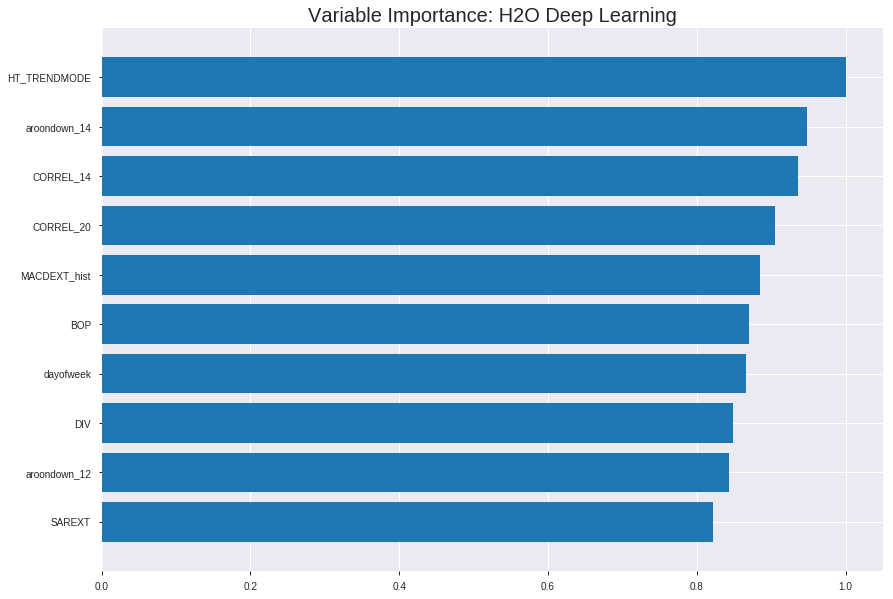

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190906_013936


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.31363875706840183
RMSE: 0.5600346034562523
LogLoss: 0.9049801293435116
Mean Per-Class Error: 0.4615100962685277
AUC: 0.5325724202376184
pr_auc: 0.5247690535980407
Gini: 0.06514484047523683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24893941520524254: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   653   0.9732   (653.0/671.0)
1      9    672   0.0132   (9.0/681.0)
Total  27   1325  0.4896   (662.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.248939     0.66999    378
max f2                       0.0877046    0.835378   399
max f0point5                 0.248939     0.561779   378
max accuracy                 0.77837      0.537722   132
max precision                0.951667     0.573333   20
max recall                   0.0877046    1          399
max specificity              0.99613      0.99851    0
max absolute_mcc             0.77837      0.0786836  132
max min_per_class_accuracy   0.730808     0.536513   162
max mean_per_class_accuracy  0.77837      0.53849    132

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 69.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010355                    0.983407           0.709041  0.709041           0.357143         0.990331  0.357143                    0.990331            0.00734214      0.00734214                 -29.0959   -29.0959
    2        0.0207101                   0.974671           1.27627   0.992658           0.642857         0.978591  0.5                         0.984461            0.0132159       0.020558                   27.6274    -0.734214
    3        0.0303254                   0.964127           1.37445   1.11371            0.692308         0.969197  0.560976                    0.979621            0.0132159       0.0337739                  37.4449    11.3714
    4        0.0406805                   0.957246           0.992658  1.0829             0.5              0.960532  0.545455                    0.974762            0.010279        0.0440529                  -0.734214  8.28995
    5        0.0502959                   0.953315           1.22173   1.10944            0.615385         0.955098  0.558824                    0.971003            0.0117474       0.0558003                  22.1733    10.9441
    6        0.100592                    0.926575           1.02185   1.06565            0.514706         0.940563  0.536765                    0.955783            0.051395        0.107195                   2.18537    6.56474
    7        0.150148                    0.900675           1.00747   1.04645            0.507463         0.914158  0.527094                    0.942044            0.0499266       0.157122                   0.747364   4.64472
    8        0.200444                    0.87586            1.10944   1.06225            0.558824         0.888357  0.535055                    0.928573            0.0558003       0.212922                   10.9441    6.22538
    9        0.300296                    0.822666           1.05884   1.06112            0.533333         0.849525  0.534483                    0.902289            0.105727        0.318649                   5.8835     6.1117
    10       0.400148                    0.776319           1.19119   1.09358            0.6              0.798344  0.550832                    0.87635             0.118943        0.437592                   19.1189    9.3575
    11       0.5                         0.730862           0.985305  1.07195            0.496296         0.753697  0.539941                    0.851856            0.0983847       0.535977                   -1.46952   7.1953
    12       0.599852                    0.664881           0.867656  1.03795            0.437037         0.699795  0.522811                    0.826544            0.0866373       0.622614                   -13.2344   3.79456
    13       0.699704                    0.596125           0.926481  1.02204            0.466667         0.632039  0.514799                    0.798787            0.092511        0.715125                   -7.35193   2.20388
    14       0.799556                    0.509834           0.970599  1.01561            0.488889         0.556694  0.511563                    0.768553            0.0969163       0.812041                   -2.94012   1.56148
    15       0.899408                    0.405456           0.926481  1.00572            0.466667         0.456468  0.506579                    0.733906            0.092511        0.904552                   -7.35193   0.571914
    16       1                           0.0877046          0.948864  1                  0.477941         0.307227  0.503698                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30549383459808377
RMSE: 0.5527149668663621
LogLoss: 0.8596308266176665
Mean Per-Class Error: 0.4504569892473118
AUC: 0.5124731182795699
pr_auc: 0.53078256403678
Gini: 0.024946236559139745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.041905426304570094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    185  0.9946   (185.0/186.0)
1      0    200  0        (0.0/200.0)
Total  1    385  0.4793   (185.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0419054    0.683761  384
max f2                       0.0419054    0.843882  384
max f0point5                 0.359352     0.584365  272
max accuracy                 0.359352     0.556995  272
max precision                0.999229     1         0
max recall                   0.0419054    1         384
max specificity              0.999229     1         0
max absolute_mcc             0.359352     0.108809  272
max min_per_class_accuracy   0.506022     0.495     191
max mean_per_class_accuracy  0.359352     0.549543  272

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 52.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.973197           0.965     0.965              0.5              0.992249  0.5                         0.992249            0.01            0.01                       -3.5      -3.5
    2        0.0207254                   0.960273           1.93      1.4475             1                0.965945  0.75                        0.979097            0.02            0.03                       93        44.75
    3        0.0310881                   0.949967           1.4475    1.4475             0.75             0.956171  0.75                        0.971455            0.015           0.045                      44.75     44.75
    4        0.0414508                   0.930318           0.965     1.32688            0.5              0.939185  0.6875                      0.963387            0.01            0.055                      -3.5      32.6875
    5        0.0518135                   0.917254           0.965     1.2545             0.5              0.92403   0.65                        0.955516            0.01            0.065                      -3.5      25.45
    6        0.101036                    0.868995           0.914211  1.08872            0.473684         0.893009  0.564103                    0.925064            0.045           0.11                       -8.57895  8.87179
    7        0.150259                    0.823525           0.914211  1.03155            0.473684         0.847368  0.534483                    0.899612            0.045           0.155                      -8.57895  3.15517
    8        0.202073                    0.78767            0.4825    0.890769           0.25             0.806857  0.461538                    0.875828            0.025           0.18                       -51.75    -10.9231
    9        0.300518                    0.678508           1.06658   0.948362           0.552632         0.74462   0.491379                    0.832846            0.105           0.285                      6.65789   -5.16379
    10       0.401554                    0.59083            1.08872   0.983677           0.564103         0.632561  0.509677                    0.782452            0.11            0.395                      8.87179   -1.63226
    11       0.5                         0.504896           1.01579   0.99               0.526316         0.549509  0.512953                    0.736588            0.1             0.495                      1.57895   -1
    12       0.601036                    0.435209           1.18769   1.02323            0.615385         0.476454  0.530172                    0.692858            0.12            0.615                      18.7692   2.32328
    13       0.699482                    0.36168            1.26974   1.05793            0.657895         0.397668  0.548148                    0.651313            0.125           0.74                       26.9737   5.79259
    14       0.800518                    0.304827           0.841282  1.03058            0.435897         0.334954  0.533981                    0.611384            0.085           0.825                      -15.8718  3.05825
    15       0.898964                    0.19497            0.812632  1.00671            0.421053         0.255473  0.521614                    0.572408            0.08            0.905                      -18.7368  0.67147
    16       1                           0.0400612          0.940256  1                  0.487179         0.137291  0.518135                    0.528446            0.095   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:39:36  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:39:36  0.088 sec   42250 obs/sec     1         1             1352       0.560035         0.90498             -0.254624      0.532572        0.524769           0.709041         0.489645                         0.552715           0.859631              -0.223585        0.512473          0.530783             0.965              0.479275
    2019-09-06 01:39:37  0.347 sec   52200 obs/sec     10        10            13520      0.478179         0.647874            0.085329       0.666856        0.652108           1.84351          0.403846                         0.571364           0.909298              -0.307546        0.493602          0.509621             0.965              0.474093
    2019-09-06 01:39:37  0.379 sec   51603 obs/sec     10        10            13520      0.560035         0.90498             -0.254624      0.532572        0.524769           0.709041         0.489645                         0.552715           0.859631              -0.223585        0.512473          0.530783             0.965              0.479275

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
HT_TRENDMODE    1.0                    1.0                  0.028446545486971696
aroondown_14    0.9476030468940735     0.9476030468940735   0.026956033177065235
CORREL_14       0.9355985522270203     0.9355985522270203   0.026614546773470797
CORREL_20       0.9057483673095703     0.9057483673095703   0.02576541213042204
MACDEXT_hist    0.8843343257904053     0.8843343257904053   0.02515625662428721
---             ---                    ---                  ---
WILLR_8         0.5200409889221191     0.5200409889221191   0.014793369646462808
STOCHRSI_fastk  0.5122607350349426     0.5122607350349426   0.014572048300361051
AROONOSC_12     0.5122320652008057     0.5122320652008057   0.01457123274262017
STOCHF_fastk    0.4276675283908844     0.4276675283908844   0.012165663799672053
AROONOSC_24     0.347910076379776      0.347910076379776    0.009896839813113095


See the whole table with table.as_data_frame()


('accuracy', 0.5515463917525774)

('F1', 0.6456140350877193)

('auc', 0.5256820119352089)

('logloss', 0.906035433318137)

('mean_per_class_error', 0.45311167945439046)

('rmse', 0.561984666917012)

('mse', 0.31582676584982494)

deeplearning prediction progress: |███████████████████████████████████████| 100%


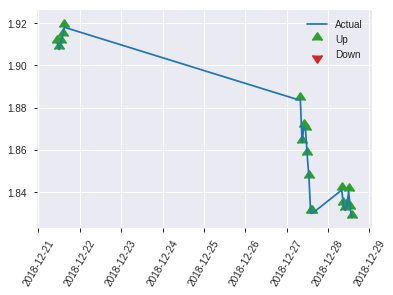


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31582676584982494
RMSE: 0.561984666917012
LogLoss: 0.906035433318137
Mean Per-Class Error: 0.45311167945439046
AUC: 0.5256820119352089
pr_auc: 0.4794290403322873
Gini: 0.05136402387041783
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07421594903413545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    101  0.9902   (101.0/102.0)
1      0    92   0        (0.0/92.0)
Total  1    193  0.5206   (101.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0742159    0.645614  192
max f2                       0.0742159    0.819964  192
max f0point5                 0.260625     0.534794  170
max accuracy                 0.714249     0.551546  78
max precision                0.714249     0.531646  78
max recall                   0.0742159    1         192
max specificity              0.994444     0.990196  0
max absolute_mcc             0.975148     0.09693   1
max min_per_class_accuracy   0.658966     0.521739  94
max mean_per_class_accuracy  0.714249     0.546888  78

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 60.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103093                   0.961751           0         0                  0                0.984796  0                           0.984796            0               0                          -100       -100
    2        0.0206186                   0.952005           1.05435   0.527174           0.5              0.957234  0.25                        0.971015            0.0108696       0.0108696                  5.43478    -47.2826
    3        0.0309278                   0.942722           1.05435   0.702899           0.5              0.948355  0.333333                    0.963462            0.0108696       0.0217391                  5.43478    -29.7101
    4        0.0412371                   0.935492           1.05435   0.790761           0.5              0.9414    0.375                       0.957946            0.0108696       0.0326087                  5.43478    -20.9239
    5        0.0515464                   0.931533           1.05435   0.843478           0.5              0.933368  0.4                         0.953031            0.0108696       0.0434783                  5.43478    -15.6522
    6        0.103093                    0.907892           1.26522   1.05435            0.6              0.918449  0.5                         0.93574             0.0652174       0.108696                   26.5217    5.43478
    7        0.149485                    0.874199           0.702899  0.945277           0.333333         0.887561  0.448276                    0.920788            0.0326087       0.141304                   -29.7101   -5.47226
    8        0.201031                    0.851431           1.05435   0.973244           0.5              0.859144  0.461538                    0.904982            0.0543478       0.195652                   5.43478    -2.67559
    9        0.298969                    0.788935           1.33181   1.0907             0.631579         0.825255  0.517241                    0.878865            0.130435        0.326087                   33.1808    9.07046
    10       0.402062                    0.727638           1.15978   1.10842            0.55             0.758245  0.525641                    0.847936            0.119565        0.445652                   15.9783    10.8417
    11       0.5                         0.655574           0.776888  1.04348            0.368421         0.687464  0.494845                    0.816504            0.076087        0.521739                   -22.3112   4.34783
    12       0.597938                    0.531761           0.998856  1.03617            0.473684         0.601714  0.491379                    0.781323            0.0978261       0.619565                   -0.114416  3.61694
    13       0.701031                    0.473938           0.948913  1.02334            0.45             0.505703  0.485294                    0.74079             0.0978261       0.717391                   -5.1087    2.33376
    14       0.798969                    0.336618           0.998856  1.02034            0.473684         0.399649  0.483871                    0.698973            0.0978261       0.815217                   -0.114416  2.03366
    15       0.896907                    0.240455           0.887872  1.00587            0.421053         0.295732  0.477011                    0.654941            0.0869565       0.902174                   -11.2128   0.587206
    16       1                           0.0433113          0.948913  1                  0.45             0.178069  0.474227                

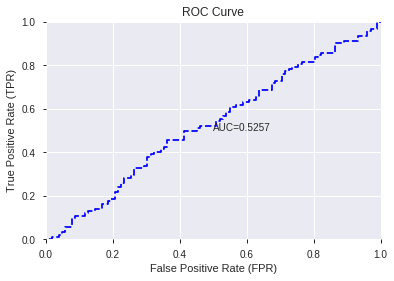

This function is available for GLM models only


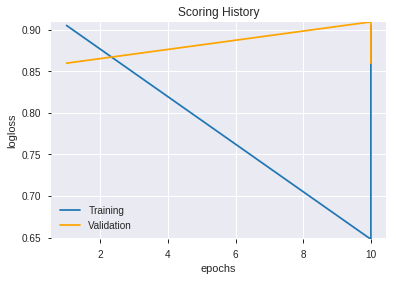

--2019-09-06 01:47:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190906_013936',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190906_013936',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_96e8'

['HT_TRENDMODE',
 'aroondown_14',
 'CORREL_14',
 'CORREL_20',
 'MACDEXT_hist',
 'BOP',
 'dayofweek',
 'DIV',
 'aroondown_12',
 'SAREXT',
 'CORREL_24',
 'WILLR_12',
 'TRANGE',
 'SIN',
 'DX_20',
 'aroonup_12',
 'SUB',
 'DX_14',
 'aroonup_14',
 'Volume',
 'NATR_30',
 'aroondown_24',
 'aroondown_20',
 'MINUS_DM_30',
 'CORREL_30',
 'days_in_month',
 'BETA_24',
 'DX_12',
 'hour',
 'STOCHF_fastd',
 'CCI_8',
 'weekday_name',
 'MFI_12',
 'DX_30',
 'weekday',
 'BETA_14',
 'STOCHRSI_fastd',
 'AROONOSC_14',
 'CORREL_12',
 'BETA_20',
 'HT_DCPERIOD',
 'aroondown_8',
 'MFI_14',
 'CDLLONGLEGGEDDOJI',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'STOCHRSI_fastk',
 'AROONOSC_12',
 'STOCHF_fastk',
 'AROONOSC_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_014726_model_1  0.550405  0.691114              0.467285  0.498983  0.248984

variable  relative_importance  scaled_importance  percentage
0                    SIN             0.009106           1.000000    0.053721
1          days_in_month             0.008117           0.891410    0.047888
2           aroondown_12             0.006940           0.762140    0.040943
3           STOCHF_fastk             0.006836           0.750705    0.040329
4                BETA_24             0.006426           0.705750    0.037914
5         STOCHRSI_fastk             0.006406           0.703523    0.037794
6           HT_TRENDMODE             0.006182           0.678967    0.036475
7              CORREL_30             0.006173           0.677924    0.036419
8              CORREL_24             0.006134           0.673608    0.036187
9            AROONOSC_12             0.005897           0.647573    0.034789
10               WILLR_8             0.005457           0.599309    0.032196
11          weekday_name             0.005373           0.590068    0.031699
12                  hour             0.004789           0.525936    0.028254
13                   BOP             0.004745           0.521054    0.027992
14                TRANGE             0.004377           0.480636    0.025820
15          aroondown_14             0.004330           0.475576    0.025549
16          STOCHF_fastd             0.004295           0.471627    0.025336
17             CORREL_12             0.004205           0.461828    0.024810
18             CORREL_20             0.003998           0.439117    0.023590
19     CDLLONGLEGGEDDOJI             0.003923           0.430823    0.023144
20        STOCHRSI_fastd             0.003706           0.406984    0.021864
21               BETA_20             0.003534           0.388061    0.020847
22  HT_PHASOR_quadrature             0.003396           0.372953    0.020036
23            aroonup_12             0.003367           0.369799    0.019866
24          MACDEXT_hist             0.003274           0.359548    0.019315
25           AROONOSC_24             0.003054           0.335399    0.018018
26           aroondown_8             0.002838           0.311720    0.016746
27               BETA_14             0.002685           0.294822    0.015838
28                MFI_12             0.002452           0.269228    0.014463
29           AROONOSC_14             0.002412           0.264902    0.014231
30                 DX_30             0.002372           0.260458    0.013992
31               weekday             0.002275           0.249843    0.013422
32             dayofweek             0.002265           0.248744    0.013363
33                SAREXT             0.002189           0.240447    0.012917
34                   DIV             0.002182           0.239642    0.012874
35                Volume             0.002069           0.227178    0.012204
36                   SUB             0.002040           0.224015    0.012034
37             CORREL_14             0.001976           0.217056    0.011661
38               NATR_30             0.001399           0.153600    0.008252
39          aroondown_24             0.001343           0.147529    0.007925
40           MINUS_DM_30             0.001338           0.146963    0.007895
41          aroondown_20             0.001323           0.145346    0.007808
42           HT_DCPERIOD             0.000737           0.080991    0.004351
43                 DX_12             0.000501           0.055050    0.002957
44                 DX_20             0.000389           0.042707    0.002294
45                 CCI_8             0.000225           0.024686    0.001326
46              WILLR_12             0.000218           0.023891    0.001283
47                MFI_14             0.000187           0.020579    0.001106
48            aroonup_14             0.000037           0.004055    0.000218
49                 DX_14             0.000007           0.000772    0.000041

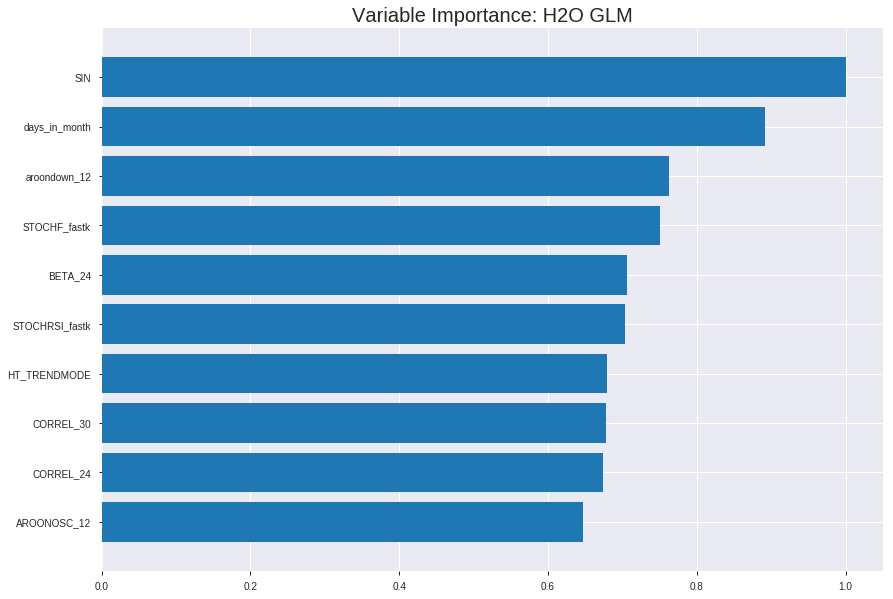

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_014726_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2489052299462491
RMSE: 0.4989040287933633
LogLoss: 0.6909566796854826
Null degrees of freedom: 1351
Residual degrees of freedom: 1301
Null deviance: 1874.1960110626424
Residual deviance: 1868.3468618695451
AIC: 1970.3468618695451
AUC: 0.5633426778801228
pr_auc: 0.552146944793397
Gini: 0.12668535576024564
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4876696762094373: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   623   0.9285   (623.0/671.0)
1      14   667   0.0206   (14.0/681.0)
Total  62   1290  0.4712   (637.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48767      0.676814  357
max f2                       0.480391     0.836619  384
max f0point5                 0.500282     0.578166  238
max accuracy                 0.500282     0.564349  238
max precision                0.525072     0.9       8
max recall                   0.47089      1         397
max specificity              0.531839     0.99851   0
max absolute_mcc             0.500282     0.132339  238
max min_per_class_accuracy   0.503608     0.540984  197
max mean_per_class_accuracy  0.500282     0.563269  238

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010355                    0.5246             1.7017    1.7017             0.857143         0.52653   0.857143                    0.52653             0.0176211       0.0176211                  70.1699    70.1699
    2        0.0207101                   0.523196           0.992658  1.34718            0.5              0.523914  0.678571                    0.525222            0.010279        0.0279001                  -0.734214  34.7179
    3        0.0303254                   0.522108           1.22173   1.3074             0.615385         0.522676  0.658537                    0.524415            0.0117474       0.0396476                  22.1733    30.7403
    4        0.0406805                   0.520828           1.27627   1.29948            0.642857         0.521389  0.654545                    0.523645            0.0132159       0.0528634                  27.6274    29.9479
    5        0.0502959                   0.519654           0.9163    1.22622            0.461538         0.520195  0.617647                    0.522985            0.00881057      0.061674                   -8.37004   22.6224
    6        0.100592                    0.516225           0.992658  1.10944            0.5              0.517993  0.558824                    0.520489            0.0499266       0.111601                   -0.734214  10.9441
    7        0.150148                    0.513826           1.03711   1.08557            0.522388         0.514931  0.546798                    0.518655            0.051395        0.162996                   3.71052    8.55667
    8        0.200444                    0.51173            1.10944   1.09156            0.558824         0.512753  0.549815                    0.517174            0.0558003       0.218796                   10.9441    9.15573
    9        0.300296                    0.508779           1.07354   1.08557            0.540741         0.510148  0.546798                    0.514837            0.107195        0.325991                   7.35411    8.55667
    10       0.400148                    0.50619            1.04413   1.07523            0.525926         0.507418  0.54159                     0.512986            0.104258        0.43025                    4.4129     7.52264
    11       0.5                         0.5036             1.11766   1.0837             0.562963         0.504913  0.545858                    0.511374            0.111601        0.54185                    11.7659    8.37004
    12       0.599852                    0.50132            1.10295   1.08691            0.555556         0.50241   0.547472                    0.509882            0.110132        0.651982                   10.2953    8.69053
    13       0.699704                    0.499046           0.941187  1.06611            0.474074         0.500236  0.536998                    0.508505            0.0939794       0.745962                   -5.88133   6.61103
    14       0.799556                    0.495954           0.911775  1.04684            0.459259         0.497491  0.52729                     0.50713             0.0910426       0.837004                   -8.82254   4.68362
    15       0.899408                    0.491184           0.882363  1.02858            0.444444         0.493906  0.518092                    0.505662            0.0881057       0.92511                    -11.7637   2.85764
    16       1                           0.469058           0.744493  1                  0.375            0.486144  0.503698                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24992514489708134
RMSE: 0.4999251392929559
LogLoss: 0.6929979544217832
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 534.9236366841775
Residual deviance: 534.9944208136167
AIC: 636.9944208136167
AUC: 0.5416397849462365
pr_auc: 0.5459415330135283
Gini: 0.0832795698924731
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45703343041588124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    184  0.9892   (184.0/186.0)
1      1    199  0.005    (1.0/200.0)
Total  3    383  0.4793   (185.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457033     0.682676  382
max f2                       0.445278     0.84317   385
max f0point5                 0.463307     0.576471  374
max accuracy                 0.492936     0.554404  143
max precision                0.516185     0.75      3
max recall                   0.445278     1         385
max specificity              0.51919      0.994624  0
max absolute_mcc             0.492936     0.122095  143
max min_per_class_accuracy   0.489007     0.526882  193
max mean_per_class_accuracy  0.492936     0.559086  143

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.515184           1.4475    1.4475             0.75             0.51758   0.75                        0.51758             0.015           0.015                      44.75     44.75
    2        0.0207254                   0.51328            0.965     1.20625            0.5              0.514165  0.625                       0.515872            0.01            0.025                      -3.5      20.625
    3        0.0310881                   0.512636           0.4825    0.965              0.25             0.5129    0.5                         0.514882            0.005           0.03                       -51.75    -3.5
    4        0.0414508                   0.511647           0         0.72375            0                0.512257  0.375                       0.514225            0               0.03                       -100      -27.625
    5        0.0518135                   0.510936           1.93      0.965              1                0.511325  0.5                         0.513645            0.02            0.05                       93        -3.5
    6        0.101036                    0.504787           1.11737   1.03923            0.578947         0.507742  0.538462                    0.510769            0.055           0.105                      11.7368   3.92308
    7        0.150259                    0.501202           1.11737   1.06483            0.578947         0.503005  0.551724                    0.508226            0.055           0.16                       11.7368   6.48276
    8        0.202073                    0.499498           1.158     1.08872            0.6              0.500223  0.564103                    0.506174            0.06            0.22                       15.8      8.87179
    9        0.300518                    0.496171           1.26974   1.14802            0.657895         0.497851  0.594828                    0.503447            0.125           0.345                      26.9737   14.8017
    10       0.401554                    0.492255           0.989744  1.10819            0.512821         0.493993  0.574194                    0.501068            0.1             0.445                      -1.02564  10.8194
    11       0.5                         0.489056           0.812632  1.05               0.421053         0.490635  0.544041                    0.499014            0.08            0.525                      -18.7368  5
    12       0.601036                    0.486016           1.03923   1.04819            0.538462         0.487442  0.543103                    0.497069            0.105           0.63                       3.92308   4.81897
    13       0.699482                    0.483248           0.914211  1.02933            0.473684         0.4846    0.533333                    0.495314            0.09            0.72                       -8.57895  2.93333
    14       0.800518                    0.479399           0.890769  1.01184            0.461538         0.481347  0.524272                    0.493551            0.09            0.81                       -10.9231  1.18447
    15       0.898964                    0.472844           0.965     1.00671            0.5              0.476628  0.521614                    0.491698            0.095           0.905                      -3.5      0.67147
    16       1                           0.445278           0.940256  1                  0.487179         0.46521   0.518135                    0.489022            0.095       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:47:26  0.000 sec   2            2.4       51            1.38191           1.386
    2019-09-06 01:47:26  0.055 sec   4            1.5       51            1.38007           1.38767
    2019-09-06 01:47:26  0.101 sec   6            0.92      51            1.37775           1.39133
    2019-09-06 01:47:27  0.152 sec   8            0.57      51            1.37501           1.3981
    2019-09-06 01:47:27  0.213 sec   10           0.36      51            1.37197           1.4089

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5721649484536082)

('F1', 0.652014652014652)

('auc', 0.5504049445865302)

('logloss', 0.6911138104753783)

('mean_per_class_error', 0.42391304347826086)

('rmse', 0.49898288422130677)

('mse', 0.24898391874581405)

glm prediction progress: |████████████████████████████████████████████████| 100%


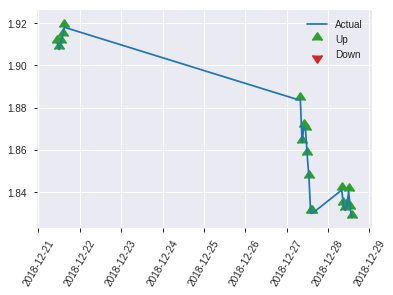


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24898391874581405
RMSE: 0.49898288422130677
LogLoss: 0.6911138104753783
Null degrees of freedom: 193
Residual degrees of freedom: 143
Null deviance: 269.09965128819607
Residual deviance: 268.15215846444676
AIC: 370.15215846444676
AUC: 0.5504049445865302
pr_auc: 0.4903320520325686
Gini: 0.10080988917306044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4756560727927841: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      10   92   0.902    (92.0/102.0)
1      3    89   0.0326   (3.0/92.0)
Total  13   181  0.4897   (95.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475656     0.652015  180
max f2                       0.456256     0.818505  193
max f0point5                 0.488659     0.559701  110
max accuracy                 0.489103     0.572165  106
max precision                0.522382     1         0
max recall                   0.456256     1         193
max specificity              0.522382     1         0
max absolute_mcc             0.488659     0.15358   110
max min_per_class_accuracy   0.489866     0.554348  95
max mean_per_class_accuracy  0.488659     0.576087  110

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.51464            1.05435   1.05435            0.5              0.519035  0.5                         0.519035            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.511044           0         0.527174           0                0.514085  0.25                        0.51656             0               0.0108696                  -100      -47.2826
    3        0.0309278                   0.50922            1.05435   0.702899           0.5              0.51026   0.333333                    0.51446             0.0108696       0.0217391                  5.43478   -29.7101
    4        0.0412371                   0.507356           1.05435   0.790761           0.5              0.50862   0.375                       0.513               0.0108696       0.0326087                  5.43478   -20.9239
    5        0.0515464                   0.506919           0         0.632609           0                0.507002  0.3                         0.5118              0               0.0326087                  -100      -36.7391
    6        0.103093                    0.503092           1.26522   0.948913           0.6              0.504947  0.45                        0.508374            0.0652174       0.0978261                  26.5217   -5.1087
    7        0.149485                    0.501144           1.4058    1.0907             0.666667         0.502043  0.517241                    0.506409            0.0652174       0.163043                   40.5797   9.07046
    8        0.201031                    0.49972            0.843478  1.02731            0.4              0.500586  0.487179                    0.504916            0.0434783       0.206522                   -15.6522  2.73133
    9        0.298969                    0.496767           1.44279   1.16342            0.684211         0.498015  0.551724                    0.502655            0.141304        0.347826                   44.2792   16.3418
    10       0.402062                    0.49326            0.948913  1.10842            0.45             0.495258  0.525641                    0.500758            0.0978261       0.445652                   -5.1087   10.8417
    11       0.5                         0.489789           1.10984   1.1087             0.526316         0.491394  0.525773                    0.498924            0.108696        0.554348                   10.984    10.8696
    12       0.597938                    0.488081           1.10984   1.10888            0.526316         0.489024  0.525862                    0.497303            0.108696        0.663043                   10.984    10.8883
    13       0.701031                    0.48576            0.738043  1.05435            0.35             0.487136  0.5                         0.495808            0.076087        0.73913                    -26.1957  5.43478
    14       0.798969                    0.482938           0.665904  1.00673            0.315789         0.484251  0.477419                    0.494391            0.0652174       0.804348                   -33.4096  0.673212
    15       0.896907                    0.476877           1.10984   1.01799            0.526316         0.480091  0.482759                    0.49283             0.108696        0.913043                   10.984    1.7991
    16       1                           0.456256           0.843478  1                  0.4              0.47151   0.474227                    0.490632     

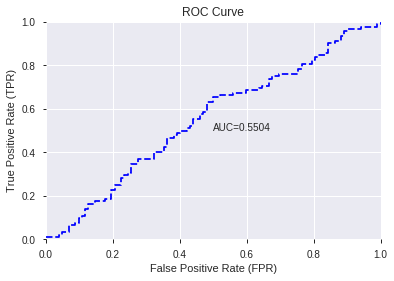

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


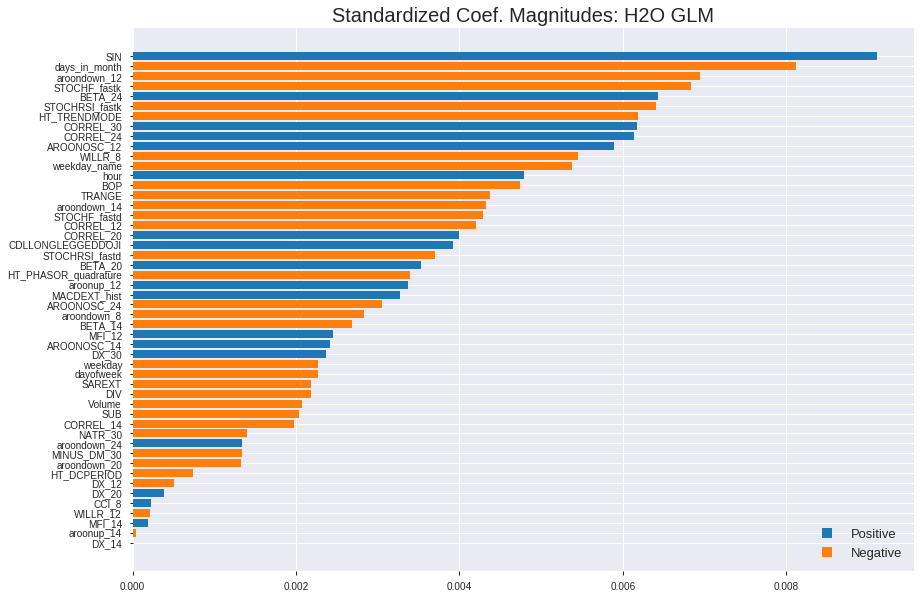

'log_likelihood'
--2019-09-06 01:47:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_014726_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_014726_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SIN',
 'days_in_month',
 'aroondown_12',
 'STOCHF_fastk',
 'BETA_24',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CORREL_30',
 'CORREL_24',
 'AROONOSC_12',
 'WILLR_8',
 'weekday_name',
 'hour',
 'BOP',
 'TRANGE',
 'aroondown_14',
 'STOCHF_fastd',
 'CORREL_12',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastd',
 'BETA_20',
 'HT_PHASOR_quadrature',
 'aroonup_12',
 'MACDEXT_hist',
 'AROONOSC_24',
 'aroondown_8',
 'BETA_14',
 'MFI_12',
 'AROONOSC_14',
 'DX_30',
 'weekday',
 'dayofweek',
 'SAREXT',
 'DIV',
 'Volume',
 'SUB',
 'CORREL_14',
 'NATR_30',
 'aroondown_24',
 'MINUS_DM_30',
 'aroondown_20',
 'HT_DCPERIOD',
 'DX_12',
 'DX_20',
 'CCI_8',
 'WILLR_12',
 'MFI_14',
 'aroonup_14',
 'DX_14']

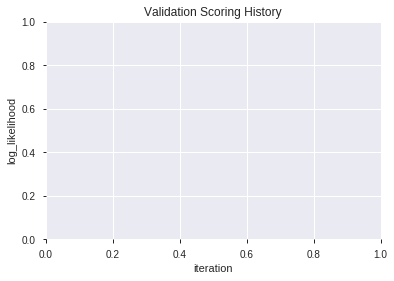

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_014740_model_5  0.523124  0.735041              0.495098  0.517730  0.268044
1  XGBoost_grid_1_AutoML_20190906_014740_model_6  0.523124  0.703843              0.495098  0.504598  0.254619
2  XGBoost_grid_1_AutoML_20190906_014740_model_4  0.520673  0.696277              0.500000  0.501471  0.251473
3  XGBoost_grid_1_AutoML_20190906_014740_model_3  0.495737  0.707759              0.481991  0.506846  0.256893
4  XGBoost_grid_1_AutoML_20190906_014740_model_1  0.488065  0.716470              0.481991  0.510652  0.260766
5               XGBoost_1_AutoML_20190906_014740  0.484015  0.732012              0.500000  0.517192  0.267487
6  XGBoost_grid_1_AutoML_20190906_014740_model_2  0.480286  0.704214              0.495098  0.505349  0.255378
7               XGBoost_3_AutoML_20190906_014740  0.479540  0.713480              0.477089  0.509797  0.259893
8  XGBoost_grid_1_AutoML_20190906_014740_model_7  0.474638  0.734635              0.485827  0.518754  0.269106
9               XGBoost_2_AutoML_20190906_014740  0.425831  0.734853              0.495098  0.519397  0.269773

variable  relative_importance  scaled_importance  percentage
0                 Volume           978.036560           1.000000    0.050242
1                    BOP           957.855225           0.979365    0.049205
2                  CCI_8           676.650818           0.691846    0.034760
3   HT_PHASOR_quadrature           641.538330           0.655945    0.032956
4           STOCHF_fastd           567.776367           0.580527    0.029167
5            HT_DCPERIOD           563.640869           0.576298    0.028954
6                BETA_24           562.780701           0.575419    0.028910
7                WILLR_8           556.135620           0.568625    0.028569
8           STOCHF_fastk           552.841064           0.565256    0.028399
9                  DX_12           549.978638           0.562329    0.028252
10                  hour           526.795044           0.538625    0.027061
11                SAREXT           526.482727           0.538306    0.027045
12               BETA_20           520.326233           0.532011    0.026729
13                MFI_12           509.296356           0.520733    0.026163
14                   SIN           507.270844           0.518662    0.026058
15             CORREL_30           502.757019           0.514047    0.025827
16             CORREL_12           499.761108           0.510984    0.025673
17        STOCHRSI_fastd           479.933655           0.490711    0.024654
18               NATR_30           478.811035           0.489564    0.024597
19                 DX_20           477.577911           0.488303    0.024533
20                   DIV           467.646912           0.478149    0.024023
21                MFI_14           458.616943           0.468916    0.023559
22              WILLR_12           426.513428           0.436091    0.021910
23               BETA_14           414.298035           0.423602    0.021282
24             CORREL_20           398.146179           0.407087    0.020453
25          MACDEXT_hist           397.449707           0.406375    0.020417
26             CORREL_14           357.977631           0.366017    0.018389
27                TRANGE           349.422333           0.357269    0.017950
28        STOCHRSI_fastk           345.765747           0.353530    0.017762
29                 DX_14           345.700562           0.353464    0.017759
30                 DX_30           334.611023           0.342125    0.017189
31           MINUS_DM_30           287.027313           0.293473    0.014745
32                   SUB           286.248413           0.292677    0.014705
33            aroonup_12           260.997467           0.266859    0.013407
34           AROONOSC_12           259.790680           0.265625    0.013345
35             CORREL_24           247.845245           0.253411    0.012732
36           AROONOSC_24           235.020340           0.240298    0.012073
37          aroondown_24           214.461227           0.219277    0.011017
38           aroondown_8           213.479065           0.218273    0.010966
39           AROONOSC_14           208.184891           0.212860    0.010694
40             dayofweek           195.644501           0.200038    0.010050
41          aroondown_20           194.746338           0.199120    0.010004
42          aroondown_12           193.382370           0.197725    0.009934
43            aroonup_14           175.711441           0.179657    0.009026
44          aroondown_14           168.049728           0.171824    0.008633
45          weekday_name           156.803284           0.160325    0.008055
46               weekday           100.158974           0.102408    0.005145
47         days_in_month            79.035072           0.080810    0.004060
48     CDLLONGLEGGEDDOJI            38.797176           0.039668    0.001993
49          HT_TRENDMODE            18.854122           0.019278    0.000969

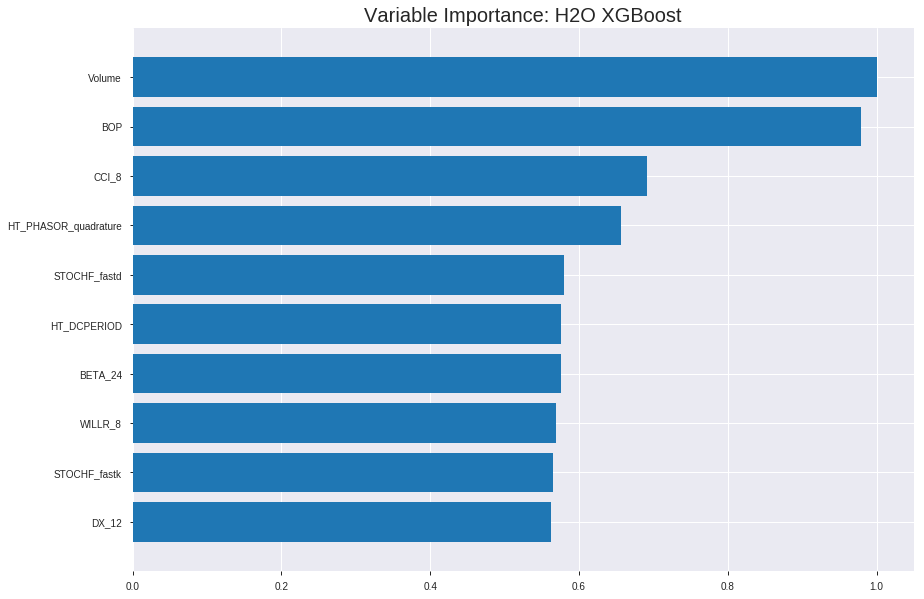

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_014740_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04058769421480172
RMSE: 0.20146387818862646
LogLoss: 0.21714925477161526
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9985315712187959
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5564486980438232: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      671  0    0        (0.0/671.0)
1      0    681  0        (0.0/681.0)
Total  671  681  0        (0.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.556449     1        196
max f2                       0.556449     1        196
max f0point5                 0.556449     1        196
max accuracy                 0.556449     1        196
max precision                0.927224     1        0
max recall                   0.556449     1        196
max specificity              0.927224     1        0
max absolute_mcc             0.556449     1        196
max min_per_class_accuracy   0.556449     1        196
max mean_per_class_accuracy  0.556449     1        196

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010355                    0.905689           1.98532    1.98532            1                0.912866  1                           0.912866            0.020558        0.020558                   98.5316  98.5316
    2        0.0207101                   0.891047           1.98532    1.98532            1                0.896821  1                           0.904843            0.020558        0.041116                   98.5316  98.5316
    3        0.0303254                   0.881138           1.98532    1.98532            1                0.885461  1                           0.898698            0.0190896       0.0602056                  98.5316  98.5316
    4        0.0406805                   0.874269           1.98532    1.98532            1                0.877449  1                           0.893289            0.020558        0.0807636                  98.5316  98.5316
    5        0.0502959                   0.869942           1.98532    1.98532            1                0.871746  1                           0.889171            0.0190896       0.0998532                  98.5316  98.5316
    6        0.100592                    0.852701           1.98532    1.98532            1                0.860509  1                           0.87484             0.0998532       0.199706                   98.5316  98.5316
    7        0.150148                    0.839456           1.98532    1.98532            1                0.845467  1                           0.865145            0.0983847       0.298091                   98.5316  98.5316
    8        0.200444                    0.826595           1.98532    1.98532            1                0.833133  1                           0.857113            0.0998532       0.397944                   98.5316  98.5316
    9        0.300296                    0.802314           1.98532    1.98532            1                0.814779  1                           0.843036            0.198238        0.596182                   98.5316  98.5316
    10       0.400148                    0.765419           1.98532    1.98532            1                0.787293  1                           0.829126            0.198238        0.79442                    98.5316  98.5316
    11       0.5                         0.638999           1.98532    1.98532            1                0.724031  1                           0.808138            0.198238        0.992658                   98.5316  98.5316
    12       0.599852                    0.24479            0.0735302  1.66708            0.037037         0.296944  0.839704                    0.723044            0.00734214      1                          -92.647  66.7078
    13       0.699704                    0.2027             0          1.42918            0                0.221022  0.719873                    0.651402            0               1                          -100     42.9175
    14       0.799556                    0.169945           0          1.25069            0                0.185295  0.629972                    0.593193            0               1                          -100     25.0694
    15       0.899408                    0.143434           0          1.11184            0                0.156674  0.560033                    0.544731            0               1                          -100     11.1842
    16       1                           0.0792666          0          1                  0                0.120099  0.503698                    0.502016        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26247474038240426
RMSE: 0.5123228868422767
LogLoss: 0.7216328282229281
Mean Per-Class Error: 0.4460215053763441
AUC: 0.5488440860215054
pr_auc: 0.5605548422403941
Gini: 0.09768817204301072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21477393805980682: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   171  0.9194   (171.0/186.0)
1      5    195  0.025    (5.0/200.0)
Total  20   366  0.456    (176.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214774     0.689046  365
max f2                       0.170138     0.845309  382
max f0point5                 0.306114     0.587636  317
max accuracy                 0.306114     0.554404  317
max precision                0.795049     1         0
max recall                   0.170138     1         382
max specificity              0.795049     1         0
max absolute_mcc             0.553872     0.12858   87
max min_per_class_accuracy   0.434208     0.521505  193
max mean_per_class_accuracy  0.553872     0.553978  87

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 44.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.759681           1.93      1.93               1                0.775377  1                           0.775377            0.02            0.02                       93        93
    2        0.0207254                   0.735502           0         0.965              0                0.748981  0.5                         0.762179            0               0.02                       -100      -3.5
    3        0.0310881                   0.711707           1.4475    1.12583            0.75             0.728062  0.583333                    0.750806            0.015           0.035                      44.75     12.5833
    4        0.0414508                   0.69459            0.965     1.08563            0.5              0.700986  0.5625                      0.738351            0.01            0.045                      -3.5      8.5625
    5        0.0518135                   0.68678            0.965     1.0615             0.5              0.69104   0.55                        0.728889            0.01            0.055                      -3.5      6.15
    6        0.101036                    0.640849           1.11737   1.08872            0.578947         0.66022   0.564103                    0.695435            0.055           0.11                       11.7368   8.87179
    7        0.150259                    0.59506            1.62526   1.26448            0.842105         0.619216  0.655172                    0.670467            0.08            0.19                       62.5263   26.4483
    8        0.202073                    0.56265            0.8685    1.16295            0.45             0.577357  0.602564                    0.646592            0.045           0.235                      -13.15    16.2949
    9        0.300518                    0.527289           1.01579   1.11474            0.526316         0.544424  0.577586                    0.613123            0.1             0.335                      1.57895   11.4741
    10       0.401554                    0.478684           0.841282  1.04594            0.435897         0.50571   0.541935                    0.586097            0.085           0.42                       -15.8718  4.59355
    11       0.5                         0.434408           1.01579   1.04               0.526316         0.455162  0.53886                     0.560317            0.1             0.52                       1.57895   4
    12       0.601036                    0.399855           1.13821   1.05651            0.589744         0.416412  0.547414                    0.536126            0.115           0.635                      13.8205   5.65086
    13       0.699482                    0.358301           0.965     1.04363            0.5              0.381967  0.540741                    0.514429            0.095           0.73                       -3.5      4.36296
    14       0.800518                    0.317539           0.989744  1.03683            0.512821         0.334616  0.537217                    0.491734            0.1             0.83                       -1.02564  3.68285
    15       0.898964                    0.262057           0.863421  1.01784            0.447368         0.291442  0.527378                    0.4698              0.085           0.915                      -13.6579  1.78386
    16       1                           0.141671           0.841282  1                  0.435897         0.213095  0.518135                    0.443864            0.085          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:47:55  3.020 sec   0                  0.5              0.693147            0.5             0                  1                0.496302                         0.5                0.693147              0.5               0                    1                  0.481865
    2019-09-06 01:47:56  3.270 sec   5                  0.449497         0.596466            0.967002        0.968899           1.98532          0.089497                         0.500662           0.694521              0.52121           0.520988             0.4825             0.481865
    2019-09-06 01:47:56  3.457 sec   10                 0.409073         0.524716            0.993094        0.990072           1.98532          0.0392012                        0.498516           0.690215              0.554839          0.560266             0.4825             0.474093
    2019-09-06 01:47:56  3.663 sec   15                 0.371292         0.461497            0.998419        0.996836           1.98532          0.0140533                        0.50137            0.696127              0.54129           0.537147             0.4825             0.463731
    2019-09-06 01:47:56  3.865 sec   20                 0.336463         0.406425            0.999897        0.996964           1.98532          0.00369822                       0.503488           0.700555              0.534866          0.540168             1.4475             0.474093
    2019-09-06 01:47:56  4.078 sec   25                 0.305348         0.359483            0.999995        0.997058           1.98532          0.000739645                      0.503641           0.700924              0.541048          0.551971             1.4475             0.466321
    2019-09-06 01:47:57  4.289 sec   30                 0.280947         0.324089            0.999999        0.99853            1.98532          0.000739645                      0.505843           0.705631              0.538817          0.555062             1.93               0.466321
    2019-09-06 01:47:57  4.538 sec   35                 0.255897         0.289134            0.999998        0.997061           1.98532          0.000739645                      0.506787           0.708026              0.544462          0.5605               1.4475             0.471503
    2019-09-06 01:47:57  4.758 sec   40                 0.236635         0.263032            1               0.997063           1.98532          0                                0.506505           0.70772               0.553118          0.56742              1.4475             0.463731
    2019-09-06 01:47:57  5.039 sec   45                 0.217351         0.237584            1               0.998532           1.98532          0                                0.509649           0.714999              0.547204          0.564696             1.4475             0.468912
    2019-09-06 01:47:58  5.305 sec   50                 0.201464         0.217149            1               0.998532           1.98532          0                                0.512323           0.721633              0.548844          0.560555             1.93               0.455959

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
Volume                978.0365600585938      1.0                   0.050241692885163225
BOP                   957.855224609375       0.9793654590499054    0.04920497861592225
CCI_8                 676.6508178710938      0.6918461389935728    0.03475952123910104
HT_PHASOR_quadrature  641.538330078125       0.6559451418050167    0.03295579436408249
STOCHF_fastd          567.7763671875         0.5805267311822012    0.02916664573968386
---                   ---                    ---                   ---
weekday_name          156.80328369140625     0.16032456259305095   0.008054977435748194
weekday               100.15897369384766     0.10240821026961117   0.005145161849285023
days_in_month         79.03507232666016      0.08080993651395323   0.004060028012403576
CDLLONGLEGGEDDOJI     38.797176361083984     0.03966843157556366   0.001993009156455581
HT_TRENDMODE          18.854122161865234     0.019277522877811124  0.0009685353840136944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515463917525774)

('F1', 0.6456140350877193)

('auc', 0.5231244671781756)

('logloss', 0.7350412264114482)

('mean_per_class_error', 0.4603580562659846)

('rmse', 0.5177297664265154)

('mse', 0.2680441110440541)

xgboost prediction progress: |████████████████████████████████████████████| 100%


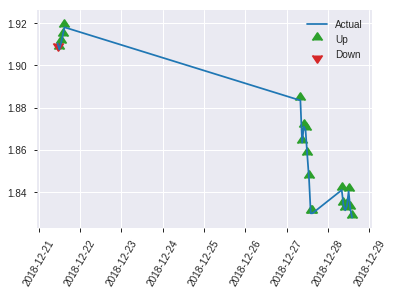


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2680441110440541
RMSE: 0.5177297664265154
LogLoss: 0.7350412264114482
Mean Per-Class Error: 0.4603580562659846
AUC: 0.5231244671781756
pr_auc: 0.5039368301576573
Gini: 0.046248934356351246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14953945577144623: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    101  0.9902   (101.0/102.0)
1      0    92   0        (0.0/92.0)
Total  1    193  0.5206   (101.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.149539     0.645614  192
max f2                       0.149539     0.819964  192
max f0point5                 0.257535     0.543194  167
max accuracy                 0.739004     0.551546  6
max precision                0.739004     0.857143  6
max recall                   0.149539     1         192
max specificity              0.786259     0.990196  0
max absolute_mcc             0.739004     0.148368  6
max min_per_class_accuracy   0.426232     0.529412  96
max mean_per_class_accuracy  0.39708      0.539642  109

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 43.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.762488           1.05435   1.05435            0.5              0.780195  0.5                         0.780195            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.749374           2.1087    1.58152            1                0.760535  0.75                        0.770365            0.0217391       0.0326087                  110.87    58.1522
    3        0.0309278                   0.740354           2.1087    1.75725            1                0.746583  0.833333                    0.762437            0.0217391       0.0543478                  110.87    75.7246
    4        0.0412371                   0.72774            1.05435   1.58152            0.5              0.733779  0.75                        0.755273            0.0108696       0.0652174                  5.43478   58.1522
    5        0.0515464                   0.703459           0         1.26522            0                0.715918  0.6                         0.747402            0               0.0652174                  -100      26.5217
    6        0.103093                    0.651533           1.05435   1.15978            0.5              0.675915  0.55                        0.711658            0.0543478       0.119565                   5.43478   15.9783
    7        0.149485                    0.603844           0.468599  0.945277           0.222222         0.62324   0.448276                    0.684218            0.0217391       0.141304                   -53.1401  -5.47226
    8        0.201031                    0.572654           1.05435   0.973244           0.5              0.585479  0.461538                    0.6589              0.0543478       0.195652                   5.43478   -2.67559
    9        0.298969                    0.516512           1.10984   1.01799            0.526316         0.542835  0.482759                    0.620879            0.108696        0.304348                   10.984    1.7991
    10       0.402062                    0.452428           1.15978   1.05435            0.55             0.489303  0.5                         0.587141            0.119565        0.423913                   15.9783   5.43478
    11       0.5                         0.426005           1.10984   1.06522            0.526316         0.440565  0.505155                    0.558431            0.108696        0.532609                   10.984    6.52174
    12       0.597938                    0.374318           0.887872  1.03617            0.421053         0.400462  0.491379                    0.532557            0.0869565       0.619565                   -11.2128  3.61694
    13       0.701031                    0.335902           0.843478  1.00783            0.4              0.353944  0.477941                    0.50629             0.0869565       0.706522                   -15.6522  0.783248
    14       0.798969                    0.28847            1.22082   1.03394            0.578947         0.314406  0.490323                    0.482769            0.119565        0.826087                   22.0824   3.39411
    15       0.896907                    0.228065           0.776888  1.00587            0.368421         0.264056  0.477011                    0.458886            0.076087        0.902174                   -22.3112  0.587206
    16       1                           0.125598           0.948913  1                  0.45             0.187707  0.474227                    0.43093       

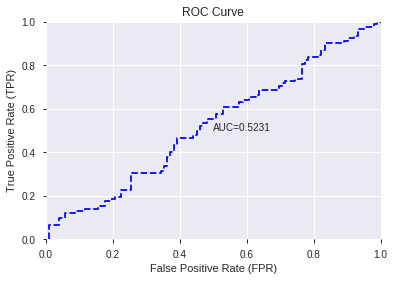

This function is available for GLM models only


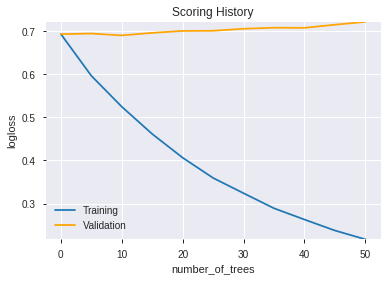

--2019-09-06 01:48:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_014740_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_014740_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'BOP',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'STOCHF_fastd',
 'HT_DCPERIOD',
 'BETA_24',
 'WILLR_8',
 'STOCHF_fastk',
 'DX_12',
 'hour',
 'SAREXT',
 'BETA_20',
 'MFI_12',
 'SIN',
 'CORREL_30',
 'CORREL_12',
 'STOCHRSI_fastd',
 'NATR_30',
 'DX_20',
 'DIV',
 'MFI_14',
 'WILLR_12',
 'BETA_14',
 'CORREL_20',
 'MACDEXT_hist',
 'CORREL_14',
 'TRANGE',
 'STOCHRSI_fastk',
 'DX_14',
 'DX_30',
 'MINUS_DM_30',
 'SUB',
 'aroonup_12',
 'AROONOSC_12',
 'CORREL_24',
 'AROONOSC_24',
 'aroondown_24',
 'aroondown_8',
 'AROONOSC_14',
 'dayofweek',
 'aroondown_20',
 'aroondown_12',
 'aroonup_14',
 'aroondown_14',
 'weekday_name',
 'weekday',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_014812_model_1  0.470588  0.69566                   0.5  0.501253  0.251254

variable  relative_importance  scaled_importance    percentage
0          CDLGAPSIDESIDEWHITE         9.028822e-03           1.000000  1.239938e-02
1               is_month_start         8.044989e-03           0.891034  1.104827e-02
2                          SIN         7.975710e-03           0.883361  1.095313e-02
3                CDLHIKKAKEMOD         7.925362e-03           0.877785  1.088399e-02
4           CDLMORNINGDOJISTAR         7.840823e-03           0.868421  1.076789e-02
...                        ...                  ...                ...           ...
1027                 dayofyear         1.905889e-07           0.000021  2.617378e-07
1028  BBANDS_middleband_20_0_2         0.000000e+00           0.000000  0.000000e+00
1029  BBANDS_middleband_20_0_3         0.000000e+00           0.000000  0.000000e+00
1030  BBANDS_middleband_20_0_4         0.000000e+00           0.000000  0.000000e+00
1031  BBANDS_middleband_20_0_5         0.000000e+00           0.000000  0.000000e+00

[1032 rows x 4 columns]

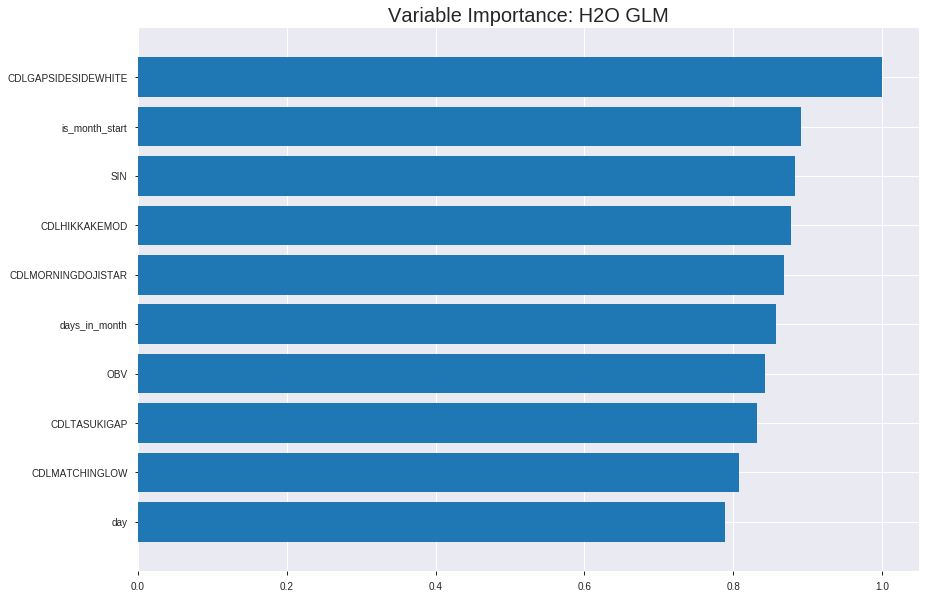

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_014812_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24659603663806876
RMSE: 0.4965843701105269
LogLoss: 0.6863275354192105
Null degrees of freedom: 1351
Residual degrees of freedom: 323
Null deviance: 1874.1960110626424
Residual deviance: 1855.8296557735453
AIC: 3913.8296557735453
AUC: 0.6160726204779068
pr_auc: 0.6114193280459685
Gini: 0.23214524095581357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48695033291385004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      139  532   0.7928   (532.0/671.0)
1      58   623   0.0852   (58.0/681.0)
Total  197  1155  0.4364   (590.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48695      0.678649  312
max f2                       0.460546     0.837226  391
max f0point5                 0.498181     0.595035  239
max accuracy                 0.498181     0.585799  239
max precision                0.588545     1         0
max recall                   0.460546     1         391
max specificity              0.588545     1         0
max absolute_mcc             0.490738     0.182923  291
max min_per_class_accuracy   0.503981     0.571219  200
max mean_per_class_accuracy  0.498181     0.584813  239

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.545624           1.84351   1.84351            0.928571         0.556412  0.928571                    0.556412            0.0190896       0.0190896                  84.3507     84.3507
    2        0.0207101                   0.538588           1.27627   1.55989            0.642857         0.541244  0.785714                    0.548828            0.0132159       0.0323054                  27.6274     55.9891
    3        0.0303254                   0.535986           1.37445   1.50109            0.692308         0.537601  0.756098                    0.545268            0.0132159       0.0455213                  37.4449     50.1092
    4        0.0406805                   0.532787           1.84351   1.58825            0.928571         0.534717  0.8                         0.542583            0.0190896       0.0646109                  84.3507     58.8253
    5        0.0502959                   0.530841           0.763583  1.4306             0.384615         0.531639  0.720588                    0.54049             0.00734214      0.071953                   -23.6417    43.0595
    6        0.100592                    0.524472           1.25542   1.34301            0.632353         0.527607  0.676471                    0.534049            0.0631424       0.135095                   25.542      34.3008
    7        0.150148                    0.519969           1.27416   1.32028            0.641791         0.522101  0.665025                    0.530105            0.0631424       0.198238                   27.4158     32.0284
    8        0.200444                    0.516965           1.28462   1.31133            0.647059         0.518351  0.660517                    0.527156            0.0646109       0.262849                   28.4616     31.1334
    9        0.300296                    0.512134           1.05884   1.22737            0.533333         0.514218  0.618227                    0.522854            0.105727        0.368576                   5.8835      22.7375
    10       0.400148                    0.507578           1.02942   1.17798            0.518519         0.509903  0.593346                    0.519622            0.10279         0.471366                   2.9423      17.7978
    11       0.5                         0.503852           1.01472   1.14537            0.511111         0.505663  0.576923                    0.516835            0.101322        0.572687                   1.47169     14.5374
    12       0.599852                    0.499606           1.00001   1.12118            0.503704         0.501829  0.564735                    0.514337            0.0998532       0.67254                    0.00108773  12.1177
    13       0.699704                    0.495166           0.955893  1.09759            0.481481         0.497485  0.552854                    0.511932            0.0954479       0.767988                   -4.41072    9.759
    14       0.799556                    0.490448           1.04413   1.09091            0.525926         0.493043  0.549491                    0.509573            0.104258        0.872247                   4.4129      9.09135
    15       0.899408                    0.48285            0.661772  1.04327            0.333333         0.487047  0.525493                    0.507072            0.0660793       0.938326                   -33.8228    4.32703
    16       1                           0.426735           0.613112  1                  0.308824         0.473531  0.503698     



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249818107367733
RMSE: 0.499818074270762
LogLoss: 0.6927826378399817
Null degrees of freedom: 385
Residual degrees of freedom: -643
Null deviance: 534.9236366841775
Residual deviance: 534.8281964124659
AIC: 2592.828196412466
AUC: 0.5366397849462365
pr_auc: 0.5522256922402488
Gini: 0.07327956989247308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4408588841951551: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    181  0.9731   (181.0/186.0)
1      1    199  0.005    (1.0/200.0)
Total  6    380  0.4715   (182.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440859     0.686207   379
max f2                       0.434602     0.845309   382
max f0point5                 0.450436     0.578979   370
max accuracy                 0.477776     0.549223   257
max precision                0.540177     1          0
max recall                   0.434602     1          382
max specificity              0.540177     1          0
max absolute_mcc             0.526359     0.0986824  3
max min_per_class_accuracy   0.486619     0.54       192
max mean_per_class_accuracy  0.485776     0.545941   200

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.525971           1.93      1.93               1                0.530849  1                           0.530849            0.02            0.02                       93        93
    2        0.0207254                   0.524813           0.965     1.4475             0.5              0.525636  0.75                        0.528242            0.01            0.03                       -3.5      44.75
    3        0.0310881                   0.522283           0.4825    1.12583            0.25             0.52444   0.583333                    0.526975            0.005           0.035                      -51.75    12.5833
    4        0.0414508                   0.5198             1.4475    1.20625            0.75             0.520128  0.625                       0.525263            0.015           0.05                       44.75     20.625
    5        0.0518135                   0.519463           0.965     1.158              0.5              0.519587  0.6                         0.524128            0.01            0.06                       -3.5      15.8
    6        0.101036                    0.512896           0.914211  1.03923            0.473684         0.515408  0.538462                    0.51988             0.045           0.105                      -8.57895  3.92308
    7        0.150259                    0.507065           1.21895   1.0981             0.631579         0.510159  0.568966                    0.516695            0.06            0.165                      21.8947   9.81034
    8        0.202073                    0.50337            1.0615    1.08872            0.55             0.505398  0.564103                    0.513799            0.055           0.22                       6.15      8.87179
    9        0.300518                    0.497153           1.01579   1.06483            0.526316         0.500002  0.551724                    0.509279            0.1             0.32                       1.57895   6.48276
    10       0.401554                    0.492573           1.03923   1.05839            0.538462         0.494795  0.548387                    0.505634            0.105           0.425                      3.92308   5.83871
    11       0.5                         0.486577           1.16816   1.08               0.605263         0.489031  0.559585                    0.502365            0.115           0.54                       16.8158   8
    12       0.601036                    0.481772           0.890769  1.04819            0.461538         0.48434   0.543103                    0.499335            0.09            0.63                       -10.9231  4.81897
    13       0.699482                    0.475989           0.914211  1.02933            0.473684         0.479005  0.533333                    0.496474            0.09            0.72                       -8.57895  2.93333
    14       0.800518                    0.469008           0.841282  1.0056             0.435897         0.472304  0.521036                    0.493423            0.085           0.805                      -15.8718  0.559871
    15       0.898964                    0.460432           1.01579   1.00671            0.526316         0.464653  0.521614                    0.490273            0.1             0.905                      1.57895   0.67147
    16       1                           0.432933           0.940256  1                  0.487179         0.449763  0.518135                    0.48618             0.095        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:48:15  0.000 sec   2            2.7       1029          1.37266           1.38557
    2019-09-06 01:48:17  1.635 sec   4            2         1032          1.36885           1.38632
    2019-09-06 01:48:19  3.253 sec   6            1.4       1033          1.36439           1.38838
    2019-09-06 01:48:20  4.886 sec   8            1.1       1033          1.35927           1.39202
    2019-09-06 01:48:22  6.502 sec   10           0.77      1033          1.3535            1.39751
    2019-09-06 01:48:24  8.139 sec   12           0.56      1033          1.34718           1.40568

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5412371134020618)

('F1', 0.6433566433566433)

('auc', 0.47058823529411764)

('logloss', 0.695659675590916)

('mean_per_class_error', 0.4639812446717818)

('rmse', 0.5012526893055765)

('mse', 0.25125425853607286)

glm prediction progress: |████████████████████████████████████████████████| 100%


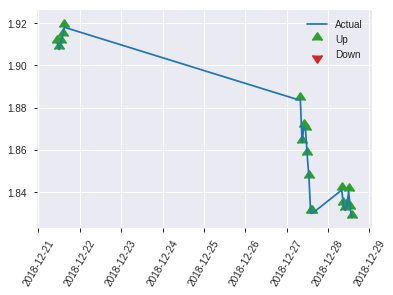


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25125425853607286
RMSE: 0.5012526893055765
LogLoss: 0.695659675590916
Null degrees of freedom: 193
Residual degrees of freedom: -835
Null deviance: 269.09965128819607
Residual deviance: 269.9159541292754
AIC: 2327.9159541292756
AUC: 0.47058823529411764
pr_auc: 0.42983433677384497
Gini: -0.05882352941176472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43208605871150185: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432086     0.643357  193
max f2                       0.432086     0.818505  193
max f0point5                 0.457529     0.533175  187
max accuracy                 0.491024     0.541237  72
max precision                0.550346     1         0
max recall                   0.432086     1         193
max specificity              0.550346     1         0
max absolute_mcc             0.513807     0.208741  18
max min_per_class_accuracy   0.485685     0.478261  96
max mean_per_class_accuracy  0.490102     0.536019  76

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 48.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.532655           1.05435   1.05435            0.5              0.542882  0.5                         0.542882            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.528079           0         0.527174           0                0.530312  0.25                        0.536597            0               0.0108696                  -100      -47.2826
    3        0.0309278                   0.520888           0         0.351449           0                0.526416  0.166667                    0.533203            0               0.0108696                  -100      -64.8551
    4        0.0412371                   0.519256           0         0.263587           0                0.519602  0.125                       0.529803            0               0.0108696                  -100      -73.6413
    5        0.0515464                   0.517417           1.05435   0.421739           0.5              0.518602  0.2                         0.527563            0.0108696       0.0217391                  5.43478   -57.8261
    6        0.103093                    0.513683           0.421739  0.421739           0.2              0.515111  0.2                         0.521337            0.0217391       0.0434783                  -57.8261  -57.8261
    7        0.149485                    0.506279           0.937198  0.581709           0.444444         0.509687  0.275862                    0.517722            0.0434783       0.0869565                  -6.28019  -41.8291
    8        0.201031                    0.50053            1.05435   0.702899           0.5              0.503151  0.333333                    0.513986            0.0543478       0.141304                   5.43478   -29.7101
    9        0.298969                    0.493966           1.44279   0.945277           0.684211         0.497659  0.448276                    0.508637            0.141304        0.282609                   44.2792   -5.47226
    10       0.402062                    0.489994           1.47609   1.08138            0.7              0.491806  0.512821                    0.504321            0.152174        0.434783                   47.6087   8.13824
    11       0.5                         0.485682           0.443936  0.956522           0.210526         0.487562  0.453608                    0.501039            0.0434783       0.478261                   -55.6064  -4.34783
    12       0.597938                    0.481222           1.22082   0.999813           0.578947         0.483332  0.474138                    0.498138            0.119565        0.597826                   22.0824   -0.0187406
    13       0.701031                    0.477841           0.948913  0.992327           0.45             0.479669  0.470588                    0.495422            0.0978261       0.695652                   -5.1087   -0.767263
    14       0.798969                    0.472593           0.887872  0.979523           0.421053         0.475721  0.464516                    0.493007            0.0869565       0.782609                   -11.2128  -2.04769
    15       0.896907                    0.464336           1.10984   0.993753           0.526316         0.46919   0.471264                    0.490407            0.108696        0.891304                   10.984    -0.624688
    16       1                           0.432086           1.05435   1                  0.5              0.457022  0.474227                    

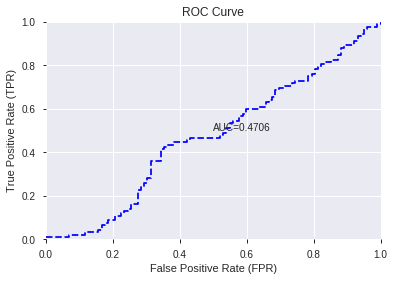

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


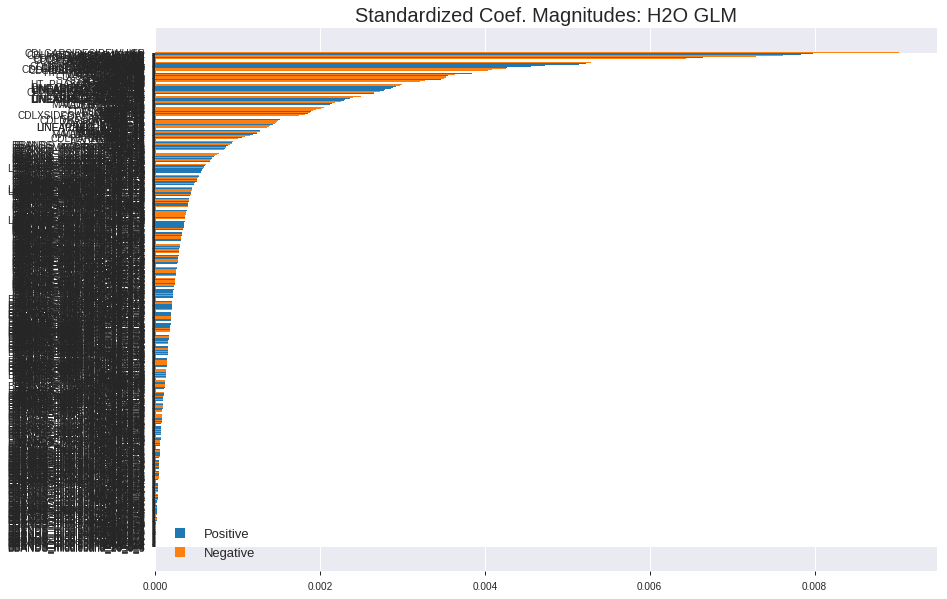

'log_likelihood'
--2019-09-06 01:48:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.184
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.184|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_014812_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_014812_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

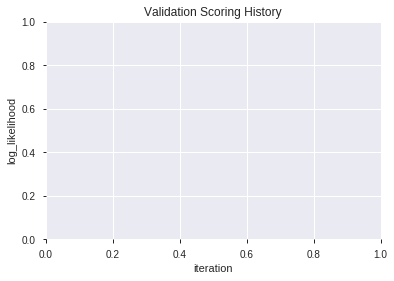

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_014900_model_3  0.525362  0.750170              0.500000  0.524297  0.274887
1  XGBoost_grid_1_AutoML_20190906_014900_model_2  0.502238  0.699914              0.463981  0.503224  0.253235
2               XGBoost_3_AutoML_20190906_014900  0.494672  0.746654              0.500000  0.522640  0.273153
3  XGBoost_grid_1_AutoML_20190906_014900_model_1  0.491155  0.784704              0.495098  0.536892  0.288253
4               XGBoost_1_AutoML_20190906_014900  0.485401  0.751372              0.500000  0.524201  0.274786
5  XGBoost_grid_1_AutoML_20190906_014900_model_4  0.482896  0.710028              0.495098  0.507892  0.257954
6               XGBoost_2_AutoML_20190906_014900  0.476130  0.717928              0.490729  0.511213  0.261338
7  XGBoost_grid_1_AutoML_20190906_014900_model_5  0.474318  0.779057              0.500000  0.534430  0.285615
8  XGBoost_grid_1_AutoML_20190906_014900_model_7  0.473892  0.777623              0.500000  0.533890  0.285038
9  XGBoost_grid_1_AutoML_20190906_014900_model_6  0.466539  0.749083              0.500000  0.523756  0.274320

variable  relative_importance  scaled_importance  percentage
0                    BETA_20           126.411957           1.000000    0.026467
1                        BOP           100.077377           0.791677    0.020953
2                   CORREL_8            98.006355           0.775293    0.020520
3                     Volume            95.944679           0.758984    0.020088
4                  CORREL_12            95.900635           0.758636    0.020079
..                       ...                  ...                ...         ...
265  BBANDS_lowerband_12_7_5             1.090649           0.008628    0.000228
266   LINEARREG_INTERCEPT_20             1.032715           0.008169    0.000216
267              MIDPOINT_24             0.927063           0.007334    0.000194
268       LINEARREG_SLOPE_20             0.922504           0.007298    0.000193
269                   KAMA_8             0.262581           0.002077    0.000055

[270 rows x 4 columns]

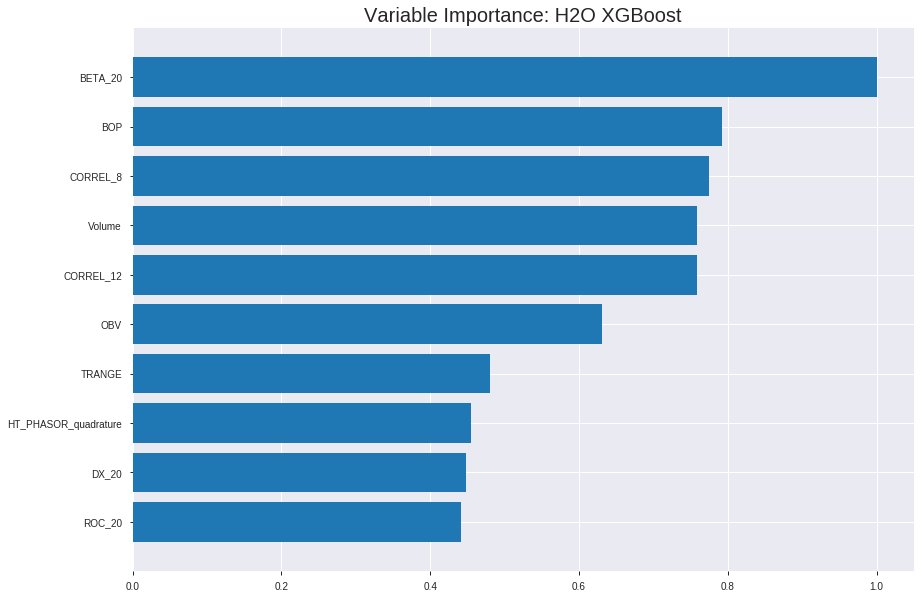

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_014900_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17598666242854336
RMSE: 0.419507642872622
LogLoss: 0.5404630082573721
Mean Per-Class Error: 0.131707776107285
AUC: 0.9437992257375517
pr_auc: 0.9467875558619063
Gini: 0.8875984514751034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49560873955488205: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      560  111  0.1654   (111.0/671.0)
1      71   610  0.1043   (71.0/681.0)
Total  631  721  0.1346   (182.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495609     0.870185  202
max f2                       0.464115     0.913043  231
max f0point5                 0.545114     0.889549  157
max accuracy                 0.505252     0.868343  193
max precision                0.777736     1         0
max recall                   0.338918     1         341
max specificity              0.777736     1         0
max absolute_mcc             0.505252     0.736701  193
max min_per_class_accuracy   0.509831     0.864905  189
max mean_per_class_accuracy  0.505252     0.868292  193

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010355                    0.734458           1.98532    1.98532            1                0.753333  1                           0.753333            0.020558        0.020558                   98.5316   98.5316
    2        0.0207101                   0.718881           1.98532    1.98532            1                0.725504  1                           0.739419            0.020558        0.041116                   98.5316   98.5316
    3        0.0303254                   0.702731           1.98532    1.98532            1                0.708961  1                           0.729761            0.0190896       0.0602056                  98.5316   98.5316
    4        0.0406805                   0.691973           1.98532    1.98532            1                0.698107  1                           0.721704            0.020558        0.0807636                  98.5316   98.5316
    5        0.0502959                   0.687005           1.98532    1.98532            1                0.689811  1                           0.715607            0.0190896       0.0998532                  98.5316   98.5316
    6        0.100592                    0.656521           1.95612    1.97072            0.985294         0.66993   0.992647                    0.692769            0.0983847       0.198238                   95.612    97.0718
    7        0.150148                    0.630657           1.98532    1.97554            1                0.642999  0.995074                    0.676342            0.0983847       0.296623                   98.5316   97.5536
    8        0.200444                    0.611823           1.98532    1.97799            1                0.623039  0.99631                     0.662967            0.0998532       0.396476                   98.5316   97.799
    9        0.300296                    0.579727           1.86767    1.94131            0.940741         0.595365  0.977833                    0.640489            0.18649         0.582966                   86.7667   94.1306
    10       0.400148                    0.545366           1.58825    1.85321            0.8              0.562054  0.933457                    0.620916            0.15859         0.741557                   58.8253   85.3206
    11       0.5                         0.509785           1.2059     1.72394            0.607407         0.529489  0.868343                    0.602658            0.120411        0.861968                   20.5895   72.3935
    12       0.599852                    0.474243           0.750008   1.56181            0.377778         0.490993  0.786683                    0.58407             0.0748899       0.936858                   -24.9992  56.1814
    13       0.699704                    0.435736           0.411769   1.3977             0.207407         0.453649  0.704017                    0.565458            0.041116        0.977974                   -58.8231  39.7696
    14       0.799556                    0.392372           0.14706    1.24151            0.0740741        0.413243  0.625347                    0.546449            0.0146843       0.992658                   -85.294   24.1511
    15       0.899408                    0.345676           0.0441181  1.10858            0.0222222        0.372669  0.558388                    0.527156            0.00440529      0.997063                   -95.5882  10.8577
    16       1                           0.187612           0.0291958  1                  0.0147059        0.301024  0.503698                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2914800751734069
RMSE: 0.5398889470746803
LogLoss: 0.7869152050530515
Mean Per-Class Error: 0.4845967741935484
AUC: 0.4886827956989247
pr_auc: 0.5025746548977097
Gini: -0.022634408602150602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1447548270225525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    186  1        (186.0/186.0)
1      0    200  0        (0.0/200.0)
Total  0    386  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144755     0.682594  385
max f2                       0.144755     0.84317   385
max f0point5                 0.234282     0.574074  354
max accuracy                 0.234282     0.525907  354
max precision                0.384176     0.544643  111
max recall                   0.144755     1         385
max specificity              0.552267     0.994624  0
max absolute_mcc             0.186706     0.110475  380
max min_per_class_accuracy   0.326852     0.489247  192
max mean_per_class_accuracy  0.384176     0.515403  111

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 34.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.536266           0         0                  0                0.547389  0                           0.547389            0               0                          -100      -100
    2        0.0207254                   0.527908           1.4475    0.72375            0.75             0.532559  0.375                       0.539974            0.015           0.015                      44.75     -27.625
    3        0.0310881                   0.518038           0.965     0.804167           0.5              0.521848  0.416667                    0.533932            0.01            0.025                      -3.5      -19.5833
    4        0.0414508                   0.510546           0.4825    0.72375            0.25             0.514486  0.375                       0.529071            0.005           0.03                       -51.75    -27.625
    5        0.0518135                   0.505136           1.4475    0.8685             0.75             0.508161  0.45                        0.524889            0.015           0.045                      44.75     -13.15
    6        0.101036                    0.475357           1.11737   0.989744           0.578947         0.492786  0.512821                    0.509249            0.055           0.1                        11.7368   -1.02564
    7        0.150259                    0.447511           0.914211  0.965              0.473684         0.460848  0.5                         0.493393            0.045           0.145                      -8.57895  -3.5
    8        0.202073                    0.419484           0.965     0.965              0.5              0.434339  0.5                         0.478251            0.05            0.195                      -3.5      -3.5
    9        0.300518                    0.38153            1.16816   1.03155            0.605263         0.396968  0.534483                    0.451624            0.115           0.31                       16.8158   3.15517
    10       0.401554                    0.357439           0.742308  0.958774           0.384615         0.370783  0.496774                    0.431283            0.075           0.385                      -25.7692  -4.12258
    11       0.5                         0.32648            1.06658   0.98               0.552632         0.34238   0.507772                    0.413779            0.105           0.49                       6.65789   -2
    12       0.601036                    0.302489           0.940256  0.973319           0.487179         0.315412  0.50431                     0.397243            0.095           0.585                      -5.97436  -2.6681
    13       0.699482                    0.28109            1.11737   0.993593           0.578947         0.292207  0.514815                    0.38246             0.11            0.695                      11.7368   -0.640741
    14       0.800518                    0.262974           1.13821   1.01184            0.589744         0.270769  0.524272                    0.368363            0.115           0.81                       13.8205   1.18447
    15       0.898964                    0.239472           0.863421  0.995591           0.447368         0.251699  0.51585                     0.355587            0.085           0.895                      -13.6579  -0.440922
    16       1                           0.144755           1.03923   1                  0.538462         0.210087  0.518135                    0.340887            0.105


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:49:16  4.590 sec   0                  0.5              0.693147            0.5             0                  1                0.496302                         0.5                0.693147              0.5               0                    1                  0.481865
    2019-09-06 01:49:16  5.133 sec   5                  0.489618         0.672544            0.741678        0.733478           1.7017           0.352811                         0.502115           0.69741               0.502567          0.505148             0                  0.481865
    2019-09-06 01:49:16  5.358 sec   10                 0.481975         0.657565            0.799958        0.800652           1.98532          0.310651                         0.505342           0.70399               0.466694          0.49268              0.4825             0.481865
    2019-09-06 01:49:17  5.579 sec   15                 0.473236         0.640571            0.830005        0.838099           1.98532          0.272929                         0.511338           0.716639              0.482903          0.495894             0.4825             0.481865
    2019-09-06 01:49:17  5.822 sec   20                 0.462975         0.621005            0.874655        0.873511           1.98532          0.206361                         0.513007           0.720551              0.511653          0.521621             1.4475             0.481865
    2019-09-06 01:49:17  6.064 sec   25                 0.455554         0.606903            0.891956        0.895836           1.98532          0.201923                         0.518186           0.732089              0.50543           0.520159             0.965              0.481865
    2019-09-06 01:49:17  6.364 sec   30                 0.448967         0.594579            0.909653        0.911584           1.98532          0.181953                         0.519308           0.734697              0.506398          0.523976             0.965              0.481865
    2019-09-06 01:49:18  6.633 sec   35                 0.437921         0.574168            0.928648        0.930771           1.98532          0.144231                         0.522001           0.741279              0.505134          0.515158             0.4825             0.481865
    2019-09-06 01:49:18  6.913 sec   40                 0.430471         0.560454            0.937228        0.941686           1.98532          0.136095                         0.525599           0.749759              0.489409          0.503409             0                  0.481865
    2019-09-06 01:49:18  7.183 sec   45                 0.424705         0.549828            0.938031        0.940406           1.98532          0.133136                         0.531491           0.764687              0.494059          0.502566             0                  0.481865
    2019-09-06 01:49:18  7.448 sec   50                 0.419508         0.540463            0.943799        0.946788           1.98532          0.134615                         0.539889           0.786915              0.488683          0.502575             0                  0.481865

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BETA_20                  126.41195678710938     1.0                    0.026466996291876613
BOP                      100.07737731933594     0.7916765143338177     0.020953299369238954
CORREL_8                 98.00635528564453      0.775293396104114      0.02051968743980401
Volume                   95.9446792602539       0.758984210819824      0.020088032293361178
CORREL_12                95.900634765625        0.7586357904982948     0.02007881065400325
---                      ---                    ---                    ---
BBANDS_lowerband_12_7_5  1.0906486511230469     0.008627733316080301   0.00022835018568399763
LINEARREG_INTERCEPT_20   1.03271484375          0.008169439584652558   0.00021622052719370927
MIDPOINT_24              0.92706298828125       0.007333665357641118   0.00019410009382655143
LINEARREG_SLOPE_20       0.9225044250488281     0.007297604186306677   0.00019314566293856207
KAMA_8                   0.26258087158203125    0.0020771838222886163  5.49768165220589e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5670103092783505)

('F1', 0.6433566433566433)

('auc', 0.5253623188405797)

('logloss', 0.7501697233598721)

('mean_per_class_error', 0.4522591645353794)

('rmse', 0.5242969497511155)

('mse', 0.2748872915183237)

xgboost prediction progress: |████████████████████████████████████████████| 100%


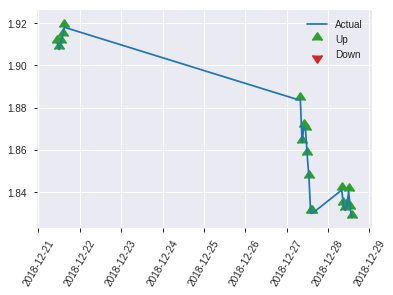


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2748872915183237
RMSE: 0.5242969497511155
LogLoss: 0.7501697233598721
Mean Per-Class Error: 0.4522591645353794
AUC: 0.5253623188405797
pr_auc: 0.5069222357248074
Gini: 0.050724637681159424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18922042846679688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18922      0.643357  193
max f2                       0.18922      0.818505  193
max f0point5                 0.231966     0.535714  179
max accuracy                 0.402165     0.56701   23
max precision                0.463018     0.8       4
max recall                   0.18922      1         193
max specificity              0.53683      0.990196  0
max absolute_mcc             0.402165     0.144805  23
max min_per_class_accuracy   0.304282     0.509804  96
max mean_per_class_accuracy  0.402165     0.547741  23

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 31.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.512138           1.05435   1.05435            0.5              0.526064  0.5                         0.526064            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.463888           2.1087    1.58152            1                0.490568  0.75                        0.508316            0.0217391       0.0326087                  110.87    58.1522
    3        0.0309278                   0.460541           1.05435   1.4058             0.5              0.462426  0.666667                    0.493019            0.0108696       0.0434783                  5.43478   40.5797
    4        0.0412371                   0.455982           1.05435   1.31793            0.5              0.458732  0.625                       0.484448            0.0108696       0.0543478                  5.43478   31.7935
    5        0.0515464                   0.444908           1.05435   1.26522            0.5              0.450213  0.6                         0.477601            0.0108696       0.0652174                  5.43478   26.5217
    6        0.103093                    0.416744           1.26522   1.26522            0.6              0.432962  0.6                         0.455281            0.0652174       0.130435                   26.5217   26.5217
    7        0.149485                    0.385015           1.1715    1.23613            0.555556         0.399546  0.586207                    0.437984            0.0543478       0.184783                   17.1498   23.6132
    8        0.201031                    0.374003           0.843478  1.13545            0.4              0.380978  0.538462                    0.423367            0.0434783       0.228261                   -15.6522  13.5452
    9        0.298969                    0.351875           0.776888  1.01799            0.368421         0.364739  0.482759                    0.404161            0.076087        0.304348                   -22.3112  1.7991
    10       0.402062                    0.32061            0.843478  0.973244           0.4              0.334146  0.461538                    0.386209            0.0869565       0.391304                   -15.6522  -2.67559
    11       0.5                         0.30392            1.22082   1.02174            0.578947         0.311537  0.484536                    0.371582            0.119565        0.51087                    22.0824   2.17391
    12       0.597938                    0.292945           0.887872  0.999813           0.421053         0.299186  0.474138                    0.359724            0.0869565       0.597826                   -11.2128  -0.0187406
    13       0.701031                    0.278567           1.26522   1.03884            0.6              0.285449  0.492647                    0.348801            0.130435        0.728261                   26.5217   3.88427
    14       0.798969                    0.25815            0.887872  1.02034            0.421053         0.269826  0.483871                    0.339121            0.0869565       0.815217                   -11.2128  2.03366
    15       0.896907                    0.238296           0.887872  1.00587            0.421053         0.247318  0.477011                    0.329096            0.0869565       0.902174                   -11.2128  0.587206
    16       1                           0.18922            0.948913  1                  0.45             0.220332  0.474227                    0.317883     

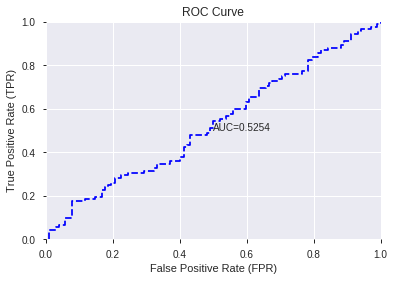

This function is available for GLM models only


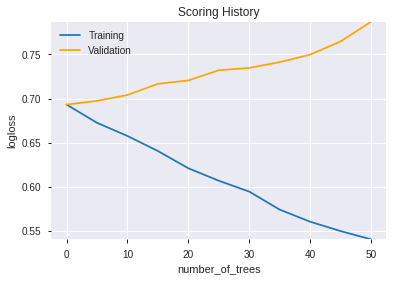

--2019-09-06 01:49:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_014900_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_014900_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190906_014945  0.542626  0.870304              0.495098  0.551751  0.304429
1  DeepLearning_grid_1_AutoML_20190906_014945_model_5  0.522911  0.707751              0.500000  0.506769  0.256814
2  DeepLearning_grid_1_AutoML_20190906_014945_model_8  0.522059  0.700627              0.500000  0.503035  0.253044
3  DeepLearning_grid_1_AutoML_20190906_014945_model_9  0.513267  0.693755              0.500000  0.500295  0.250295
4  DeepLearning_grid_1_AutoML_20190906_014945_model_6  0.511083  0.723364              0.500000  0.511987  0.262131
5  DeepLearning_grid_1_AutoML_20190906_014945_model_1  0.509591  1.187632              0.500000  0.605456  0.366578
6  DeepLearning_grid_1_AutoML_20190906_014945_model_4  0.498934  0.962909              0.495098  0.574688  0.330266
7  DeepLearning_grid_1_AutoML_20190906_014945_model_3  0.485401  0.874949              0.495098  0.559506  0.313047
8  DeepLearning_grid_1_AutoML_20190906_014945_model_7  0.471334  1.023828              0.480925  0.568727  0.323450
9  DeepLearning_grid_1_AutoML_20190906_014945_model_2  0.457055  1.048422              0.485294  0.600873  0.361048

variable  relative_importance  scaled_importance  percentage
0           HT_TRENDMODE             1.000000           1.000000    0.028385
1              CORREL_14             0.937680           0.937680    0.026616
2           aroondown_14             0.930420           0.930420    0.026410
3           MACDEXT_hist             0.893394           0.893394    0.025359
4              CORREL_20             0.891114           0.891114    0.025294
5              dayofweek             0.871405           0.871405    0.024735
6                    BOP             0.864619           0.864619    0.024542
7                    DIV             0.859829           0.859829    0.024406
8                 SAREXT             0.829212           0.829212    0.023537
9           aroondown_12             0.826686           0.826686    0.023465
10             CORREL_24             0.819300           0.819300    0.023256
11              WILLR_12             0.809833           0.809833    0.022987
12                TRANGE             0.800360           0.800360    0.022718
13                   SIN             0.796459           0.796459    0.022607
14            aroonup_12             0.793679           0.793679    0.022528
15                 DX_20             0.786451           0.786451    0.022323
16            aroonup_14             0.775476           0.775476    0.022012
17                 DX_14             0.774812           0.774812    0.021993
18                   SUB             0.769294           0.769294    0.021836
19               NATR_30             0.761754           0.761754    0.021622
20                Volume             0.755741           0.755741    0.021452
21          aroondown_24             0.737391           0.737391    0.020931
22          aroondown_20             0.734620           0.734620    0.020852
23             CORREL_30             0.717051           0.717051    0.020353
24               BETA_24             0.709872           0.709872    0.020150
25           MINUS_DM_30             0.707988           0.707988    0.020096
26         days_in_month             0.695289           0.695289    0.019736
27                 DX_12             0.689727           0.689727    0.019578
28          STOCHF_fastd             0.687630           0.687630    0.019518
29                  hour             0.675687           0.675687    0.019179
30                 CCI_8             0.673253           0.673253    0.019110
31          weekday_name             0.663357           0.663357    0.018829
32                MFI_12             0.658688           0.658688    0.018697
33                 DX_30             0.636095           0.636095    0.018055
34               weekday             0.624359           0.624359    0.017722
35           AROONOSC_14             0.620200           0.620200    0.017604
36        STOCHRSI_fastd             0.613844           0.613844    0.017424
37               BETA_14             0.608476           0.608476    0.017271
38             CORREL_12             0.606564           0.606564    0.017217
39               BETA_20             0.589054           0.589054    0.016720
40           aroondown_8             0.580023           0.580023    0.016464
41           HT_DCPERIOD             0.552893           0.552893    0.015694
42     CDLLONGLEGGEDDOJI             0.546703           0.546703    0.015518
43                MFI_14             0.535992           0.535992    0.015214
44               WILLR_8             0.522414           0.522414    0.014829
45  HT_PHASOR_quadrature             0.521322           0.521322    0.014798
46        STOCHRSI_fastk             0.511502           0.511502    0.014519
47           AROONOSC_12             0.500397           0.500397    0.014204
48          STOCHF_fastk             0.424465           0.424465    0.012048
49           AROONOSC_24             0.337773           0.337773    0.009588

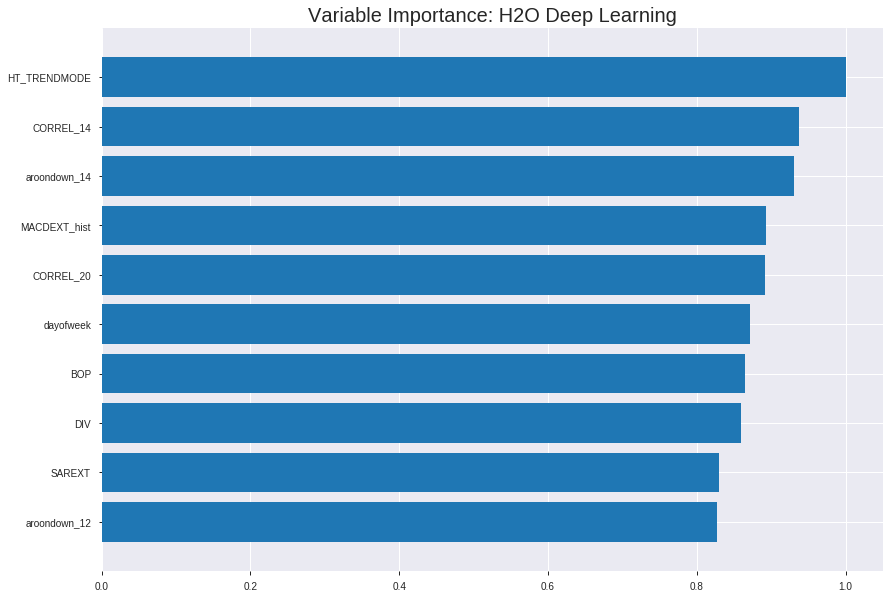

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190906_014945


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3099882610695493
RMSE: 0.5567658943124564
LogLoss: 0.8895042985468781
Mean Per-Class Error: 0.4682263524973138
AUC: 0.5303478928812937
pr_auc: 0.5209461561892151
Gini: 0.060695785762587384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04771355068222235: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    671   1        (671.0/671.0)
1      0    681   0        (0.0/681.0)
Total  0    1352  0.4963   (671.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0477136    0.669946   399
max f2                       0.0477136    0.835378   399
max f0point5                 0.440802     0.56441    305
max accuracy                 0.71345      0.531805   168
max precision                0.996392     0.666667   0
max recall                   0.0477136    1          399
max specificity              0.996392     0.99851    0
max absolute_mcc             0.440802     0.0691048  305
max min_per_class_accuracy   0.714815     0.529061   167
max mean_per_class_accuracy  0.71345      0.531774   168

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 67.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.982033           0.992658  0.992658           0.5              0.989736  0.5                         0.989736            0.010279        0.010279                   -0.734214   -0.734214
    2        0.0207101                   0.969187           0.425425  0.709041           0.214286         0.975686  0.357143                    0.982711            0.00440529      0.0146843                  -57.4575    -29.0959
    3        0.0303254                   0.961417           1.52717   0.968447           0.769231         0.965046  0.487805                    0.97711             0.0146843       0.0293686                  52.7166     -3.15533
    4        0.0406805                   0.952835           1.13447   1.01071            0.571429         0.956798  0.509091                    0.97194             0.0117474       0.041116                   13.4466     1.07062
    5        0.0502959                   0.943569           1.22173   1.05105            0.615385         0.947142  0.529412                    0.967199            0.0117474       0.0528634                  22.1733     5.10495
    6        0.100592                    0.915952           1.08025   1.06565            0.544118         0.929282  0.536765                    0.948241            0.0543319       0.107195                   8.02453     6.56474
    7        0.150148                    0.884684           1.126     1.08557            0.567164         0.898572  0.546798                    0.931848            0.0558003       0.162996                   12.6        8.55667
    8        0.200444                    0.863589           1.19703   1.11354            0.602941         0.874256  0.560886                    0.917397            0.0602056       0.223201                   19.7029     11.3535
    9        0.300296                    0.81477            0.941187  1.05623            0.474074         0.838855  0.53202                     0.891281            0.0939794       0.317181                   -5.88133    5.62271
    10       0.400148                    0.759114           1.00001   1.0422             0.503704         0.787908  0.524954                    0.865485            0.0998532       0.417034                   0.00108773  4.2199
    11       0.5                         0.714669           1.13237   1.06021            0.57037          0.737239  0.534024                    0.839874            0.113069        0.530103                   13.2365     6.02056
    12       0.599852                    0.657144           0.838244  1.02326            0.422222         0.687225  0.515413                    0.814464            0.0837004       0.613803                   -16.1756    2.32577
    13       0.699704                    0.592703           1.05884   1.02833            0.533333         0.627862  0.51797                     0.787834            0.105727        0.71953                    5.8835      2.83348
    14       0.799556                    0.497825           0.941187  1.01745            0.474074         0.542514  0.512488                    0.757198            0.0939794       0.81351                    -5.88133    1.74513
    15       0.899408                    0.383917           1.00001   1.01552            0.503704         0.446742  0.511513                    0.722731            0.0998532       0.913363                   0.00108773  1.55151
    16       1                           0.0477136          0.861277  1                  0.433824         0.280505  0.503698



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30499985564077264
RMSE: 0.5522679201626441
LogLoss: 0.8547167679985427
Mean Per-Class Error: 0.46395161290322573
AUC: 0.5144354838709677
pr_auc: 0.5276831335245312
Gini: 0.028870967741935427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03181940570553093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    186  1        (186.0/186.0)
1      0    200  0        (0.0/200.0)
Total  0    386  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0318194    0.682594   385
max f2                       0.0318194    0.84317    385
max f0point5                 0.170979     0.58125    349
max accuracy                 0.350219     0.541451   250
max precision                0.999095     1          0
max recall                   0.0318194    1          385
max specificity              0.999095     1          0
max absolute_mcc             0.170979     0.0829563  349
max min_per_class_accuracy   0.470324     0.49       190
max mean_per_class_accuracy  0.350219     0.536048   250

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.957691           0.965     0.965              0.5              0.991921  0.5                         0.991921            0.01            0.01                       -3.5      -3.5
    2        0.0207254                   0.948232           1.4475    1.20625            0.75             0.950721  0.625                       0.971321            0.015           0.025                      44.75     20.625
    3        0.0310881                   0.932058           0.965     1.12583            0.5              0.940882  0.583333                    0.961175            0.01            0.035                      -3.5      12.5833
    4        0.0414508                   0.913347           1.4475    1.20625            0.75             0.925042  0.625                       0.952142            0.015           0.05                       44.75     20.625
    5        0.0518135                   0.8975             0.965     1.158              0.5              0.905611  0.6                         0.942835            0.01            0.06                       -3.5      15.8
    6        0.101036                    0.833895           0.914211  1.03923            0.473684         0.861402  0.538462                    0.903163            0.045           0.105                      -8.57895  3.92308
    7        0.150259                    0.78695            1.01579   1.03155            0.526316         0.811498  0.534483                    0.873135            0.05            0.155                      1.57895   3.15517
    8        0.202073                    0.743456           1.158     1.06397            0.6              0.76002   0.551282                    0.844131            0.06            0.215                      15.8      6.39744
    9        0.300518                    0.644862           0.812632  0.981638           0.421053         0.694093  0.508621                    0.794981            0.08            0.295                      -18.7368  -1.83621
    10       0.401554                    0.523361           1.08872   1.00858            0.564103         0.583908  0.522581                    0.741872            0.11            0.405                      8.87179   0.858065
    11       0.5                         0.464676           0.863421  0.98               0.447368         0.493038  0.507772                    0.692879            0.085           0.49                       -13.6579  -2
    12       0.601036                    0.393433           1.38564   1.04819            0.717949         0.425603  0.543103                    0.647949            0.14            0.63                       38.5641   4.81897
    13       0.699482                    0.320891           1.01579   1.04363            0.526316         0.352201  0.540741                    0.606325            0.1             0.73                       1.57895   4.36296
    14       0.800518                    0.255821           0.841282  1.01809            0.435897         0.286956  0.527508                    0.566016            0.085           0.815                      -15.8718  1.80906
    15       0.898964                    0.173677           1.01579   1.01784            0.526316         0.212692  0.527378                    0.527324            0.1             0.915                      1.57895   1.78386
    16       1                           0.0318194          0.841282  1                  0.435897         0.126861  0.518135                    0.486863            0.085   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:49:46  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:49:46  0.092 sec   42250 obs/sec     1         1             1352       0.556766         0.889504            -0.240021      0.530348        0.520946           0.992658         0.496302                         0.552268           0.854717              -0.221606        0.514435          0.527683             0.965              0.481865
    2019-09-06 01:49:46  0.296 sec   61176 obs/sec     10        10            13520      0.485894         0.663138            0.0555779      0.662315        0.645093           1.55989          0.411982                         0.566705           0.881114              -0.286311        0.496935          0.51128              1.4475             0.474093
    2019-09-06 01:49:46  0.313 sec   60627 obs/sec     10        10            13520      0.556766         0.889504            -0.240021      0.530348        0.520946           0.992658         0.496302                         0.552268           0.854717              -0.221606        0.514435          0.527683             0.965              0.481865

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
HT_TRENDMODE          1.0                    1.0                  0.028384782377274282
CORREL_14             0.937679648399353      0.937679648399353    0.026615832759414704
aroondown_14          0.9304200410842896     0.9304200410842896   0.026409770385632157
MACDEXT_hist          0.8933939933776855     0.8933939933776855   0.025358794079189628
CORREL_20             0.8911138772964478     0.8911138772964478   0.02529407348042877
---                   ---                    ---                  ---
HT_PHASOR_quadrature  0.5213217735290527     0.5213217735290527   0.014797605090156832
STOCHRSI_fastk        0.5115018486976624     0.5115018486976624   0.014518868660856624
AROONOSC_12           0.5003970861434937     0.5003970861434937   0.01420366239240524
STOCHF_fastk          0.4244646728038788     0.4244646728038788   0.012048337364379033
AROONOSC_24           0.3377734124660492     0.3377734124660492   0.00958762480567811


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5773195876288659)

('F1', 0.6456140350877193)

('auc', 0.5426257459505541)

('logloss', 0.8703038935076153)

('mean_per_class_error', 0.42966751918158563)

('rmse', 0.551750629839772)

('mse', 0.3044287575285851)

deeplearning prediction progress: |███████████████████████████████████████| 100%


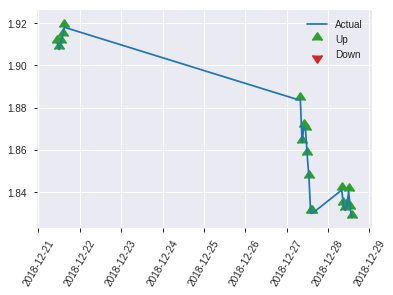


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3044287575285851
RMSE: 0.551750629839772
LogLoss: 0.8703038935076153
Mean Per-Class Error: 0.42966751918158563
AUC: 0.5426257459505541
pr_auc: 0.48723041004376044
Gini: 0.08525149190110826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09611430420578047: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    101  0.9902   (101.0/102.0)
1      0    92   0        (0.0/92.0)
Total  1    193  0.5206   (101.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0961143    0.645614  192
max f2                       0.0961143    0.819964  192
max f0point5                 0.489025     0.539384  122
max accuracy                 0.755753     0.57732   61
max precision                0.755753     0.580645  61
max recall                   0.0961143    1         192
max specificity              0.994931     0.990196  0
max absolute_mcc             0.727254     0.146258  69
max min_per_class_accuracy   0.63571      0.539216  96
max mean_per_class_accuracy  0.727254     0.570332  69

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 58.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103093                   0.956026           0         0                  0                0.978095  0                           0.978095            0               0                          -100       -100
    2        0.0206186                   0.935708           0         0                  0                0.94686   0                           0.962477            0               0                          -100       -100
    3        0.0309278                   0.928205           1.05435   0.351449           0.5              0.932393  0.166667                    0.952449            0.0108696       0.0108696                  5.43478    -64.8551
    4        0.0412371                   0.921741           1.05435   0.527174           0.5              0.925771  0.25                        0.945779            0.0108696       0.0217391                  5.43478    -47.2826
    5        0.0515464                   0.905298           1.05435   0.632609           0.5              0.913358  0.3                         0.939295            0.0108696       0.0326087                  5.43478    -36.7391
    6        0.103093                    0.882209           1.26522   0.948913           0.6              0.89723   0.45                        0.918263            0.0652174       0.0978261                  26.5217    -5.1087
    7        0.149485                    0.852359           1.1715    1.01799            0.555556         0.868981  0.482759                    0.902968            0.0543478       0.152174                   17.1498    1.7991
    8        0.201031                    0.823917           1.26522   1.08138            0.6              0.837328  0.512821                    0.886137            0.0652174       0.217391                   26.5217    8.13824
    9        0.298969                    0.764705           1.44279   1.19978            0.684211         0.791255  0.568966                    0.855055            0.141304        0.358696                   44.2792    19.9775
    10       0.402062                    0.699594           1.05435   1.16249            0.5              0.735679  0.551282                    0.824446            0.108696        0.467391                   5.43478    16.2486
    11       0.5                         0.625039           0.776888  1.08696            0.368421         0.672029  0.515464                    0.794591            0.076087        0.543478                   -22.3112   8.69565
    12       0.597938                    0.499246           0.887872  1.05435            0.421053         0.562419  0.5                         0.756563            0.0869565       0.630435                   -11.2128   5.43478
    13       0.701031                    0.40476            0.843478  1.02334            0.4              0.461204  0.485294                    0.713128            0.0869565       0.717391                   -15.6522   2.33376
    14       0.798969                    0.333684           0.998856  1.02034            0.473684         0.370054  0.483871                    0.671074            0.0978261       0.815217                   -0.114416  2.03366
    15       0.896907                    0.230737           0.887872  1.00587            0.421053         0.284372  0.477011                    0.628848            0.0869565       0.902174                   -11.2128   0.587206
    16       1                           0.036062           0.948913  1                  0.45             0.168239  0.474227                    0.5

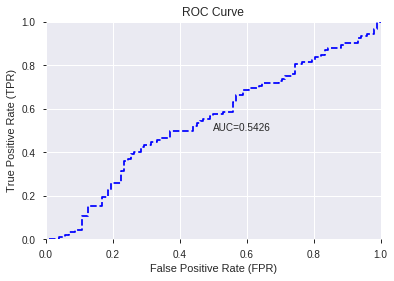

This function is available for GLM models only


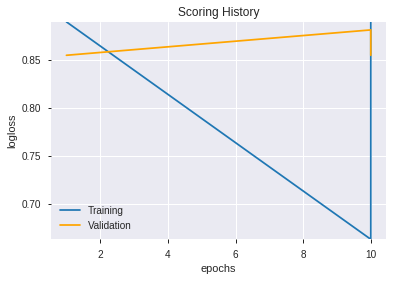

--2019-09-06 01:58:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190906_014945',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190906_014945',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_96e8'

['HT_TRENDMODE',
 'CORREL_14',
 'aroondown_14',
 'MACDEXT_hist',
 'CORREL_20',
 'dayofweek',
 'BOP',
 'DIV',
 'SAREXT',
 'aroondown_12',
 'CORREL_24',
 'WILLR_12',
 'TRANGE',
 'SIN',
 'aroonup_12',
 'DX_20',
 'aroonup_14',
 'DX_14',
 'SUB',
 'NATR_30',
 'Volume',
 'aroondown_24',
 'aroondown_20',
 'CORREL_30',
 'BETA_24',
 'MINUS_DM_30',
 'days_in_month',
 'DX_12',
 'STOCHF_fastd',
 'hour',
 'CCI_8',
 'weekday_name',
 'MFI_12',
 'DX_30',
 'weekday',
 'AROONOSC_14',
 'STOCHRSI_fastd',
 'BETA_14',
 'CORREL_12',
 'BETA_20',
 'aroondown_8',
 'HT_DCPERIOD',
 'CDLLONGLEGGEDDOJI',
 'MFI_14',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'AROONOSC_12',
 'STOCHF_fastk',
 'AROONOSC_24']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_015829_model_1  0.550405  0.691114              0.467285  0.498983  0.248984

variable  relative_importance  scaled_importance  percentage
0                    SIN             0.009106           1.000000    0.053721
1          days_in_month             0.008117           0.891410    0.047888
2           aroondown_12             0.006940           0.762140    0.040943
3           STOCHF_fastk             0.006836           0.750705    0.040329
4                BETA_24             0.006426           0.705750    0.037914
5         STOCHRSI_fastk             0.006406           0.703523    0.037794
6           HT_TRENDMODE             0.006182           0.678967    0.036475
7              CORREL_30             0.006173           0.677924    0.036419
8              CORREL_24             0.006134           0.673608    0.036187
9            AROONOSC_12             0.005897           0.647573    0.034789
10               WILLR_8             0.005457           0.599309    0.032196
11          weekday_name             0.005373           0.590068    0.031699
12                  hour             0.004789           0.525936    0.028254
13                   BOP             0.004745           0.521054    0.027992
14                TRANGE             0.004377           0.480636    0.025820
15          aroondown_14             0.004330           0.475576    0.025549
16          STOCHF_fastd             0.004295           0.471627    0.025336
17             CORREL_12             0.004205           0.461828    0.024810
18             CORREL_20             0.003998           0.439117    0.023590
19     CDLLONGLEGGEDDOJI             0.003923           0.430823    0.023144
20        STOCHRSI_fastd             0.003706           0.406984    0.021864
21               BETA_20             0.003534           0.388061    0.020847
22  HT_PHASOR_quadrature             0.003396           0.372953    0.020036
23            aroonup_12             0.003367           0.369799    0.019866
24          MACDEXT_hist             0.003274           0.359548    0.019315
25           AROONOSC_24             0.003054           0.335399    0.018018
26           aroondown_8             0.002838           0.311720    0.016746
27               BETA_14             0.002685           0.294822    0.015838
28                MFI_12             0.002452           0.269228    0.014463
29           AROONOSC_14             0.002412           0.264902    0.014231
30                 DX_30             0.002372           0.260458    0.013992
31               weekday             0.002275           0.249843    0.013422
32             dayofweek             0.002265           0.248744    0.013363
33                SAREXT             0.002189           0.240447    0.012917
34                   DIV             0.002182           0.239642    0.012874
35                Volume             0.002069           0.227178    0.012204
36                   SUB             0.002040           0.224015    0.012034
37             CORREL_14             0.001976           0.217056    0.011661
38               NATR_30             0.001399           0.153600    0.008252
39          aroondown_24             0.001343           0.147529    0.007925
40           MINUS_DM_30             0.001338           0.146963    0.007895
41          aroondown_20             0.001323           0.145346    0.007808
42           HT_DCPERIOD             0.000737           0.080991    0.004351
43                 DX_12             0.000501           0.055050    0.002957
44                 DX_20             0.000389           0.042707    0.002294
45                 CCI_8             0.000225           0.024686    0.001326
46              WILLR_12             0.000218           0.023891    0.001283
47                MFI_14             0.000187           0.020579    0.001106
48            aroonup_14             0.000037           0.004055    0.000218
49                 DX_14             0.000007           0.000772    0.000041

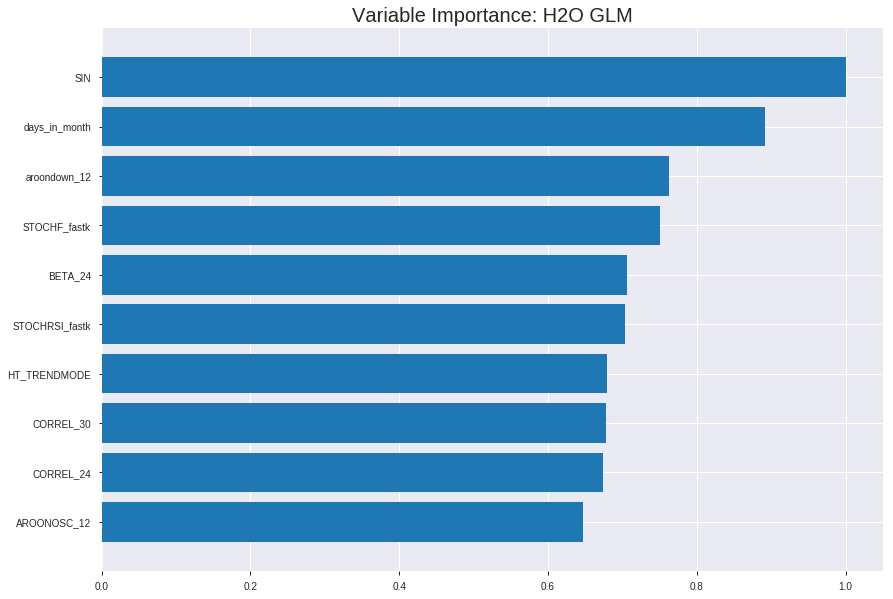

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_015829_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2489052299462491
RMSE: 0.4989040287933633
LogLoss: 0.6909566796854826
Null degrees of freedom: 1351
Residual degrees of freedom: 1301
Null deviance: 1874.1960110626424
Residual deviance: 1868.3468618695451
AIC: 1970.3468618695451
AUC: 0.5633426778801228
pr_auc: 0.552146944793397
Gini: 0.12668535576024564
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4876696762094373: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   623   0.9285   (623.0/671.0)
1      14   667   0.0206   (14.0/681.0)
Total  62   1290  0.4712   (637.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48767      0.676814  357
max f2                       0.480391     0.836619  384
max f0point5                 0.500282     0.578166  238
max accuracy                 0.500282     0.564349  238
max precision                0.525072     0.9       8
max recall                   0.47089      1         397
max specificity              0.531839     0.99851   0
max absolute_mcc             0.500282     0.132339  238
max min_per_class_accuracy   0.503608     0.540984  197
max mean_per_class_accuracy  0.500282     0.563269  238

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010355                    0.5246             1.7017    1.7017             0.857143         0.52653   0.857143                    0.52653             0.0176211       0.0176211                  70.1699    70.1699
    2        0.0207101                   0.523196           0.992658  1.34718            0.5              0.523914  0.678571                    0.525222            0.010279        0.0279001                  -0.734214  34.7179
    3        0.0303254                   0.522108           1.22173   1.3074             0.615385         0.522676  0.658537                    0.524415            0.0117474       0.0396476                  22.1733    30.7403
    4        0.0406805                   0.520828           1.27627   1.29948            0.642857         0.521389  0.654545                    0.523645            0.0132159       0.0528634                  27.6274    29.9479
    5        0.0502959                   0.519654           0.9163    1.22622            0.461538         0.520195  0.617647                    0.522985            0.00881057      0.061674                   -8.37004   22.6224
    6        0.100592                    0.516225           0.992658  1.10944            0.5              0.517993  0.558824                    0.520489            0.0499266       0.111601                   -0.734214  10.9441
    7        0.150148                    0.513826           1.03711   1.08557            0.522388         0.514931  0.546798                    0.518655            0.051395        0.162996                   3.71052    8.55667
    8        0.200444                    0.51173            1.10944   1.09156            0.558824         0.512753  0.549815                    0.517174            0.0558003       0.218796                   10.9441    9.15573
    9        0.300296                    0.508779           1.07354   1.08557            0.540741         0.510148  0.546798                    0.514837            0.107195        0.325991                   7.35411    8.55667
    10       0.400148                    0.50619            1.04413   1.07523            0.525926         0.507418  0.54159                     0.512986            0.104258        0.43025                    4.4129     7.52264
    11       0.5                         0.5036             1.11766   1.0837             0.562963         0.504913  0.545858                    0.511374            0.111601        0.54185                    11.7659    8.37004
    12       0.599852                    0.50132            1.10295   1.08691            0.555556         0.50241   0.547472                    0.509882            0.110132        0.651982                   10.2953    8.69053
    13       0.699704                    0.499046           0.941187  1.06611            0.474074         0.500236  0.536998                    0.508505            0.0939794       0.745962                   -5.88133   6.61103
    14       0.799556                    0.495954           0.911775  1.04684            0.459259         0.497491  0.52729                     0.50713             0.0910426       0.837004                   -8.82254   4.68362
    15       0.899408                    0.491184           0.882363  1.02858            0.444444         0.493906  0.518092                    0.505662            0.0881057       0.92511                    -11.7637   2.85764
    16       1                           0.469058           0.744493  1                  0.375            0.486144  0.503698                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24992514489708134
RMSE: 0.4999251392929559
LogLoss: 0.6929979544217832
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 534.9236366841775
Residual deviance: 534.9944208136167
AIC: 636.9944208136167
AUC: 0.5416397849462365
pr_auc: 0.5459415330135283
Gini: 0.0832795698924731
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45703343041588124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    184  0.9892   (184.0/186.0)
1      1    199  0.005    (1.0/200.0)
Total  3    383  0.4793   (185.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457033     0.682676  382
max f2                       0.445278     0.84317   385
max f0point5                 0.463307     0.576471  374
max accuracy                 0.492936     0.554404  143
max precision                0.516185     0.75      3
max recall                   0.445278     1         385
max specificity              0.51919      0.994624  0
max absolute_mcc             0.492936     0.122095  143
max min_per_class_accuracy   0.489007     0.526882  193
max mean_per_class_accuracy  0.492936     0.559086  143

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.515184           1.4475    1.4475             0.75             0.51758   0.75                        0.51758             0.015           0.015                      44.75     44.75
    2        0.0207254                   0.51328            0.965     1.20625            0.5              0.514165  0.625                       0.515872            0.01            0.025                      -3.5      20.625
    3        0.0310881                   0.512636           0.4825    0.965              0.25             0.5129    0.5                         0.514882            0.005           0.03                       -51.75    -3.5
    4        0.0414508                   0.511647           0         0.72375            0                0.512257  0.375                       0.514225            0               0.03                       -100      -27.625
    5        0.0518135                   0.510936           1.93      0.965              1                0.511325  0.5                         0.513645            0.02            0.05                       93        -3.5
    6        0.101036                    0.504787           1.11737   1.03923            0.578947         0.507742  0.538462                    0.510769            0.055           0.105                      11.7368   3.92308
    7        0.150259                    0.501202           1.11737   1.06483            0.578947         0.503005  0.551724                    0.508226            0.055           0.16                       11.7368   6.48276
    8        0.202073                    0.499498           1.158     1.08872            0.6              0.500223  0.564103                    0.506174            0.06            0.22                       15.8      8.87179
    9        0.300518                    0.496171           1.26974   1.14802            0.657895         0.497851  0.594828                    0.503447            0.125           0.345                      26.9737   14.8017
    10       0.401554                    0.492255           0.989744  1.10819            0.512821         0.493993  0.574194                    0.501068            0.1             0.445                      -1.02564  10.8194
    11       0.5                         0.489056           0.812632  1.05               0.421053         0.490635  0.544041                    0.499014            0.08            0.525                      -18.7368  5
    12       0.601036                    0.486016           1.03923   1.04819            0.538462         0.487442  0.543103                    0.497069            0.105           0.63                       3.92308   4.81897
    13       0.699482                    0.483248           0.914211  1.02933            0.473684         0.4846    0.533333                    0.495314            0.09            0.72                       -8.57895  2.93333
    14       0.800518                    0.479399           0.890769  1.01184            0.461538         0.481347  0.524272                    0.493551            0.09            0.81                       -10.9231  1.18447
    15       0.898964                    0.472844           0.965     1.00671            0.5              0.476628  0.521614                    0.491698            0.095           0.905                      -3.5      0.67147
    16       1                           0.445278           0.940256  1                  0.487179         0.46521   0.518135                    0.489022            0.095       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:58:29  0.000 sec   2            2.4       51            1.38191           1.386
    2019-09-06 01:58:29  0.011 sec   4            1.5       51            1.38007           1.38767
    2019-09-06 01:58:29  0.024 sec   6            0.92      51            1.37775           1.39133
    2019-09-06 01:58:29  0.040 sec   8            0.57      51            1.37501           1.3981
    2019-09-06 01:58:29  0.059 sec   10           0.36      51            1.37197           1.4089

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5721649484536082)

('F1', 0.652014652014652)

('auc', 0.5504049445865302)

('logloss', 0.6911138104753783)

('mean_per_class_error', 0.42391304347826086)

('rmse', 0.49898288422130677)

('mse', 0.24898391874581405)

glm prediction progress: |████████████████████████████████████████████████| 100%


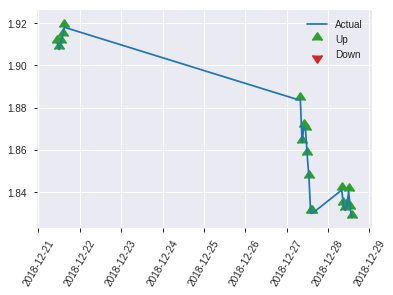


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24898391874581405
RMSE: 0.49898288422130677
LogLoss: 0.6911138104753783
Null degrees of freedom: 193
Residual degrees of freedom: 143
Null deviance: 269.09965128819607
Residual deviance: 268.15215846444676
AIC: 370.15215846444676
AUC: 0.5504049445865302
pr_auc: 0.4903320520325686
Gini: 0.10080988917306044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4756560727927841: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      10   92   0.902    (92.0/102.0)
1      3    89   0.0326   (3.0/92.0)
Total  13   181  0.4897   (95.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475656     0.652015  180
max f2                       0.456256     0.818505  193
max f0point5                 0.488659     0.559701  110
max accuracy                 0.489103     0.572165  106
max precision                0.522382     1         0
max recall                   0.456256     1         193
max specificity              0.522382     1         0
max absolute_mcc             0.488659     0.15358   110
max min_per_class_accuracy   0.489866     0.554348  95
max mean_per_class_accuracy  0.488659     0.576087  110

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.51464            1.05435   1.05435            0.5              0.519035  0.5                         0.519035            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.511044           0         0.527174           0                0.514085  0.25                        0.51656             0               0.0108696                  -100      -47.2826
    3        0.0309278                   0.50922            1.05435   0.702899           0.5              0.51026   0.333333                    0.51446             0.0108696       0.0217391                  5.43478   -29.7101
    4        0.0412371                   0.507356           1.05435   0.790761           0.5              0.50862   0.375                       0.513               0.0108696       0.0326087                  5.43478   -20.9239
    5        0.0515464                   0.506919           0         0.632609           0                0.507002  0.3                         0.5118              0               0.0326087                  -100      -36.7391
    6        0.103093                    0.503092           1.26522   0.948913           0.6              0.504947  0.45                        0.508374            0.0652174       0.0978261                  26.5217   -5.1087
    7        0.149485                    0.501144           1.4058    1.0907             0.666667         0.502043  0.517241                    0.506409            0.0652174       0.163043                   40.5797   9.07046
    8        0.201031                    0.49972            0.843478  1.02731            0.4              0.500586  0.487179                    0.504916            0.0434783       0.206522                   -15.6522  2.73133
    9        0.298969                    0.496767           1.44279   1.16342            0.684211         0.498015  0.551724                    0.502655            0.141304        0.347826                   44.2792   16.3418
    10       0.402062                    0.49326            0.948913  1.10842            0.45             0.495258  0.525641                    0.500758            0.0978261       0.445652                   -5.1087   10.8417
    11       0.5                         0.489789           1.10984   1.1087             0.526316         0.491394  0.525773                    0.498924            0.108696        0.554348                   10.984    10.8696
    12       0.597938                    0.488081           1.10984   1.10888            0.526316         0.489024  0.525862                    0.497303            0.108696        0.663043                   10.984    10.8883
    13       0.701031                    0.48576            0.738043  1.05435            0.35             0.487136  0.5                         0.495808            0.076087        0.73913                    -26.1957  5.43478
    14       0.798969                    0.482938           0.665904  1.00673            0.315789         0.484251  0.477419                    0.494391            0.0652174       0.804348                   -33.4096  0.673212
    15       0.896907                    0.476877           1.10984   1.01799            0.526316         0.480091  0.482759                    0.49283             0.108696        0.913043                   10.984    1.7991
    16       1                           0.456256           0.843478  1                  0.4              0.47151   0.474227                    0.490632     

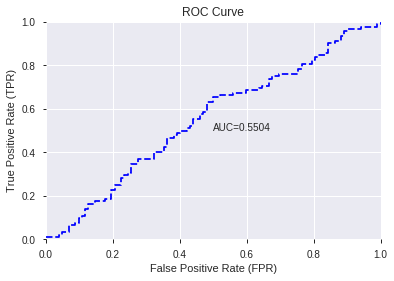

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


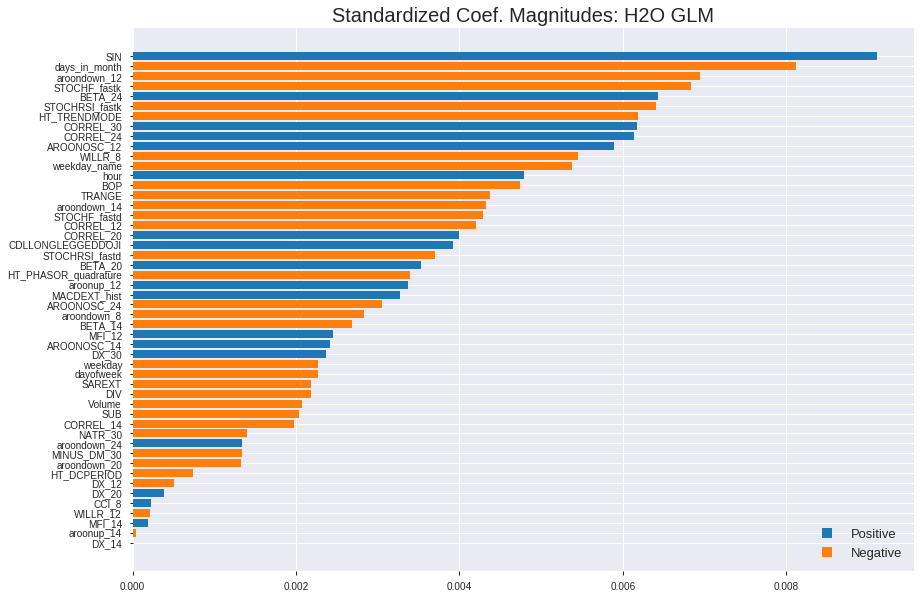

'log_likelihood'
--2019-09-06 01:58:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_015829_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_015829_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SIN',
 'days_in_month',
 'aroondown_12',
 'STOCHF_fastk',
 'BETA_24',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CORREL_30',
 'CORREL_24',
 'AROONOSC_12',
 'WILLR_8',
 'weekday_name',
 'hour',
 'BOP',
 'TRANGE',
 'aroondown_14',
 'STOCHF_fastd',
 'CORREL_12',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastd',
 'BETA_20',
 'HT_PHASOR_quadrature',
 'aroonup_12',
 'MACDEXT_hist',
 'AROONOSC_24',
 'aroondown_8',
 'BETA_14',
 'MFI_12',
 'AROONOSC_14',
 'DX_30',
 'weekday',
 'dayofweek',
 'SAREXT',
 'DIV',
 'Volume',
 'SUB',
 'CORREL_14',
 'NATR_30',
 'aroondown_24',
 'MINUS_DM_30',
 'aroondown_20',
 'HT_DCPERIOD',
 'DX_12',
 'DX_20',
 'CCI_8',
 'WILLR_12',
 'MFI_14',
 'aroonup_14',
 'DX_14']

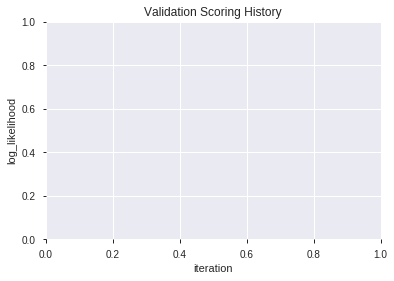

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_015850_model_5  0.523124  0.735041              0.495098  0.517730  0.268044
1  XGBoost_grid_1_AutoML_20190906_015850_model_6  0.523124  0.703843              0.495098  0.504598  0.254619
2  XGBoost_grid_1_AutoML_20190906_015850_model_4  0.520673  0.696277              0.500000  0.501471  0.251473
3  XGBoost_grid_1_AutoML_20190906_015850_model_3  0.495737  0.707759              0.481991  0.506846  0.256893
4  XGBoost_grid_1_AutoML_20190906_015850_model_1  0.488065  0.716470              0.481991  0.510652  0.260766
5               XGBoost_1_AutoML_20190906_015850  0.484015  0.732012              0.500000  0.517192  0.267487
6  XGBoost_grid_1_AutoML_20190906_015850_model_2  0.480286  0.704214              0.495098  0.505349  0.255378
7               XGBoost_3_AutoML_20190906_015850  0.479540  0.713480              0.477089  0.509797  0.259893
8  XGBoost_grid_1_AutoML_20190906_015850_model_7  0.474638  0.734635              0.485827  0.518754  0.269106
9               XGBoost_2_AutoML_20190906_015850  0.425831  0.734853              0.495098  0.519397  0.269773

variable  relative_importance  scaled_importance  percentage
0                 Volume           978.036560           1.000000    0.050242
1                    BOP           957.855225           0.979365    0.049205
2                  CCI_8           676.650818           0.691846    0.034760
3   HT_PHASOR_quadrature           641.538330           0.655945    0.032956
4           STOCHF_fastd           567.776367           0.580527    0.029167
5            HT_DCPERIOD           563.640869           0.576298    0.028954
6                BETA_24           562.780701           0.575419    0.028910
7                WILLR_8           556.135620           0.568625    0.028569
8           STOCHF_fastk           552.841064           0.565256    0.028399
9                  DX_12           549.978638           0.562329    0.028252
10                  hour           526.795044           0.538625    0.027061
11                SAREXT           526.482727           0.538306    0.027045
12               BETA_20           520.326233           0.532011    0.026729
13                MFI_12           509.296356           0.520733    0.026163
14                   SIN           507.270844           0.518662    0.026058
15             CORREL_30           502.757019           0.514047    0.025827
16             CORREL_12           499.761108           0.510984    0.025673
17        STOCHRSI_fastd           479.933655           0.490711    0.024654
18               NATR_30           478.811035           0.489564    0.024597
19                 DX_20           477.577911           0.488303    0.024533
20                   DIV           467.646912           0.478149    0.024023
21                MFI_14           458.616943           0.468916    0.023559
22              WILLR_12           426.513428           0.436091    0.021910
23               BETA_14           414.298035           0.423602    0.021282
24             CORREL_20           398.146179           0.407087    0.020453
25          MACDEXT_hist           397.449707           0.406375    0.020417
26             CORREL_14           357.977631           0.366017    0.018389
27                TRANGE           349.422333           0.357269    0.017950
28        STOCHRSI_fastk           345.765747           0.353530    0.017762
29                 DX_14           345.700562           0.353464    0.017759
30                 DX_30           334.611023           0.342125    0.017189
31           MINUS_DM_30           287.027313           0.293473    0.014745
32                   SUB           286.248413           0.292677    0.014705
33            aroonup_12           260.997467           0.266859    0.013407
34           AROONOSC_12           259.790680           0.265625    0.013345
35             CORREL_24           247.845245           0.253411    0.012732
36           AROONOSC_24           235.020340           0.240298    0.012073
37          aroondown_24           214.461227           0.219277    0.011017
38           aroondown_8           213.479065           0.218273    0.010966
39           AROONOSC_14           208.184891           0.212860    0.010694
40             dayofweek           195.644501           0.200038    0.010050
41          aroondown_20           194.746338           0.199120    0.010004
42          aroondown_12           193.382370           0.197725    0.009934
43            aroonup_14           175.711441           0.179657    0.009026
44          aroondown_14           168.049728           0.171824    0.008633
45          weekday_name           156.803284           0.160325    0.008055
46               weekday           100.158974           0.102408    0.005145
47         days_in_month            79.035072           0.080810    0.004060
48     CDLLONGLEGGEDDOJI            38.797176           0.039668    0.001993
49          HT_TRENDMODE            18.854122           0.019278    0.000969

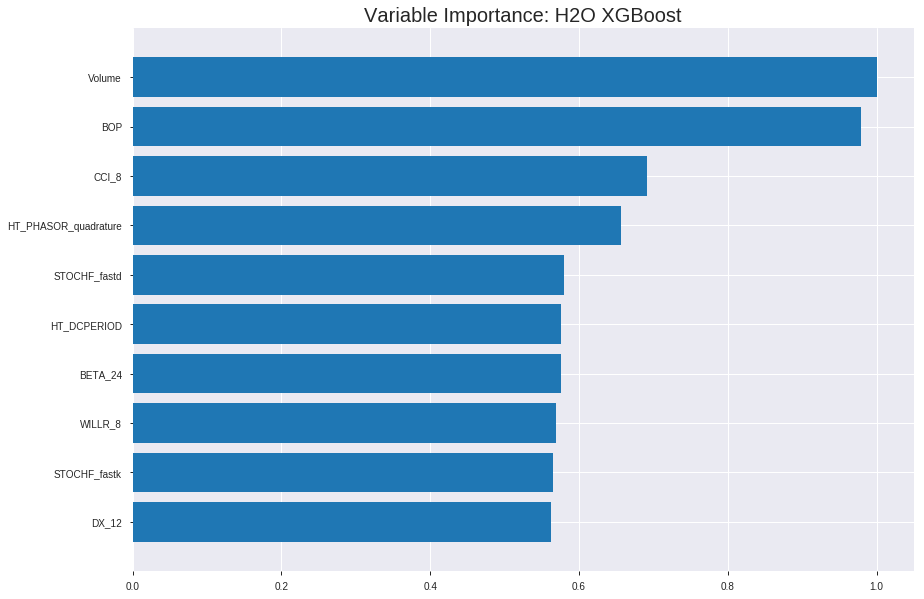

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_015850_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04126913678870129
RMSE: 0.20314806617022296
LogLoss: 0.21935047983850506
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9985315712187959
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5358250141143799: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      671  0    0        (0.0/671.0)
1      0    681  0        (0.0/681.0)
Total  671  681  0        (0.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.535825     1        197
max f2                       0.535825     1        197
max f0point5                 0.535825     1        197
max accuracy                 0.535825     1        197
max precision                0.92158      1        0
max recall                   0.535825     1        197
max specificity              0.92158      1        0
max absolute_mcc             0.535825     1        197
max min_per_class_accuracy   0.535825     1        197
max mean_per_class_accuracy  0.535825     1        197

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010355                    0.901423           1.98532    1.98532            1                0.90913   1                           0.90913             0.020558        0.020558                   98.5316  98.5316
    2        0.0207101                   0.887208           1.98532    1.98532            1                0.893036  1                           0.901083            0.020558        0.041116                   98.5316  98.5316
    3        0.0303254                   0.879201           1.98532    1.98532            1                0.884078  1                           0.895691            0.0190896       0.0602056                  98.5316  98.5316
    4        0.0406805                   0.873651           1.98532    1.98532            1                0.876354  1                           0.890769            0.020558        0.0807636                  98.5316  98.5316
    5        0.0502959                   0.864937           1.98532    1.98532            1                0.868322  1                           0.886477            0.0190896       0.0998532                  98.5316  98.5316
    6        0.100592                    0.850557           1.98532    1.98532            1                0.858122  1                           0.8723              0.0998532       0.199706                   98.5316  98.5316
    7        0.150148                    0.838183           1.98532    1.98532            1                0.84364   1                           0.86284             0.0983847       0.298091                   98.5316  98.5316
    8        0.200444                    0.825545           1.98532    1.98532            1                0.832108  1                           0.855129            0.0998532       0.397944                   98.5316  98.5316
    9        0.300296                    0.801726           1.98532    1.98532            1                0.813054  1                           0.841138            0.198238        0.596182                   98.5316  98.5316
    10       0.400148                    0.762987           1.98532    1.98532            1                0.785367  1                           0.827221            0.198238        0.79442                    98.5316  98.5316
    11       0.5                         0.638999           1.98532    1.98532            1                0.723953  1                           0.806598            0.198238        0.992658                   98.5316  98.5316
    12       0.599852                    0.247924           0.0735302  1.66708            0.037037         0.298871  0.839704                    0.722081            0.00734214      1                          -92.647  66.7078
    13       0.699704                    0.204407           0          1.42918            0                0.224047  0.719873                    0.651009            0               1                          -100     42.9175
    14       0.799556                    0.17099            0          1.25069            0                0.186943  0.629972                    0.593054            0               1                          -100     25.0694
    15       0.899408                    0.145732           0          1.11184            0                0.158042  0.560033                    0.544759            0               1                          -100     11.1842
    16       1                           0.0792666          0          1                  0                0.121494  0.503698                    0.502182        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2613215891092624
RMSE: 0.5111962334654495
LogLoss: 0.718870170277781
Mean Per-Class Error: 0.44908602150537635
AUC: 0.5524462365591397
pr_auc: 0.5633197274079943
Gini: 0.10489247311827943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23000308871269226: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   169  0.9086   (169.0/186.0)
1      6    194  0.03     (6.0/200.0)
Total  23   363  0.4534   (175.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230003     0.689165  362
max f2                       0.170138     0.845309  382
max f0point5                 0.306114     0.589623  320
max accuracy                 0.310578     0.556995  316
max precision                0.795049     1         0
max recall                   0.170138     1         382
max specificity              0.795049     1         0
max absolute_mcc             0.574003     0.130937  69
max min_per_class_accuracy   0.433452     0.516129  193
max mean_per_class_accuracy  0.548375     0.550914  92

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.759681           1.93      1.93               1                0.775377  1                           0.775377            0.02            0.02                       93        93
    2        0.0207254                   0.736201           0         0.965              0                0.753127  0.5                         0.764252            0               0.02                       -100      -3.5
    3        0.0310881                   0.710934           1.4475    1.12583            0.75             0.725003  0.583333                    0.751169            0.015           0.035                      44.75     12.5833
    4        0.0414508                   0.690852           0.965     1.08563            0.5              0.696312  0.5625                      0.737455            0.01            0.045                      -3.5      8.5625
    5        0.0518135                   0.682541           1.4475    1.158              0.75             0.685768  0.6                         0.727117            0.015           0.06                       44.75     15.8
    6        0.101036                    0.632048           1.11737   1.13821            0.578947         0.651805  0.589744                    0.690427            0.055           0.115                      11.7368   13.8205
    7        0.150259                    0.59495            1.42211   1.23121            0.736842         0.612978  0.637931                    0.665056            0.07            0.185                      42.2105   23.1207
    8        0.202073                    0.56265            0.965     1.16295            0.5              0.578221  0.602564                    0.64279             0.05            0.235                      -3.5      16.2949
    9        0.300518                    0.522408           1.01579   1.11474            0.526316         0.541472  0.577586                    0.6096              0.1             0.335                      1.57895   11.4741
    10       0.401554                    0.483228           0.791795  1.03348            0.410256         0.502851  0.535484                    0.582741            0.08            0.415                      -20.8205  3.34839
    11       0.5                         0.433573           1.01579   1.03               0.526316         0.455628  0.533679                    0.557713            0.1             0.515                      1.57895   3
    12       0.601036                    0.399855           1.23718   1.06483            0.641026         0.414865  0.551724                    0.5337              0.125           0.64                       23.7179   6.48276
    13       0.699482                    0.358735           0.914211  1.04363            0.473684         0.381171  0.540741                    0.512233            0.09            0.73                       -8.57895  4.36296
    14       0.800518                    0.322683           1.03923   1.04307            0.538462         0.340951  0.540453                    0.490615            0.105           0.835                      3.92308   4.30744
    15       0.898964                    0.264174           0.812632  1.01784            0.421053         0.294602  0.527378                    0.469149            0.08            0.915                      -18.7368  1.78386
    16       1                           0.148483           0.841282  1                  0.435897         0.215924  0.518135                    0.443565            0.085          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:58:55  2.239 sec   0                  0.5              0.693147            0.5             0                  1                0.496302                         0.5                0.693147              0.5               0                    1                  0.481865
    2019-09-06 01:58:55  2.458 sec   5                  0.449497         0.596466            0.967002        0.968899           1.98532          0.089497                         0.500662           0.694521              0.52121           0.520988             0.4825             0.481865
    2019-09-06 01:58:56  2.639 sec   10                 0.409073         0.524716            0.993094        0.990072           1.98532          0.0392012                        0.498516           0.690215              0.554839          0.560266             0.4825             0.474093
    2019-09-06 01:58:56  2.826 sec   15                 0.371292         0.461497            0.998419        0.996836           1.98532          0.0140533                        0.50137            0.696127              0.54129           0.537147             0.4825             0.463731
    2019-09-06 01:58:56  3.019 sec   20                 0.340495         0.412659            0.999834        0.998371           1.98532          0.00517751                       0.502325           0.698132              0.541237          0.547471             1.4475             0.474093
    2019-09-06 01:58:56  3.236 sec   25                 0.309038         0.364938            0.999993        0.998525           1.98532          0.000739645                      0.503204           0.699953              0.541667          0.551943             1.4475             0.466321
    2019-09-06 01:58:56  3.428 sec   30                 0.283412         0.327647            0.999996        0.998527           1.98532          0.000739645                      0.505867           0.705771              0.538629          0.557513             1.93               0.468912
    2019-09-06 01:58:57  3.648 sec   35                 0.258721         0.293129            0.999996        0.997059           1.98532          0.000739645                      0.505654           0.705648              0.551962          0.566407             1.4475             0.471503
    2019-09-06 01:58:57  3.879 sec   40                 0.239652         0.267056            1               0.997063           1.98532          0                                0.507262           0.709261              0.547419          0.563563             1.4475             0.463731
    2019-09-06 01:58:57  4.119 sec   45                 0.219831         0.240858            1               0.998532           1.98532          0                                0.509538           0.714862              0.548978          0.565636             1.4475             0.466321
    2019-09-06 01:58:57  4.346 sec   50                 0.203148         0.21935             1               0.998532           1.98532          0                                0.511196           0.71887               0.552446          0.56332              1.93               0.453368

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
Volume                978.0365600585938      1.0                   0.050241692885163225
BOP                   957.855224609375       0.9793654590499054    0.04920497861592225
CCI_8                 676.6508178710938      0.6918461389935728    0.03475952123910104
HT_PHASOR_quadrature  641.538330078125       0.6559451418050167    0.03295579436408249
STOCHF_fastd          567.7763671875         0.5805267311822012    0.02916664573968386
---                   ---                    ---                   ---
weekday_name          156.80328369140625     0.16032456259305095   0.008054977435748194
weekday               100.15897369384766     0.10240821026961117   0.005145161849285023
days_in_month         79.03507232666016      0.08080993651395323   0.004060028012403576
CDLLONGLEGGEDDOJI     38.797176361083984     0.03966843157556366   0.001993009156455581
HT_TRENDMODE          18.854122161865234     0.019277522877811124  0.0009685353840136944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515463917525774)

('F1', 0.6456140350877193)

('auc', 0.5231244671781756)

('logloss', 0.7350412264114482)

('mean_per_class_error', 0.4603580562659846)

('rmse', 0.5177297664265154)

('mse', 0.2680441110440541)

xgboost prediction progress: |████████████████████████████████████████████| 100%


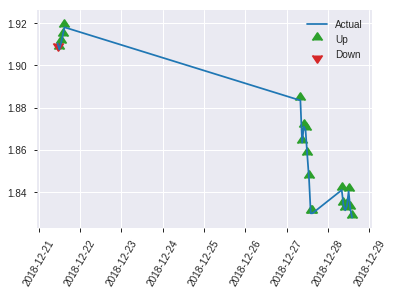


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2680441110440541
RMSE: 0.5177297664265154
LogLoss: 0.7350412264114482
Mean Per-Class Error: 0.4603580562659846
AUC: 0.5231244671781756
pr_auc: 0.5039368301576573
Gini: 0.046248934356351246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14953945577144623: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    101  0.9902   (101.0/102.0)
1      0    92   0        (0.0/92.0)
Total  1    193  0.5206   (101.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.149539     0.645614  192
max f2                       0.149539     0.819964  192
max f0point5                 0.257535     0.543194  167
max accuracy                 0.739004     0.551546  6
max precision                0.739004     0.857143  6
max recall                   0.149539     1         192
max specificity              0.786259     0.990196  0
max absolute_mcc             0.739004     0.148368  6
max min_per_class_accuracy   0.426232     0.529412  96
max mean_per_class_accuracy  0.39708      0.539642  109

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 43.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.762488           1.05435   1.05435            0.5              0.780195  0.5                         0.780195            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.749374           2.1087    1.58152            1                0.760535  0.75                        0.770365            0.0217391       0.0326087                  110.87    58.1522
    3        0.0309278                   0.740354           2.1087    1.75725            1                0.746583  0.833333                    0.762437            0.0217391       0.0543478                  110.87    75.7246
    4        0.0412371                   0.72774            1.05435   1.58152            0.5              0.733779  0.75                        0.755273            0.0108696       0.0652174                  5.43478   58.1522
    5        0.0515464                   0.703459           0         1.26522            0                0.715918  0.6                         0.747402            0               0.0652174                  -100      26.5217
    6        0.103093                    0.651533           1.05435   1.15978            0.5              0.675915  0.55                        0.711658            0.0543478       0.119565                   5.43478   15.9783
    7        0.149485                    0.603844           0.468599  0.945277           0.222222         0.62324   0.448276                    0.684218            0.0217391       0.141304                   -53.1401  -5.47226
    8        0.201031                    0.572654           1.05435   0.973244           0.5              0.585479  0.461538                    0.6589              0.0543478       0.195652                   5.43478   -2.67559
    9        0.298969                    0.516512           1.10984   1.01799            0.526316         0.542835  0.482759                    0.620879            0.108696        0.304348                   10.984    1.7991
    10       0.402062                    0.452428           1.15978   1.05435            0.55             0.489303  0.5                         0.587141            0.119565        0.423913                   15.9783   5.43478
    11       0.5                         0.426005           1.10984   1.06522            0.526316         0.440565  0.505155                    0.558431            0.108696        0.532609                   10.984    6.52174
    12       0.597938                    0.374318           0.887872  1.03617            0.421053         0.400462  0.491379                    0.532557            0.0869565       0.619565                   -11.2128  3.61694
    13       0.701031                    0.335902           0.843478  1.00783            0.4              0.353944  0.477941                    0.50629             0.0869565       0.706522                   -15.6522  0.783248
    14       0.798969                    0.28847            1.22082   1.03394            0.578947         0.314406  0.490323                    0.482769            0.119565        0.826087                   22.0824   3.39411
    15       0.896907                    0.228065           0.776888  1.00587            0.368421         0.264056  0.477011                    0.458886            0.076087        0.902174                   -22.3112  0.587206
    16       1                           0.125598           0.948913  1                  0.45             0.187707  0.474227                    0.43093       

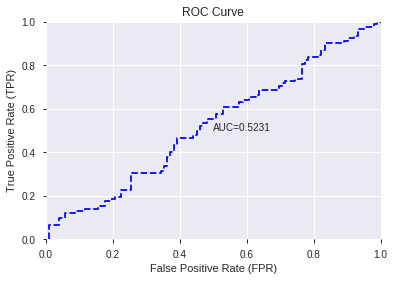

This function is available for GLM models only


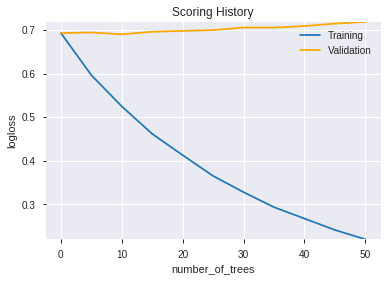

--2019-09-06 01:59:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_015850_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_015850_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'BOP',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'STOCHF_fastd',
 'HT_DCPERIOD',
 'BETA_24',
 'WILLR_8',
 'STOCHF_fastk',
 'DX_12',
 'hour',
 'SAREXT',
 'BETA_20',
 'MFI_12',
 'SIN',
 'CORREL_30',
 'CORREL_12',
 'STOCHRSI_fastd',
 'NATR_30',
 'DX_20',
 'DIV',
 'MFI_14',
 'WILLR_12',
 'BETA_14',
 'CORREL_20',
 'MACDEXT_hist',
 'CORREL_14',
 'TRANGE',
 'STOCHRSI_fastk',
 'DX_14',
 'DX_30',
 'MINUS_DM_30',
 'SUB',
 'aroonup_12',
 'AROONOSC_12',
 'CORREL_24',
 'AROONOSC_24',
 'aroondown_24',
 'aroondown_8',
 'AROONOSC_14',
 'dayofweek',
 'aroondown_20',
 'aroondown_12',
 'aroonup_14',
 'aroondown_14',
 'weekday_name',
 'weekday',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 895 904 917 919 926 994 998] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_015922_model_5  0.500000  0.692682              0.500000  0.499767  0.249767
1  DeepLearning_grid_1_AutoML_20190906_015922_model_6  0.500000  0.699981              0.500000  0.503397  0.253409
2  DeepLearning_grid_1_AutoML_20190906_015922_model_7  0.500000  0.698906              0.500000  0.502866  0.252874
3  DeepLearning_grid_1_AutoML_20190906_015922_model_8  0.500000  0.694060              0.500000  0.500456  0.250456
4               DeepLearning_1_AutoML_20190906_015922  0.482204  3.722270              0.500000  0.688039  0.473397
5  DeepLearning_grid_1_AutoML_20190906_015922_model_9  0.475703  0.693779              0.495098  0.500316  0.250316
6  DeepLearning_grid_1_AutoML_20190906_015922_model_4  0.465580  1.333154              0.490729  0.628181  0.394611
7  DeepLearning_grid_1_AutoML_20190906_015922_model_2  0.461317  1.398310              0.495098  0.635056  0.403297
8  DeepLearning_grid_1_AutoML_20190906_015922_model_3  0.458120  1.359268              0.500000  0.633373  0.401161
9  DeepLearning_grid_1_AutoML_20190906_015922_model_1  0.419650  2.222687              0.470588  0.688725  0.474342

variable  relative_importance  scaled_importance  percentage
0         HT_PHASOR_quadrature             1.000000           1.000000    0.002108
1                 aroondown_20             0.992855           0.992855    0.002093
2                 HT_TRENDMODE             0.958231           0.958231    0.002020
3                         hour             0.904949           0.904949    0.001908
4               STOCHRSI_fastk             0.880189           0.880189    0.001855
...                        ...                  ...                ...         ...
1027  BBANDS_middleband_30_5_2             0.372513           0.372513    0.000785
1028  BBANDS_middleband_24_2_4             0.371908           0.371908    0.000784
1029                    MA_8_1             0.371815           0.371815    0.000784
1030                   MA_14_5             0.364699           0.364699    0.000769
1031                       TAN             0.361763           0.361763    0.000763

[1032 rows x 4 columns]

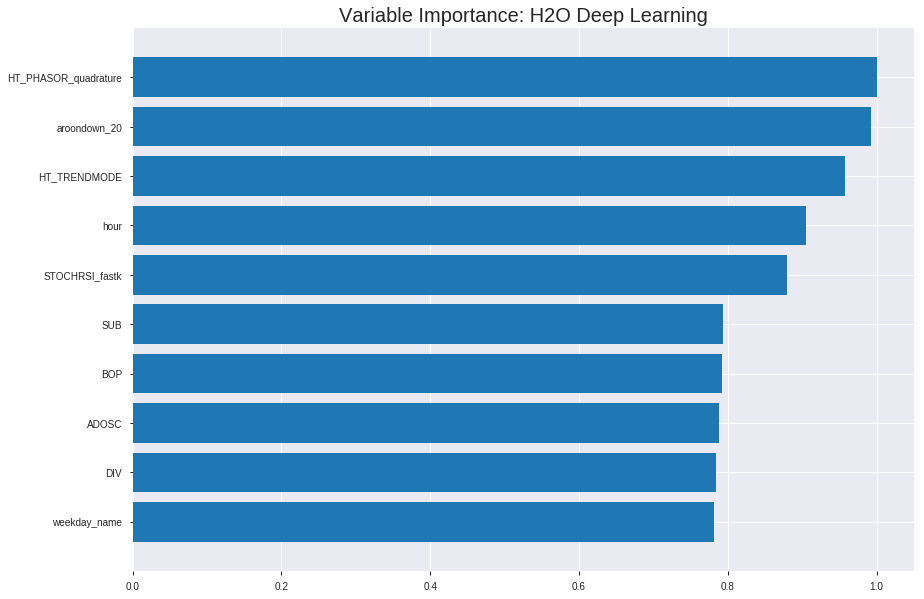

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_015922_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22577154263891114
RMSE: 0.47515423037042526
LogLoss: 0.632894483748135
Mean Per-Class Error: 0.4333943902081405
AUC: 0.6189405428590812
pr_auc: 0.6863409558356036
Gini: 0.23788108571816236
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4792991632631098: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      103  568   0.8465   (568.0/671.0)
1      20   661   0.0294   (20.0/681.0)
Total  123  1229  0.4349   (588.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479299     0.692147  217
max f2                       0.3178       0.848281  278
max f0point5                 0.491541     0.59077   210
max accuracy                 0.492275     0.565828  208
max precision                0.999621     1         0
max recall                   0.3178       1         278
max specificity              0.999621     1         0
max absolute_mcc             0.663321     0.246619  99
max min_per_class_accuracy   0.495092     0.218796  206
max mean_per_class_accuracy  0.575569     0.566606  128

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010355                    0.99188            1.98532   1.98532            1                0.996271  1                           0.996271            0.020558        0.020558                   98.5316    98.5316
    2        0.0207101                   0.977101           1.98532   1.98532            1                0.985246  1                           0.990758            0.020558        0.041116                   98.5316    98.5316
    3        0.0303254                   0.947783           1.98532   1.98532            1                0.963334  1                           0.982063            0.0190896       0.0602056                  98.5316    98.5316
    4        0.0406805                   0.902211           1.98532   1.98532            1                0.923969  1                           0.967275            0.020558        0.0807636                  98.5316    98.5316
    5        0.0502959                   0.817665           1.67988   1.92692            0.846154         0.856347  0.970588                    0.946068            0.0161527       0.0969163                  67.9883    92.6924
    6        0.100592                    0.568367           1.34301   1.63497            0.676471         0.671455  0.823529                    0.808762            0.0675477       0.164464                   34.3008    63.4966
    7        0.150148                    0.497978           1.00747   1.42786            0.507463         0.526387  0.719212                    0.715564            0.0499266       0.214391                   0.747364   42.7863
    8        0.901627                    0.495005           0.996566  1.06839            0.501969         0.495009  0.538146                    0.531738            0.748899        0.963289                   -0.343404  6.83898
    9        1                           0.000399108        0.37318   1                  0.18797          0.286961  0.503698                    0.507659            0.0367107       1                          -62.682    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2502061375555712
RMSE: 0.500206095080389
LogLoss: 0.6935594702199037
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4950045303175502: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    186  1        (186.0/186.0)
1      0    200  0        (0.0/200.0)
Total  0    386  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495005     0.682594  0
max f2                       0.495005     0.84317   0
max f0point5                 0.495005     0.573394  0
max accuracy                 0.495005     0.518135  0
max precision                0.495005     0.518135  0
max recall                   0.495005     1         0
max specificity              0.495005     0         0
max absolute_mcc             0.495005     0         0
max min_per_class_accuracy   0.495005     0         0
max mean_per_class_accuracy  0.495005     0.5       0

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.495005           1       1                  0.518135         0.495005  0.518135                    0.495005            1               1                          0       0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:09:50  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:09:52  5 min 20.209 sec  373 obs/sec       0.47929   1             648        0.651293         3.14162             -0.696823      0.506695        0.505838           1.13447          0.496302                         0.719816           13.1315               -1.07527         0.526425          0.550614             1.4475             0.471503
    2019-09-06 02:10:15  5 min 43.662 sec  375 obs/sec       6.34393   13            8577       0.50131          0.69589             -0.00530374    0.518971        0.529058           1.55989          0.491124                         0.506079           0.705543              -0.0258146       0.522325          0.461922             1.18432            0.476684
    2019-09-06 02:10:39  6 min  7.255 sec  425 obs/sec       13.8735   28            18757      0.497737         0.687799            0.0089786      0.54971         0.591482           1.98532          0.486686                         0.51997            0.736415              -0.0828983       0.443481          0.297831             0.90756            0.479275
    2019-09-06 02:11:02  6 min 31.122 sec  486 obs/sec       23.642    48            31964      0.491951         0.675177            0.0318846      0.576184        0.621998           1.98532          0.460059                         0.502962           0.699104              -0.0132162       0.5               0                    1                  0.481865
    2019-09-06 02:11:26  6 min 54.844 sec  547 obs/sec       35.2885   72            47710      0.481887         0.651808            0.0710883      0.608553        0.705681           1.98532          0.443047                         0.500604           0.694357              -0.00373887      0.5               0                    1                  0.481865
    2019-09-06 02:11:50  7 min 18.113 sec  592 obs/sec       47.3905   97            64072      0.475154         0.632894            0.0968644      0.618941        0.686341           1.98532          0.434911                         0.500206           0.693559              -0.00214284      0.5               0                    1                  0.481865
    2019-09-06 02:12:13  7 min 41.569 sec  622 obs/sec       59.5141   122           80463      0.468741         0.616074            0.121078       0.650026        0.754593           1.98532          0.423817                         0.503243           0.699673              -0.0143466       0.5               0                    1                  0.481865
    2019-09-06 02:12:15  7 min 43.901 sec  622 obs/sec       59.5141   122           80463      0.475154         0.632894            0.0968644      0.618941        0.686341           1.98532          0.434911                         0.500206           0.693559              -0.00214284      0.5               0                    1                  0.481865

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_PHASOR_quadrature      1.0                    1.0                  0.0021080315154735833
aroondown_20              0.9928551316261292     0.9928551316261292   0.002092969907767553
HT_TRENDMODE              0.9582310914993286     0.9582310914993286   0.0020199813399872355
hour                      0.9049490094184875     0.9049490094184875   0.0019076610317507723
STOCHRSI_fastk            0.8801893591880798     0.8801893591880798   0.00185546690875297
---                       ---                    ---                  ---
BBANDS_middleband_30_5_2  0.37251293659210205    0.37251293659210205  0.0007852690102577637
BBANDS_middleband_24_2_4  0.37190762162208557    0.37190762162208557  0.000783992987224181
MA_8_1                    0.3718154728412628     0.3718154728412628   0.0007837987346900942
MA_14_5                   0.3646993637084961     0.3646993637084961   0.0007687977523706726
TAN                       0.3617631494998932     0.3617631494998932   0.0007626081202827563


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4742268041237113)

('F1', 0.6433566433566433)

('auc', 0.5)

('logloss', 0.6926820784747836)

('mean_per_class_error', 0.5)

('rmse', 0.49976740217836174)

('mse', 0.24976745628010838)

deeplearning prediction progress: |███████████████████████████████████████| 100%


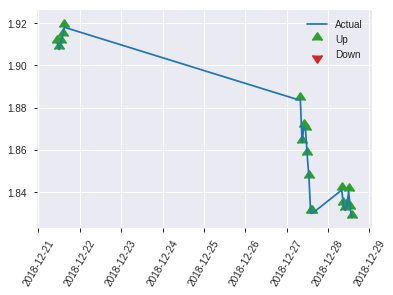


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24976745628010838
RMSE: 0.49976740217836174
LogLoss: 0.6926820784747836
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4950045303175503: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495005     0.643357  0
max f2                       0.495005     0.818505  0
max f0point5                 0.495005     0.529954  0
max accuracy                 0.495005     0.474227  0
max precision                0.495005     0.474227  0
max recall                   0.495005     1         0
max specificity              0.495005     0         0
max absolute_mcc             0.495005     0         0
max min_per_class_accuracy   0.495005     0         0
max mean_per_class_accuracy  0.495005     0.5       0

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.495005           1       1                  0.474227         0.495005  0.474227                    0.495005            1               1                          0       0

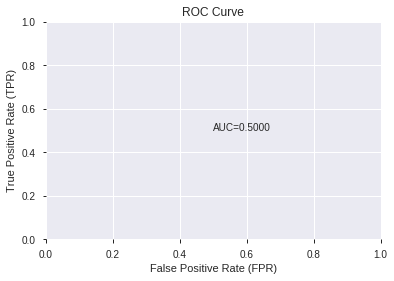

This function is available for GLM models only


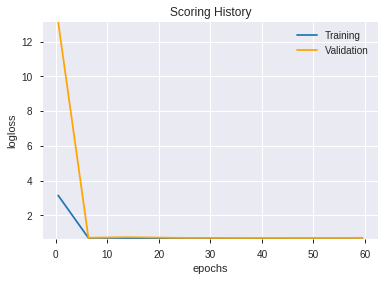

--2019-09-06 02:29:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_015922_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_015922_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_PHASOR_quadrature',
 'aroondown_20',
 'HT_TRENDMODE',
 'hour',
 'STOCHRSI_fastk',
 'SUB',
 'BOP',
 'ADOSC',
 'DIV',
 'weekday_name',
 'STOCHRSI_fastd',
 'aroondown_8',
 'TRANGE',
 'HT_PHASOR_inphase',
 'AROONOSC_24',
 'BETA_8',
 'aroonup_12',
 'ULTOSC',
 'WILLR_8',
 'aroondown_24',
 'CCI_8',
 'day',
 'weekday',
 'AROONOSC_8',
 'AROONOSC_12',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'MFI_14',
 'DX_8',
 'DX_12',
 'days_in_month',
 'BETA_20',
 'BETA_14',
 'aroonup_8',
 'AROONOSC_20',
 'CORREL_12',
 'DX_14',
 'CDLDOJI',
 'dayofweek',
 'aroonup_24',
 'aroonup_14',
 'Volume',
 'aroondown_12',
 'MFI_8',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'BETA_30',
 'CDLSPINNINGTOP',
 'STOCH_slowd',
 'SAREXT',
 'CORREL_14',
 'MFI_30',
 'MFI_24',
 'CDLLONGLINE',
 'HT_DCPERIOD',
 'CDLHARAMI',
 'BETA_12',
 'MFI_12',
 'CDLENGULFING',
 'MACDFIX_hist_20',
 'DX_24',
 'aroonup_30',
 'DX_20',
 'MACDFIX_signal_24',
 'CDLHANGINGMAN',
 'aroondown_30',
 'BETA_24',
 'ROC_24',
 'STOCH_slowk',
 'MACDFIX_hist_24',
 'WILLR_24

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_022934_model_1  0.470588  0.69566                   0.5  0.501253  0.251254

variable  relative_importance  scaled_importance    percentage
0          CDLGAPSIDESIDEWHITE         9.028822e-03           1.000000  1.239938e-02
1               is_month_start         8.044989e-03           0.891034  1.104827e-02
2                          SIN         7.975710e-03           0.883361  1.095313e-02
3                CDLHIKKAKEMOD         7.925362e-03           0.877785  1.088399e-02
4           CDLMORNINGDOJISTAR         7.840823e-03           0.868421  1.076789e-02
...                        ...                  ...                ...           ...
1027                 dayofyear         1.905889e-07           0.000021  2.617378e-07
1028  BBANDS_middleband_20_0_2         0.000000e+00           0.000000  0.000000e+00
1029  BBANDS_middleband_20_0_3         0.000000e+00           0.000000  0.000000e+00
1030  BBANDS_middleband_20_0_4         0.000000e+00           0.000000  0.000000e+00
1031  BBANDS_middleband_20_0_5         0.000000e+00           0.000000  0.000000e+00

[1032 rows x 4 columns]

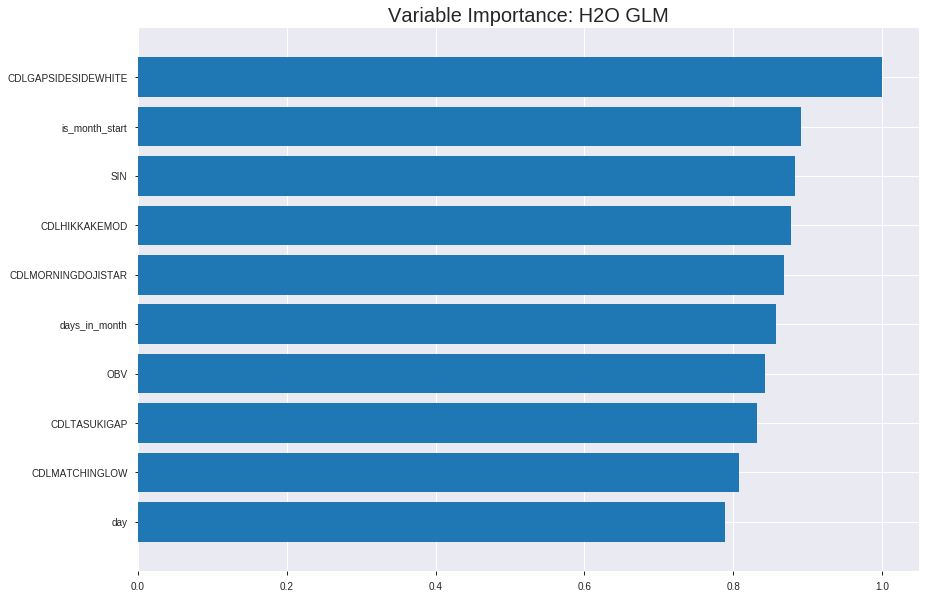

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_022934_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24659603663806876
RMSE: 0.4965843701105269
LogLoss: 0.6863275354192105
Null degrees of freedom: 1351
Residual degrees of freedom: 323
Null deviance: 1874.1960110626424
Residual deviance: 1855.8296557735453
AIC: 3913.8296557735453
AUC: 0.6160726204779068
pr_auc: 0.6114193280459685
Gini: 0.23214524095581357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48695033291385004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      139  532   0.7928   (532.0/671.0)
1      58   623   0.0852   (58.0/681.0)
Total  197  1155  0.4364   (590.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48695      0.678649  312
max f2                       0.460546     0.837226  391
max f0point5                 0.498181     0.595035  239
max accuracy                 0.498181     0.585799  239
max precision                0.588545     1         0
max recall                   0.460546     1         391
max specificity              0.588545     1         0
max absolute_mcc             0.490738     0.182923  291
max min_per_class_accuracy   0.503981     0.571219  200
max mean_per_class_accuracy  0.498181     0.584813  239

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.545624           1.84351   1.84351            0.928571         0.556412  0.928571                    0.556412            0.0190896       0.0190896                  84.3507     84.3507
    2        0.0207101                   0.538588           1.27627   1.55989            0.642857         0.541244  0.785714                    0.548828            0.0132159       0.0323054                  27.6274     55.9891
    3        0.0303254                   0.535986           1.37445   1.50109            0.692308         0.537601  0.756098                    0.545268            0.0132159       0.0455213                  37.4449     50.1092
    4        0.0406805                   0.532787           1.84351   1.58825            0.928571         0.534717  0.8                         0.542583            0.0190896       0.0646109                  84.3507     58.8253
    5        0.0502959                   0.530841           0.763583  1.4306             0.384615         0.531639  0.720588                    0.54049             0.00734214      0.071953                   -23.6417    43.0595
    6        0.100592                    0.524472           1.25542   1.34301            0.632353         0.527607  0.676471                    0.534049            0.0631424       0.135095                   25.542      34.3008
    7        0.150148                    0.519969           1.27416   1.32028            0.641791         0.522101  0.665025                    0.530105            0.0631424       0.198238                   27.4158     32.0284
    8        0.200444                    0.516965           1.28462   1.31133            0.647059         0.518351  0.660517                    0.527156            0.0646109       0.262849                   28.4616     31.1334
    9        0.300296                    0.512134           1.05884   1.22737            0.533333         0.514218  0.618227                    0.522854            0.105727        0.368576                   5.8835      22.7375
    10       0.400148                    0.507578           1.02942   1.17798            0.518519         0.509903  0.593346                    0.519622            0.10279         0.471366                   2.9423      17.7978
    11       0.5                         0.503852           1.01472   1.14537            0.511111         0.505663  0.576923                    0.516835            0.101322        0.572687                   1.47169     14.5374
    12       0.599852                    0.499606           1.00001   1.12118            0.503704         0.501829  0.564735                    0.514337            0.0998532       0.67254                    0.00108773  12.1177
    13       0.699704                    0.495166           0.955893  1.09759            0.481481         0.497485  0.552854                    0.511932            0.0954479       0.767988                   -4.41072    9.759
    14       0.799556                    0.490448           1.04413   1.09091            0.525926         0.493043  0.549491                    0.509573            0.104258        0.872247                   4.4129      9.09135
    15       0.899408                    0.48285            0.661772  1.04327            0.333333         0.487047  0.525493                    0.507072            0.0660793       0.938326                   -33.8228    4.32703
    16       1                           0.426735           0.613112  1                  0.308824         0.473531  0.503698     



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249818107367733
RMSE: 0.499818074270762
LogLoss: 0.6927826378399817
Null degrees of freedom: 385
Residual degrees of freedom: -643
Null deviance: 534.9236366841775
Residual deviance: 534.8281964124659
AIC: 2592.828196412466
AUC: 0.5366397849462365
pr_auc: 0.5522256922402488
Gini: 0.07327956989247308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4408588841951551: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    181  0.9731   (181.0/186.0)
1      1    199  0.005    (1.0/200.0)
Total  6    380  0.4715   (182.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440859     0.686207   379
max f2                       0.434602     0.845309   382
max f0point5                 0.450436     0.578979   370
max accuracy                 0.477776     0.549223   257
max precision                0.540177     1          0
max recall                   0.434602     1          382
max specificity              0.540177     1          0
max absolute_mcc             0.526359     0.0986824  3
max min_per_class_accuracy   0.486619     0.54       192
max mean_per_class_accuracy  0.485776     0.545941   200

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.525971           1.93      1.93               1                0.530849  1                           0.530849            0.02            0.02                       93        93
    2        0.0207254                   0.524813           0.965     1.4475             0.5              0.525636  0.75                        0.528242            0.01            0.03                       -3.5      44.75
    3        0.0310881                   0.522283           0.4825    1.12583            0.25             0.52444   0.583333                    0.526975            0.005           0.035                      -51.75    12.5833
    4        0.0414508                   0.5198             1.4475    1.20625            0.75             0.520128  0.625                       0.525263            0.015           0.05                       44.75     20.625
    5        0.0518135                   0.519463           0.965     1.158              0.5              0.519587  0.6                         0.524128            0.01            0.06                       -3.5      15.8
    6        0.101036                    0.512896           0.914211  1.03923            0.473684         0.515408  0.538462                    0.51988             0.045           0.105                      -8.57895  3.92308
    7        0.150259                    0.507065           1.21895   1.0981             0.631579         0.510159  0.568966                    0.516695            0.06            0.165                      21.8947   9.81034
    8        0.202073                    0.50337            1.0615    1.08872            0.55             0.505398  0.564103                    0.513799            0.055           0.22                       6.15      8.87179
    9        0.300518                    0.497153           1.01579   1.06483            0.526316         0.500002  0.551724                    0.509279            0.1             0.32                       1.57895   6.48276
    10       0.401554                    0.492573           1.03923   1.05839            0.538462         0.494795  0.548387                    0.505634            0.105           0.425                      3.92308   5.83871
    11       0.5                         0.486577           1.16816   1.08               0.605263         0.489031  0.559585                    0.502365            0.115           0.54                       16.8158   8
    12       0.601036                    0.481772           0.890769  1.04819            0.461538         0.48434   0.543103                    0.499335            0.09            0.63                       -10.9231  4.81897
    13       0.699482                    0.475989           0.914211  1.02933            0.473684         0.479005  0.533333                    0.496474            0.09            0.72                       -8.57895  2.93333
    14       0.800518                    0.469008           0.841282  1.0056             0.435897         0.472304  0.521036                    0.493423            0.085           0.805                      -15.8718  0.559871
    15       0.898964                    0.460432           1.01579   1.00671            0.526316         0.464653  0.521614                    0.490273            0.1             0.905                      1.57895   0.67147
    16       1                           0.432933           0.940256  1                  0.487179         0.449763  0.518135                    0.48618             0.095        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:29:37  0.000 sec   2            2.7       1029          1.37266           1.38557
    2019-09-06 02:29:39  1.658 sec   4            2         1032          1.36885           1.38632
    2019-09-06 02:29:40  3.170 sec   6            1.4       1033          1.36439           1.38838
    2019-09-06 02:29:42  4.718 sec   8            1.1       1033          1.35927           1.39202
    2019-09-06 02:29:43  6.301 sec   10           0.77      1033          1.3535            1.39751
    2019-09-06 02:29:45  7.942 sec   12           0.56      1033          1.34718           1.40568

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5412371134020618)

('F1', 0.6433566433566433)

('auc', 0.47058823529411764)

('logloss', 0.695659675590916)

('mean_per_class_error', 0.4639812446717818)

('rmse', 0.5012526893055765)

('mse', 0.25125425853607286)

glm prediction progress: |████████████████████████████████████████████████| 100%


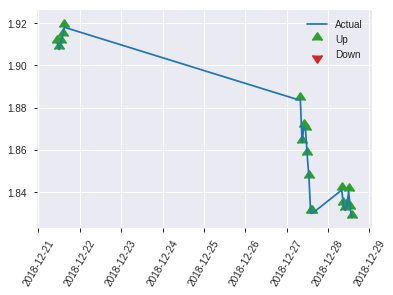


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25125425853607286
RMSE: 0.5012526893055765
LogLoss: 0.695659675590916
Null degrees of freedom: 193
Residual degrees of freedom: -835
Null deviance: 269.09965128819607
Residual deviance: 269.9159541292754
AIC: 2327.9159541292756
AUC: 0.47058823529411764
pr_auc: 0.42983433677384497
Gini: -0.05882352941176472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43208605871150185: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432086     0.643357  193
max f2                       0.432086     0.818505  193
max f0point5                 0.457529     0.533175  187
max accuracy                 0.491024     0.541237  72
max precision                0.550346     1         0
max recall                   0.432086     1         193
max specificity              0.550346     1         0
max absolute_mcc             0.513807     0.208741  18
max min_per_class_accuracy   0.485685     0.478261  96
max mean_per_class_accuracy  0.490102     0.536019  76

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 48.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.532655           1.05435   1.05435            0.5              0.542882  0.5                         0.542882            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.528079           0         0.527174           0                0.530312  0.25                        0.536597            0               0.0108696                  -100      -47.2826
    3        0.0309278                   0.520888           0         0.351449           0                0.526416  0.166667                    0.533203            0               0.0108696                  -100      -64.8551
    4        0.0412371                   0.519256           0         0.263587           0                0.519602  0.125                       0.529803            0               0.0108696                  -100      -73.6413
    5        0.0515464                   0.517417           1.05435   0.421739           0.5              0.518602  0.2                         0.527563            0.0108696       0.0217391                  5.43478   -57.8261
    6        0.103093                    0.513683           0.421739  0.421739           0.2              0.515111  0.2                         0.521337            0.0217391       0.0434783                  -57.8261  -57.8261
    7        0.149485                    0.506279           0.937198  0.581709           0.444444         0.509687  0.275862                    0.517722            0.0434783       0.0869565                  -6.28019  -41.8291
    8        0.201031                    0.50053            1.05435   0.702899           0.5              0.503151  0.333333                    0.513986            0.0543478       0.141304                   5.43478   -29.7101
    9        0.298969                    0.493966           1.44279   0.945277           0.684211         0.497659  0.448276                    0.508637            0.141304        0.282609                   44.2792   -5.47226
    10       0.402062                    0.489994           1.47609   1.08138            0.7              0.491806  0.512821                    0.504321            0.152174        0.434783                   47.6087   8.13824
    11       0.5                         0.485682           0.443936  0.956522           0.210526         0.487562  0.453608                    0.501039            0.0434783       0.478261                   -55.6064  -4.34783
    12       0.597938                    0.481222           1.22082   0.999813           0.578947         0.483332  0.474138                    0.498138            0.119565        0.597826                   22.0824   -0.0187406
    13       0.701031                    0.477841           0.948913  0.992327           0.45             0.479669  0.470588                    0.495422            0.0978261       0.695652                   -5.1087   -0.767263
    14       0.798969                    0.472593           0.887872  0.979523           0.421053         0.475721  0.464516                    0.493007            0.0869565       0.782609                   -11.2128  -2.04769
    15       0.896907                    0.464336           1.10984   0.993753           0.526316         0.46919   0.471264                    0.490407            0.108696        0.891304                   10.984    -0.624688
    16       1                           0.432086           1.05435   1                  0.5              0.457022  0.474227                    

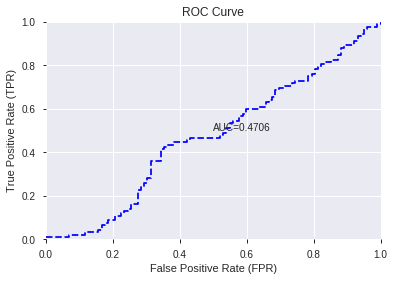

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


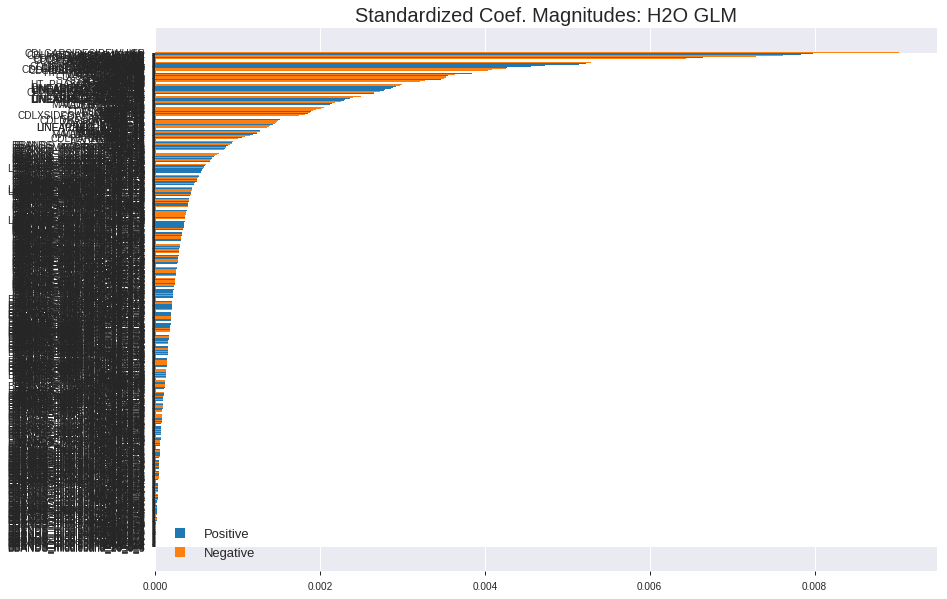

'log_likelihood'
--2019-09-06 02:30:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_022934_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_022934_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLGAPSIDESIDEWHITE',
 'is_month_start',
 'SIN',
 'CDLHIKKAKEMOD',
 'CDLMORNINGDOJISTAR',
 'days_in_month',
 'OBV',
 'CDLTASUKIGAP',
 'CDLMATCHINGLOW',
 'day',
 'CDLGRAVESTONEDOJI',
 'CDLDOJISTAR',
 'CDLSHOOTINGSTAR',
 'aroondown_12',
 'CDLSTALLEDPATTERN',
 'STOCHRSI_fastk',
 'AROONOSC_12',
 'CDLHANGINGMAN',
 'BETA_24',
 'CDLHIKKAKE',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'CORREL_24',
 'TAN',
 'CORREL_30',
 'ULTOSC',
 'CDLINVERTEDHAMMER',
 'CDLHOMINGPIGEON',
 'BETA_30',
 'weekday_name',
 'CDLSTICKSANDWICH',
 'aroondown_14',
 'CDLRISEFALL3METHODS',
 'WILLR_8',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS',
 'ADOSC',
 'hour',
 'HT_PHASOR_inphase',
 'CDLHIGHWAVE',
 'CDLLONGLINE',
 'ATR_8',
 'MACDEXT_signal',
 'CCI_12',
 'MOM_20',
 'BOP',
 'CDLSPINNINGTOP',
 'CDLHAMMER',
 'aroonup_12',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'is_month_end',
 'ROCR100_20',
 'CDLHARAMI',
 'CORREL_20',
 'STOCHRSI_fastd',
 'BETA_8',
 'CDL3INSIDE',
 'CORREL_8',
 'quarter',
 'BETA_20',
 'NATR_8',
 'STOCHF_

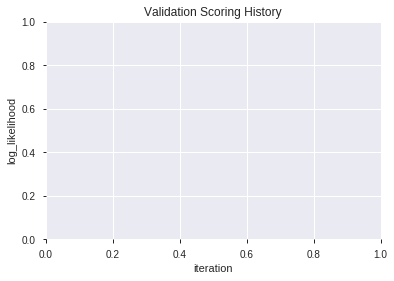

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_023017_model_3  0.525362  0.750170              0.500000  0.524297  0.274887
1  XGBoost_grid_1_AutoML_20190906_023017_model_2  0.502238  0.699914              0.463981  0.503224  0.253235
2               XGBoost_3_AutoML_20190906_023017  0.494672  0.746654              0.500000  0.522640  0.273153
3  XGBoost_grid_1_AutoML_20190906_023017_model_1  0.491155  0.784704              0.495098  0.536892  0.288253
4               XGBoost_1_AutoML_20190906_023017  0.485401  0.751372              0.500000  0.524201  0.274786
5  XGBoost_grid_1_AutoML_20190906_023017_model_4  0.482896  0.710028              0.495098  0.507892  0.257954
6               XGBoost_2_AutoML_20190906_023017  0.476130  0.717928              0.490729  0.511213  0.261338
7  XGBoost_grid_1_AutoML_20190906_023017_model_5  0.474318  0.779057              0.500000  0.534430  0.285615
8  XGBoost_grid_1_AutoML_20190906_023017_model_7  0.473892  0.777623              0.500000  0.533890  0.285038
9  XGBoost_grid_1_AutoML_20190906_023017_model_6  0.466539  0.749083              0.500000  0.523756  0.274320

variable  relative_importance  scaled_importance  percentage
0                    BETA_20           126.411957           1.000000    0.026467
1                        BOP           100.077377           0.791677    0.020953
2                   CORREL_8            98.006355           0.775293    0.020520
3                     Volume            95.944679           0.758984    0.020088
4                  CORREL_12            95.900635           0.758636    0.020079
..                       ...                  ...                ...         ...
265  BBANDS_lowerband_12_7_5             1.090649           0.008628    0.000228
266   LINEARREG_INTERCEPT_20             1.032715           0.008169    0.000216
267              MIDPOINT_24             0.927063           0.007334    0.000194
268       LINEARREG_SLOPE_20             0.922504           0.007298    0.000193
269                   KAMA_8             0.262581           0.002077    0.000055

[270 rows x 4 columns]

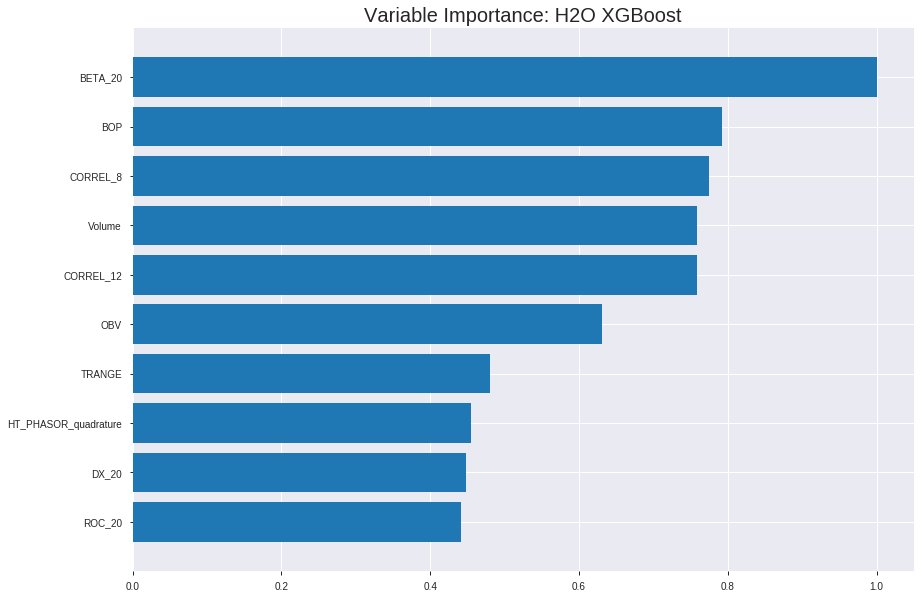

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_023017_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1757481356664299
RMSE: 0.41922325277402006
LogLoss: 0.5399483734316215
Mean Per-Class Error: 0.1294723066587008
AUC: 0.9443310114213559
pr_auc: 0.947617764884529
Gini: 0.8886620228427118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4971732795238495: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      561  110  0.1639   (110.0/671.0)
1      66   615  0.0969   (66.0/681.0)
Total  627  725  0.1302   (176.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497173     0.874822  205
max f2                       0.465622     0.911517  233
max f0point5                 0.546083     0.888496  159
max accuracy                 0.508501     0.870562  195
max precision                0.778042     1         0
max recall                   0.339298     1         338
max specificity              0.778042     1         0
max absolute_mcc             0.501223     0.741803  201
max min_per_class_accuracy   0.510205     0.867362  194
max mean_per_class_accuracy  0.508501     0.870528  195

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.43 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010355                    0.737977           1.98532    1.98532            1                0.756241  1                           0.756241            0.020558        0.020558                   98.5316   98.5316
    2        0.0207101                   0.718985           1.98532    1.98532            1                0.725539  1                           0.74089             0.020558        0.041116                   98.5316   98.5316
    3        0.0303254                   0.702095           1.98532    1.98532            1                0.708612  1                           0.730656            0.0190896       0.0602056                  98.5316   98.5316
    4        0.0406805                   0.69302            1.98532    1.98532            1                0.697669  1                           0.722259            0.020558        0.0807636                  98.5316   98.5316
    5        0.0502959                   0.686031           1.98532    1.98532            1                0.689546  1                           0.716005            0.0190896       0.0998532                  98.5316   98.5316
    6        0.100592                    0.656991           1.98532    1.98532            1                0.670363  1                           0.693184            0.0998532       0.199706                   98.5316   98.5316
    7        0.150148                    0.630778           1.95568    1.97554            0.985075         0.643575  0.995074                    0.676811            0.0969163       0.296623                   95.5684   97.5536
    8        0.200444                    0.613167           1.98532    1.97799            1                0.622744  0.99631                     0.663244            0.0998532       0.396476                   98.5316   97.799
    9        0.300296                    0.579226           1.88237    1.9462             0.948148         0.595721  0.980296                    0.640792            0.187959        0.584435                   88.2373   94.6196
    10       0.400148                    0.544718           1.55884    1.84954            0.785185         0.562228  0.931608                    0.621187            0.155653        0.740088                   55.884    84.9536
    11       0.5                         0.511143           1.25001    1.72981            0.62963          0.528305  0.871302                    0.602638            0.124816        0.864905                   25.0014   72.9809
    12       0.599852                    0.47066            0.750008   1.56671            0.377778         0.491257  0.789149                    0.584097            0.0748899       0.939794                   -24.9992  56.671
    13       0.699704                    0.436079           0.397063   1.39979            0.2              0.453036  0.705074                    0.565394            0.0396476       0.979442                   -60.2937  39.9794
    14       0.799556                    0.392022           0.132354   1.24151            0.0666667        0.413061  0.625347                    0.54637             0.0132159       0.992658                   -86.7646  24.1511
    15       0.899408                    0.346069           0.0441181  1.10858            0.0222222        0.372361  0.558388                    0.527052            0.00440529      0.997063                   -95.5882  10.8577
    16       1                           0.187317           0.0291958  1                  0.0147059        0.300752  0.503698                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.289651132188353
RMSE: 0.5381924676064809
LogLoss: 0.7820948459489792
Mean Per-Class Error: 0.47784946236559134
AUC: 0.48599462365591395
pr_auc: 0.5022651419704304
Gini: -0.028010752688172103
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15301069617271423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    186  1        (186.0/186.0)
1      0    200  0        (0.0/200.0)
Total  0    386  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.153011     0.682594  385
max f2                       0.153011     0.84317   385
max f0point5                 0.153011     0.573394  385
max accuracy                 0.258989     0.525907  324
max precision                0.383265     0.552846  122
max recall                   0.153011     1         385
max specificity              0.567444     0.994624  0
max absolute_mcc             0.540009     0.130299  5
max min_per_class_accuracy   0.335294     0.465     191
max mean_per_class_accuracy  0.383265     0.522151  122

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 34.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.542069           0         0                  0                0.555651  0                           0.555651            0               0                          -100      -100
    2        0.0207254                   0.530172           0.965     0.4825             0.5              0.536726  0.25                        0.546189            0.01            0.01                       -3.5      -51.75
    3        0.0310881                   0.515648           1.4475    0.804167           0.75             0.522423  0.416667                    0.538267            0.015           0.025                      44.75     -19.5833
    4        0.0414508                   0.50799            1.4475    0.965              0.75             0.511942  0.5                         0.531686            0.015           0.04                       44.75     -3.5
    5        0.0518135                   0.503635           0.4825    0.8685             0.25             0.504469  0.45                        0.526242            0.005           0.045                      -51.75    -13.15
    6        0.101036                    0.479179           1.01579   0.940256           0.526316         0.49262   0.487179                    0.509862            0.05            0.095                      1.57895   -5.97436
    7        0.150259                    0.447999           1.11737   0.998276           0.578947         0.464104  0.517241                    0.494873            0.055           0.15                       11.7368   -0.172414
    8        0.202073                    0.420475           0.965     0.989744           0.5              0.434766  0.512821                    0.479461            0.05            0.2                        -3.5      -1.02564
    9        0.300518                    0.387591           1.11737   1.03155            0.578947         0.401341  0.534483                    0.45387             0.11            0.31                       11.7368   3.15517
    10       0.401554                    0.363323           0.742308  0.958774           0.384615         0.375237  0.496774                    0.434085            0.075           0.385                      -25.7692  -4.12258
    11       0.5                         0.335176           0.812632  0.93               0.421053         0.347507  0.481865                    0.417038            0.08            0.465                      -18.7368  -7
    12       0.601036                    0.311575           1.28667   0.989957           0.666667         0.322131  0.512931                    0.401084            0.13            0.595                      28.6667   -1.00431
    13       0.699482                    0.288838           0.914211  0.979296           0.473684         0.299341  0.507407                    0.386765            0.09            0.685                      -8.57895  -2.07037
    14       0.800518                    0.26832            1.13821   0.999353           0.589744         0.277827  0.517799                    0.373015            0.115           0.8                        13.8205   -0.0647249
    15       0.898964                    0.245139           1.06658   1.00671            0.552632         0.257579  0.521614                    0.360374            0.105           0.905                      6.65789   0.67147
    16       1                           0.153011           0.940256  1                  0.487179         0.216464  0.518135                    0.345834           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:30:33  4.808 sec   0                  0.5              0.693147            0.5             0                  1                0.496302                         0.5                0.693147              0.5               0                    1                  0.481865
    2019-09-06 02:30:33  5.421 sec   5                  0.489618         0.672544            0.741678        0.733478           1.7017           0.352811                         0.502115           0.69741               0.502567          0.505148             0                  0.481865
    2019-09-06 02:30:34  5.649 sec   10                 0.481975         0.657565            0.799958        0.800652           1.98532          0.310651                         0.505342           0.70399               0.466694          0.49268              0.4825             0.481865
    2019-09-06 02:30:34  5.888 sec   15                 0.473236         0.640571            0.830005        0.838099           1.98532          0.272929                         0.511338           0.716639              0.482903          0.495894             0.4825             0.481865
    2019-09-06 02:30:34  6.141 sec   20                 0.462975         0.621005            0.874655        0.873511           1.98532          0.206361                         0.513007           0.720551              0.511653          0.521621             1.4475             0.481865
    2019-09-06 02:30:34  6.411 sec   25                 0.455554         0.606903            0.891956        0.895836           1.98532          0.201923                         0.518186           0.732089              0.50543           0.520159             0.965              0.481865
    2019-09-06 02:30:35  6.671 sec   30                 0.448048         0.592864            0.910919        0.911858           1.98532          0.169379                         0.520873           0.738322              0.50504           0.523066             0.965              0.481865
    2019-09-06 02:30:35  6.950 sec   35                 0.438344         0.57496             0.92838         0.93049            1.98532          0.14645                          0.52158            0.740447              0.506747          0.517477             0.4825             0.481865
    2019-09-06 02:30:35  7.232 sec   40                 0.431041         0.561483            0.9369          0.941916           1.98532          0.143491                         0.527323           0.754017              0.492876          0.503099             0                  0.481865
    2019-09-06 02:30:36  7.500 sec   45                 0.424857         0.550087            0.937677        0.940145           1.98532          0.135355                         0.531934           0.765758              0.492634          0.502087             0                  0.481865
    2019-09-06 02:30:36  7.777 sec   50                 0.419223         0.539948            0.944331        0.947618           1.98532          0.130178                         0.538192           0.782095              0.485995          0.502265             0                  0.481865

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BETA_20                  126.41195678710938     1.0                    0.026466996291876613
BOP                      100.07737731933594     0.7916765143338177     0.020953299369238954
CORREL_8                 98.00635528564453      0.775293396104114      0.02051968743980401
Volume                   95.9446792602539       0.758984210819824      0.020088032293361178
CORREL_12                95.900634765625        0.7586357904982948     0.02007881065400325
---                      ---                    ---                    ---
BBANDS_lowerband_12_7_5  1.0906486511230469     0.008627733316080301   0.00022835018568399763
LINEARREG_INTERCEPT_20   1.03271484375          0.008169439584652558   0.00021622052719370927
MIDPOINT_24              0.92706298828125       0.007333665357641118   0.00019410009382655143
LINEARREG_SLOPE_20       0.9225044250488281     0.007297604186306677   0.00019314566293856207
KAMA_8                   0.26258087158203125    0.0020771838222886163  5.49768165220589e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5670103092783505)

('F1', 0.6433566433566433)

('auc', 0.5253623188405797)

('logloss', 0.7501697233598721)

('mean_per_class_error', 0.4522591645353794)

('rmse', 0.5242969497511155)

('mse', 0.2748872915183237)

xgboost prediction progress: |████████████████████████████████████████████| 100%


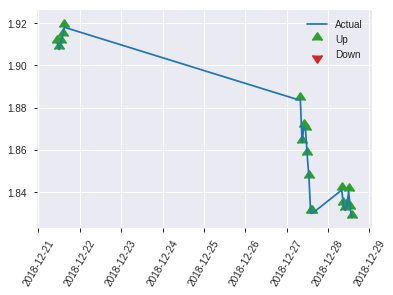


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2748872915183237
RMSE: 0.5242969497511155
LogLoss: 0.7501697233598721
Mean Per-Class Error: 0.4522591645353794
AUC: 0.5253623188405797
pr_auc: 0.5069222357248074
Gini: 0.050724637681159424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18922042846679688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18922      0.643357  193
max f2                       0.18922      0.818505  193
max f0point5                 0.231966     0.535714  179
max accuracy                 0.402165     0.56701   23
max precision                0.463018     0.8       4
max recall                   0.18922      1         193
max specificity              0.53683      0.990196  0
max absolute_mcc             0.402165     0.144805  23
max min_per_class_accuracy   0.304282     0.509804  96
max mean_per_class_accuracy  0.402165     0.547741  23

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 31.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103093                   0.512138           1.05435   1.05435            0.5              0.526064  0.5                         0.526064            0.0108696       0.0108696                  5.43478   5.43478
    2        0.0206186                   0.463888           2.1087    1.58152            1                0.490568  0.75                        0.508316            0.0217391       0.0326087                  110.87    58.1522
    3        0.0309278                   0.460541           1.05435   1.4058             0.5              0.462426  0.666667                    0.493019            0.0108696       0.0434783                  5.43478   40.5797
    4        0.0412371                   0.455982           1.05435   1.31793            0.5              0.458732  0.625                       0.484448            0.0108696       0.0543478                  5.43478   31.7935
    5        0.0515464                   0.444908           1.05435   1.26522            0.5              0.450213  0.6                         0.477601            0.0108696       0.0652174                  5.43478   26.5217
    6        0.103093                    0.416744           1.26522   1.26522            0.6              0.432962  0.6                         0.455281            0.0652174       0.130435                   26.5217   26.5217
    7        0.149485                    0.385015           1.1715    1.23613            0.555556         0.399546  0.586207                    0.437984            0.0543478       0.184783                   17.1498   23.6132
    8        0.201031                    0.374003           0.843478  1.13545            0.4              0.380978  0.538462                    0.423367            0.0434783       0.228261                   -15.6522  13.5452
    9        0.298969                    0.351875           0.776888  1.01799            0.368421         0.364739  0.482759                    0.404161            0.076087        0.304348                   -22.3112  1.7991
    10       0.402062                    0.32061            0.843478  0.973244           0.4              0.334146  0.461538                    0.386209            0.0869565       0.391304                   -15.6522  -2.67559
    11       0.5                         0.30392            1.22082   1.02174            0.578947         0.311537  0.484536                    0.371582            0.119565        0.51087                    22.0824   2.17391
    12       0.597938                    0.292945           0.887872  0.999813           0.421053         0.299186  0.474138                    0.359724            0.0869565       0.597826                   -11.2128  -0.0187406
    13       0.701031                    0.278567           1.26522   1.03884            0.6              0.285449  0.492647                    0.348801            0.130435        0.728261                   26.5217   3.88427
    14       0.798969                    0.25815            0.887872  1.02034            0.421053         0.269826  0.483871                    0.339121            0.0869565       0.815217                   -11.2128  2.03366
    15       0.896907                    0.238296           0.887872  1.00587            0.421053         0.247318  0.477011                    0.329096            0.0869565       0.902174                   -11.2128  0.587206
    16       1                           0.18922            0.948913  1                  0.45             0.220332  0.474227                    0.317883     

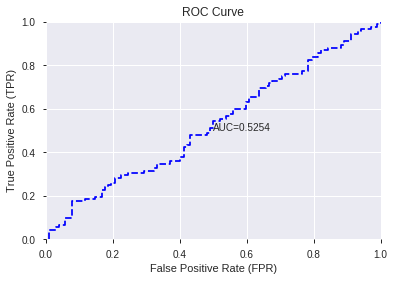

This function is available for GLM models only


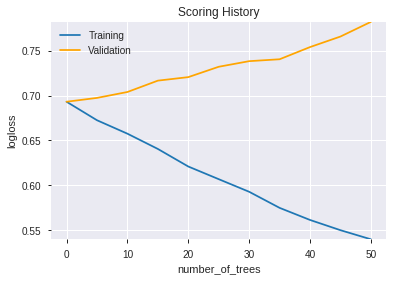

--2019-09-06 02:30:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_023017_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_023017_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BETA_20',
 'BOP',
 'CORREL_8',
 'Volume',
 'CORREL_12',
 'OBV',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'DX_20',
 'ROC_20',
 'MINUS_DM_8',
 'BETA_24',
 'BETA_14',
 'hour',
 'WILLR_8',
 'CORREL_14',
 'STOCH_slowk',
 'BETA_12',
 'DIV',
 'ROCP_20',
 'STOCHF_fastk',
 'STDDEV_12',
 'AD',
 'NATR_8',
 'BETA_8',
 'MFI_24',
 'MFI_8',
 'ROC_30',
 'CCI_8',
 'MACDEXT_hist',
 'MACDFIX_hist_24',
 'HT_PHASOR_inphase',
 'ATR_24',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_12',
 'MOM_8',
 'TAN',
 'SUB',
 'CCI_12',
 'MFI_14',
 'CORREL_20',
 'ADOSC',
 'AROONOSC_30',
 'AROONOSC_12',
 'STDDEV_14',
 'ROC_14',
 'PLUS_DI_14',
 'CCI_20',
 'ATR_8',
 'STDDEV_20',
 'STOCHF_fastd',
 'MFI_12',
 'aroondown_30',
 'aroonup_14',
 'aroondown_12',
 'ADXR_14',
 'MINUS_DM_12',
 'ATR_12',
 'BBANDS_upperband_14_7_2',
 'STOCH_slowd',
 'BBANDS_upperband_20_0_5',
 'DX_30',
 'TRIX_8',
 'ROC_24',
 'MACDEXT_signal',
 'PLUS_DM_12',
 'LINEARREG_ANGLE_8',
 'DX_8',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_12_7_2',
 'HT_DCPERIOD',
 'PLUS_DM_20',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

470

['MA_14_1',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_14_1_4',
 'BBANDS_middleband_14_1_4',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_upperband_14_2_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'MA_14_3',
 'MAVP_14_3',
 'BBANDS_upperband_14_3_2',
 'BBANDS_middleband_14_3_2',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_lowerb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_023200_model_6  0.515452  0.693698              0.495098  0.500272  0.250272
1  DeepLearning_grid_1_AutoML_20190906_023200_model_5  0.500000  0.695375              0.500000  0.501090  0.251091
2  DeepLearning_grid_1_AutoML_20190906_023200_model_8  0.500000  0.697589              0.500000  0.502213  0.252218
3  DeepLearning_grid_1_AutoML_20190906_023200_model_9  0.500000  0.692862              0.500000  0.499857  0.249857
4  DeepLearning_grid_1_AutoML_20190906_023200_model_7  0.476929  0.758739              0.500000  0.530589  0.281525
5               DeepLearning_1_AutoML_20190906_023200  0.475064  2.827978              0.500000  0.684800  0.468951
6  DeepLearning_grid_1_AutoML_20190906_023200_model_2  0.469309  1.135726              0.485827  0.602633  0.363167
7  DeepLearning_grid_1_AutoML_20190906_023200_model_4  0.465580  0.940331              0.472187  0.574380  0.329912
8  DeepLearning_grid_1_AutoML_20190906_023200_model_3  0.464727  1.706810              0.485827  0.661917  0.438134
9  DeepLearning_grid_1_AutoML_20190906_023200_model_1  0.427749  3.050456              0.485294  0.693999  0.481635

variable  relative_importance  scaled_importance  percentage
0        HT_PHASOR_quadrature             1.000000           1.000000    0.003714
1              STOCHRSI_fastk             0.987714           0.987714    0.003669
2                      TRANGE             0.917062           0.917062    0.003406
3                   CORREL_12             0.886628           0.886628    0.003293
4              STOCHRSI_fastd             0.870441           0.870441    0.003233
..                        ...                  ...                ...         ...
463  BBANDS_middleband_20_1_4             0.467863           0.467863    0.001738
464   BBANDS_lowerband_20_1_2             0.464914           0.464914    0.001727
465       CDLXSIDEGAP3METHODS             0.462565           0.462565    0.001718
466               CDLMARUBOZU             0.461003           0.461003    0.001712
467            CDLHARAMICROSS             0.456329           0.456329    0.001695

[468 rows x 4 columns]

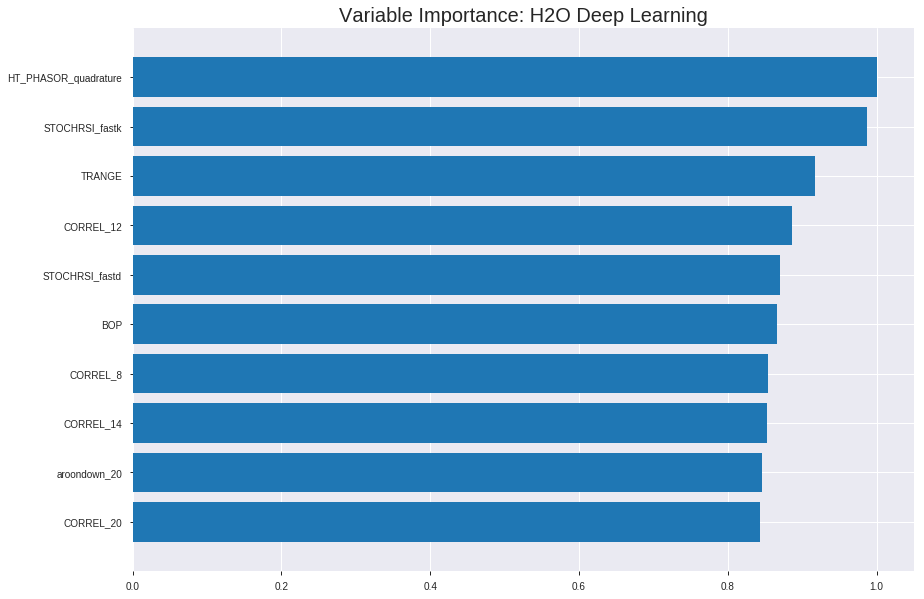

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_023200_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21898052958067982
RMSE: 0.46795355493967544
LogLoss: 0.6195684742953609
Mean Per-Class Error: 0.37952209317848085
AUC: 0.6942976380399649
pr_auc: 0.7210695712682073
Gini: 0.38859527607992983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44270626753423087: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      142  529   0.7884   (529.0/671.0)
1      25   656   0.0367   (25.0/681.0)
Total  167  1185  0.4098   (554.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442706     0.703108  278
max f2                       0.285432     0.848492  348
max f0point5                 0.460601     0.622477  243
max accuracy                 0.467995     0.619822  232
max precision                0.99886      1         0
max recall                   0.285432     1         348
max specificity              0.99886      1         0
max absolute_mcc             0.528565     0.297548  136
max min_per_class_accuracy   0.460601     0.58884   243
max mean_per_class_accuracy  0.507687     0.620478  168

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.969587           1.98532   1.98532            1                0.985657  1                           0.985657            0.020558        0.020558                   98.5316     98.5316
    2        0.0207101                   0.936112           1.98532   1.98532            1                0.955912  1                           0.970784            0.020558        0.041116                   98.5316     98.5316
    3        0.0303254                   0.884742           1.8326    1.93689            0.923077         0.912416  0.97561                     0.952277            0.0176211       0.0587372                  83.2599     93.6893
    4        0.0406805                   0.835145           1.98532   1.94922            1                0.863921  0.981818                    0.929787            0.020558        0.0792952                  98.5316     94.9219
    5        0.0502959                   0.772318           1.98532   1.95612            1                0.807622  0.985294                    0.906432            0.0190896       0.0983847                  98.5316     95.612
    6        0.100592                    0.559059           1.72255   1.83934            0.867647         0.646841  0.926471                    0.776636            0.0866373       0.185022                   72.2553     83.9337
    7        0.150148                    0.523526           1.33342   1.67236            0.671642         0.534894  0.842365                    0.696849            0.0660793       0.251101                   33.3421     67.236
    8        0.200444                    0.510323           1.28462   1.57507            0.647059         0.516434  0.793358                    0.651579            0.0646109       0.315712                   28.4616     57.5066
    9        0.300296                    0.489376           1.00001   1.38385            0.503704         0.498928  0.697044                    0.600821            0.0998532       0.415565                   0.00108773  38.3853
    10       0.400148                    0.471811           0.970599  1.28073            0.488889         0.480564  0.645102                    0.570812            0.0969163       0.512482                   -2.94012    28.073
    11       0.75                        0.460231           0.998954  1.14929            0.503171         0.461359  0.578895                    0.519756            0.349486        0.861968                   -0.104622   14.929
    12       0.799556                    0.454842           0.681526  1.1203             0.343284         0.457947  0.564292                    0.515925            0.0337739       0.895742                   -31.8474    12.0298
    13       0.899408                    0.421314           0.750008  1.07919            0.377778         0.445823  0.543586                    0.508142            0.0748899       0.970631                   -24.9992    7.91889
    14       1                           0.00078296         0.291958  1                  0.147059         0.250122  0.503698                    0.482187            0.0293686       1                          -70.8042    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2484535645906412
RMSE: 0.4984511657029615
LogLoss: 0.6900511608608771
Mean Per-Class Error: 0.4381989247311828
AUC: 0.560524193548387
pr_auc: 0.554920898677914
Gini: 0.12104838709677401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46023124601288073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    185  0.9946   (185.0/186.0)
1      0    200  0        (0.0/200.0)
Total  1    385  0.4793   (185.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460231     0.683761  325
max f2                       0.460231     0.843882  325
max f0point5                 0.464768     0.590778  296
max accuracy                 0.475478     0.567358  252
max precision                0.555913     0.75      3
max recall                   0.460231     1         325
max specificity              0.561282     0.994624  0
max absolute_mcc             0.475478     0.129961  252
max min_per_class_accuracy   0.490304     0.543011  193
max mean_per_class_accuracy  0.475478     0.561801  252

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 49.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.555727           1.4475    1.4475             0.75             0.557965  0.75                        0.557965            0.015           0.015                      44.75     44.75
    2        0.0207254                   0.547597           0.4825    0.965              0.25             0.551379  0.5                         0.554672            0.005           0.02                       -51.75    -3.5
    3        0.0310881                   0.541961           0.965     0.965              0.5              0.545369  0.5                         0.551571            0.01            0.03                       -3.5      -3.5
    4        0.0414508                   0.538253           1.4475    1.08563            0.75             0.53918   0.5625                      0.548474            0.015           0.045                      44.75     8.5625
    5        0.0518135                   0.53754            0.965     1.0615             0.5              0.537985  0.55                        0.546376            0.01            0.055                      -3.5      6.15
    6        0.101036                    0.530875           0.914211  0.989744           0.473684         0.533497  0.512821                    0.540102            0.045           0.1                        -8.57895  -1.02564
    7        0.150259                    0.522681           1.42211   1.13138            0.736842         0.526643  0.586207                    0.535693            0.07            0.17                       42.2105   13.1379
    8        0.202073                    0.518139           1.158     1.13821            0.6              0.520222  0.589744                    0.531726            0.06            0.23                       15.8      13.8205
    9        0.300518                    0.506153           1.01579   1.0981             0.526316         0.512326  0.568966                    0.525371            0.1             0.33                       1.57895   9.81034
    10       0.401554                    0.498511           1.03923   1.08329            0.538462         0.502272  0.56129                     0.519559            0.105           0.435                      3.92308   8.32903
    11       0.5                         0.490674           1.06658   1.08               0.552632         0.494937  0.559585                    0.514711            0.105           0.54                       6.65789   8
    12       0.601036                    0.479989           1.03923   1.07315            0.538462         0.485938  0.556034                    0.509874            0.105           0.645                      3.92308   7.31466
    13       0.699482                    0.468027           0.914211  1.05078            0.473684         0.47457   0.544444                    0.504906            0.09            0.735                      -8.57895  5.07778
    14       0.800518                    0.463063           1.03923   1.04932            0.538462         0.465514  0.543689                    0.499934            0.105           0.84                       3.92308   4.93204
    15       0.997409                    0.460231           0.812632  1.0026             0.421053         0.460488  0.519481                    0.492147            0.16            1                          -18.7368  0.25974
    16       1                           0.455647           0         1                  0                0.455647  0.518135                    0.492052            0             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:38:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:38:46  3 min 50.045 sec  547 obs/sec       0.964497  1             1304       0.636347         2.32521             -0.619841      0.525748        0.528477           1.27627          0.496302                         0.719812           7.63418               -1.07525         0.565134          0.5676               0.965              0.468912
    2019-09-06 02:39:01  4 min  4.658 sec  749 obs/sec       8.67308   9             11726      0.506935         0.707672            -0.0279906     0.576316        0.585994           1.55989          0.495562                         0.546457           0.799957              -0.196033        0.562796          0.555841             0.965              0.479275
    2019-09-06 02:39:15  4 min 18.505 sec  833 obs/sec       17.3291   18            23429      0.499058         0.690927            0.00370878     0.563766        0.582764           1.84351          0.447485                         0.507424           0.708299              -0.0312736       0.45254           0.127941             0.945954           0.481865
    2019-09-06 02:39:29  4 min 32.791 sec  855 obs/sec       25.9704   27            35112      0.493412         0.678758            0.0261251      0.588114        0.624919           1.98532          0.460799                         0.503956           0.701123              -0.0172259       0.469543          0.460688             1.2352             0.481865
    2019-09-06 02:39:44  4 min 47.498 sec  908 obs/sec       36.5348   38            49395      0.487565         0.665734            0.0490706      0.610882        0.649758           1.98532          0.448964                         0.5041             0.701423              -0.0178051       0.495766          0.711931             0.995156           0.481865
    2019-09-06 02:39:58  5 min  2.221 sec  939 obs/sec       47.0902   49            63666      0.483914         0.656968            0.0632579      0.633962        0.674087           1.98532          0.454882                         0.503454           0.700101              -0.0151984       0.505             0.756477             1                  0.481865
    2019-09-06 02:40:12  5 min 16.172 sec  970 obs/sec       57.6901   60            77997      0.474314         0.634995            0.100058       0.674636        0.707354           1.98532          0.420858                         0.505296           0.703863              -0.0226434       0.591008          0.629281             1.93               0.455959
    2019-09-06 02:40:27  5 min 30.683 sec  987 obs/sec       68.2655   71            92295      0.467954         0.619568            0.12403        0.694298        0.72107            1.98532          0.409763                         0.498451           0.690051              0.00487669       0.560524          0.554921             1.4475             0.479275

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_PHASOR_quadrature      1.0                    1.0                  0.0037144203596023023
STOCHRSI_fastk            0.9877139925956726     0.9877139925956726   0.003668784963561444
TRANGE                    0.9170620441436768     0.9170620441436768   0.0034063539277857783
CORREL_12                 0.8866277933120728     0.8866277933120728   0.003293308326867625
STOCHRSI_fastd            0.8704414963722229     0.8704414963722229   0.0032331856159676783
---                       ---                    ---                  ---
BBANDS_middleband_20_1_4  0.46786272525787354    0.46786272525787354  0.001737838832196864
BBANDS_lowerband_20_1_2   0.4649136960506439     0.4649136960506439   0.0017268848980684683
CDLXSIDEGAP3METHODS       0.46256548166275024    0.46256548166275024  0.001718162642737365
CDLMARUBOZU               0.46100306510925293    0.46100306510925293  0.0017123591708808749
CDLHARAMICROSS            0.45632949471473694    0.45632949471473694  0.0016949995658554502


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5412371134020618)

('F1', 0.6456140350877193)

('auc', 0.5154518329070759)

('logloss', 0.6936979561778269)

('mean_per_class_error', 0.46579283887468037)

('rmse', 0.5002722085012428)

('mse', 0.25027228259871087)

deeplearning prediction progress: |███████████████████████████████████████| 100%


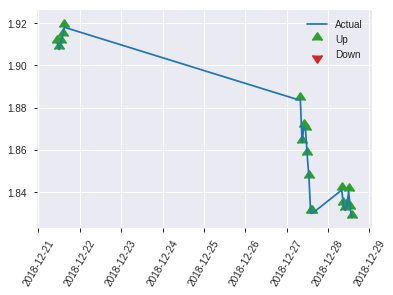


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25027228259871087
RMSE: 0.5002722085012428
LogLoss: 0.6936979561778269
Mean Per-Class Error: 0.46579283887468037
AUC: 0.5154518329070759
pr_auc: 0.46656903848101045
Gini: 0.030903665814151715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46023124601288073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    101  0.9902   (101.0/102.0)
1      0    92   0        (0.0/92.0)
Total  1    193  0.5206   (101.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460231     0.645614  144
max f2                       0.460231     0.819964  144
max f0point5                 0.460423     0.534639  142
max accuracy                 0.521362     0.541237  32
max precision                0.521362     0.545455  32
max recall                   0.460231     1         144
max specificity              0.566174     0.990196  0
max absolute_mcc             0.548053     0.169664  5
max min_per_class_accuracy   0.484826     0.51087   94
max mean_per_class_accuracy  0.472485     0.534207  108

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 48.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103093                   0.551433           0         0                  0                0.559551  0                           0.559551            0               0                          -100       -100
    2        0.0206186                   0.548797           0         0                  0                0.550787  0                           0.555169            0               0                          -100       -100
    3        0.0309278                   0.546636           0         0                  0                0.548306  0                           0.552881            0               0                          -100       -100
    4        0.0412371                   0.543599           2.1087    0.527174           1                0.545448  0.25                        0.551023            0.0217391       0.0217391                  110.87     -47.2826
    5        0.0515464                   0.542044           1.05435   0.632609           0.5              0.542906  0.3                         0.5494              0.0108696       0.0326087                  5.43478    -36.7391
    6        0.103093                    0.533849           1.26522   0.948913           0.6              0.537976  0.45                        0.543688            0.0652174       0.0978261                  26.5217    -5.1087
    7        0.149485                    0.522948           1.1715    1.01799            0.555556         0.529847  0.482759                    0.539392            0.0543478       0.152174                   17.1498    1.7991
    8        0.201031                    0.51783            1.26522   1.08138            0.6              0.519891  0.512821                    0.534392            0.0652174       0.217391                   26.5217    8.13824
    9        0.298969                    0.506773           0.887872  1.01799            0.421053         0.51305   0.482759                    0.527401            0.0869565       0.304348                   -11.2128   1.7991
    10       0.402062                    0.494179           0.948913  1.00028            0.45             0.500718  0.474359                    0.520559            0.0978261       0.402174                   -5.1087    0.0278707
    11       0.5                         0.481084           1.10984   1.02174            0.526316         0.488443  0.484536                    0.514268            0.108696        0.51087                    10.984     2.17391
    12       0.597938                    0.468869           0.998856  1.01799            0.473684         0.474991  0.482759                    0.507835            0.0978261       0.608696                   -0.114416  1.7991
    13       0.701031                    0.462412           1.15978   1.03884            0.55             0.465546  0.492647                    0.501616            0.119565        0.728261                   15.9783    3.88427
    14       0.994845                    0.460231           0.924867  1.00518            0.438596         0.460364  0.476684                    0.489433            0.271739        1                          -7.51335   0.518135
    15       1                           0.440628           0         1                  0                0.440628  0.474227                    0.489181            0               1                          -100       0

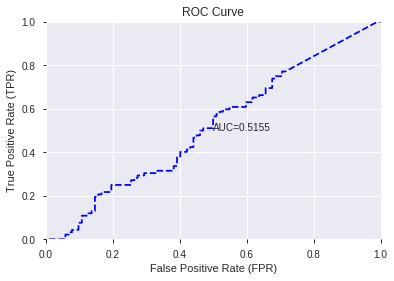

This function is available for GLM models only


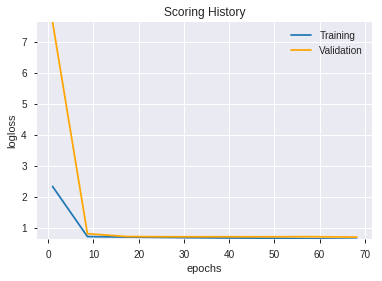

--2019-09-06 02:48:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.88.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.88.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_023200_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_023200_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'TRANGE',
 'CORREL_12',
 'STOCHRSI_fastd',
 'BOP',
 'CORREL_8',
 'CORREL_14',
 'aroondown_20',
 'CORREL_20',
 'DX_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'DX_30',
 'OBV',
 'DX_20',
 'STOCHF_fastk',
 'DX_8',
 'aroondown_8',
 'HT_PHASOR_inphase',
 'CDLHAMMER',
 'STDDEV_20',
 'MFI_12',
 'MACDFIX_signal_24',
 'CDLSPINNINGTOP',
 'STDDEV_12',
 'VAR_20',
 'DX_24',
 'ULTOSC',
 'CDLHIKKAKE',
 'ADOSC',
 'MFI_14',
 'MFI_24',
 'BETA_8',
 'ADXR_14',
 'BETA_20',
 'STDDEV_8',
 'WILLR_8',
 'STDDEV_14',
 'ADX_12',
 'MACDFIX_signal_20',
 'BETA_24',
 'AROONOSC_12',
 'aroondown_24',
 'ADX_20',
 'ADX_14',
 'BETA_14',
 'MFI_30',
 'VAR_14',
 'HT_DCPERIOD',
 'CCI_8',
 'MINUS_DI_30',
 'CDLHANGINGMAN',
 'aroonup_14',
 'aroondown_12',
 'AROONOSC_24',
 'VAR_8',
 'ADXR_12',
 'AROONOSC_8',
 'MACDFIX_signal_14',
 'BETA_12',
 'MACDFIX_signal_12',
 'aroonup_24',
 'MACDEXT_hist',
 'MFI_8',
 'STOCH_slowk',
 'VAR_12',
 'MINUS_DI_24',
 'AD',
 'aroondown_14',
 'aroonup_8',
 'MIN

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_024903_model_1  0.47176  0.69497                   0.5  0.50091  0.250911

variable  relative_importance  scaled_importance  percentage
0         CDLGAPSIDESIDEWHITE         9.010756e-03           1.000000    0.018302
1               CDLHIKKAKEMOD         7.960079e-03           0.883397    0.016168
2                         OBV         7.707465e-03           0.855363    0.015655
3                CDLTASUKIGAP         7.548582e-03           0.837730    0.015332
4           CDLGRAVESTONEDOJI         6.715880e-03           0.745318    0.013641
..                        ...                  ...                ...         ...
463                 MAVP_20_2         4.419490e-06           0.000490    0.000009
464                    RSI_20         4.349895e-06           0.000483    0.000009
465                   MA_20_2         3.248951e-06           0.000361    0.000007
466   BBANDS_upperband_14_3_2         9.178278e-07           0.000102    0.000002
467  BBANDS_middleband_20_7_3         8.962965e-07           0.000099    0.000002

[468 rows x 4 columns]

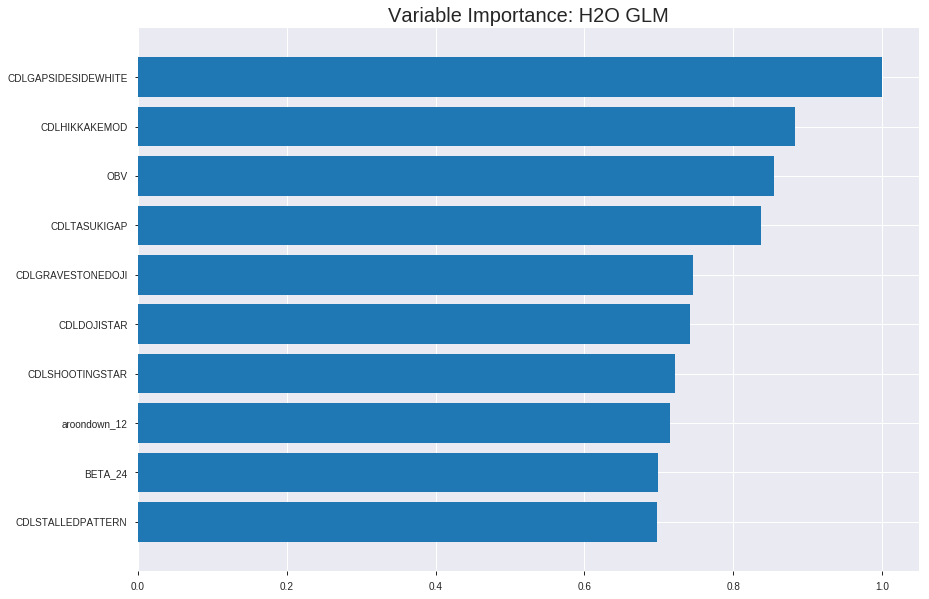

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_024903_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24760228864186373
RMSE: 0.4975965118867532
LogLoss: 0.6883456325477134
Null degrees of freedom: 1351
Residual degrees of freedom: 883
Null deviance: 1874.1960110626424
Residual deviance: 1861.2865904090172
AIC: 2799.286590409017
AUC: 0.5967160592711254
pr_auc: 0.5860888445743635
Gini: 0.19343211854225073
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4762734315163751: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   642   0.9568   (642.0/671.0)
1      6    675   0.0088   (6.0/681.0)
Total  35   1317  0.4793   (648.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476273     0.675676  371
max f2                       0.465252     0.836609  393
max f0point5                 0.493129     0.588774  283
max accuracy                 0.504112     0.570266  194
max precision                0.57021      1         0
max recall                   0.465252     1         393
max specificity              0.57021      1         0
max absolute_mcc             0.493129     0.16367   283
max min_per_class_accuracy   0.503801     0.56975   197
max mean_per_class_accuracy  0.504112     0.570325  194

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010355                    0.541254           1.55989   1.55989            0.785714         0.548517  0.785714                    0.548517            0.0161527       0.0161527                  55.9891     55.9891
    2        0.0207101                   0.533382           1.41808   1.48899            0.714286         0.535978  0.75                        0.542247            0.0146843       0.030837                   41.8083     48.8987
    3        0.0303254                   0.530485           1.22173   1.40425            0.615385         0.531921  0.707317                    0.538973            0.0117474       0.0425844                  22.1733     40.4248
    4        0.0406805                   0.528679           1.41808   1.40777            0.714286         0.52935   0.709091                    0.536524            0.0146843       0.0572687                  41.8083     40.7769
    5        0.0502959                   0.526778           1.22173   1.3722             0.615385         0.527696  0.691176                    0.534836            0.0117474       0.0690162                  22.1733     37.2204
    6        0.100592                    0.52112            1.19703   1.28462            0.602941         0.5238    0.647059                    0.529318            0.0602056       0.129222                   19.7029     28.4616
    7        0.150148                    0.517544           1.24453   1.27138            0.626866         0.519313  0.640394                    0.526016            0.061674        0.190896                   24.4526     27.1384
    8        0.200444                    0.515228           0.963462  1.19412            0.485294         0.516247  0.601476                    0.523565            0.0484581       0.239354                   -3.6538     19.412
    9        0.300296                    0.510638           1.08825   1.15892            0.548148         0.512861  0.583744                    0.520006            0.108664        0.348018                   8.82471     15.8916
    10       0.400148                    0.507151           1.07354   1.13761            0.540741         0.50875   0.573013                    0.517197            0.107195        0.455213                   7.35411     13.7612
    11       0.5                         0.503698           1.14707   1.1395             0.577778         0.505568  0.573964                    0.514875            0.114537        0.56975                    14.7071     13.9501
    12       0.599852                    0.500043           0.941187  1.10649            0.474074         0.501901  0.557337                    0.512715            0.0939794       0.66373                    -5.88133    10.6489
    13       0.699704                    0.496436           1.00001   1.09129            0.503704         0.498204  0.549683                    0.510644            0.0998532       0.763583                   0.00108773  9.1294
    14       0.799556                    0.492326           0.941187  1.07255            0.474074         0.494392  0.540241                    0.508615            0.0939794       0.857562                   -5.88133    7.2548
    15       0.899408                    0.486246           0.750008  1.03674            0.377778         0.489602  0.522204                    0.506504            0.0748899       0.932452                   -24.9992    3.67397
    16       1                           0.433037           0.671504  1                  0.338235         0.478613  0.503698      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2502246593071044
RMSE: 0.5002246088579654
LogLoss: 0.6935971601361206
Null degrees of freedom: 385
Residual degrees of freedom: -83
Null deviance: 534.9236366841775
Residual deviance: 535.457007625085
AIC: 1473.457007625085
AUC: 0.5077956989247312
pr_auc: 0.5238401427681336
Gini: 0.015591397849462396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4588964124339103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    182  0.9785   (182.0/186.0)
1      1    199  0.005    (1.0/200.0)
Total  5    381  0.4741   (183.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.458896     0.685026   380
max f2                       0.457271     0.844595   383
max f0point5                 0.458896     0.577146   380
max accuracy                 0.486941     0.531088   284
max precision                0.534197     1          0
max recall                   0.457271     1          383
max specificity              0.534197     1          0
max absolute_mcc             0.457271     0.0748355  383
max min_per_class_accuracy   0.49542      0.515      191
max mean_per_class_accuracy  0.486941     0.522473   284

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.528564           0.965     0.965              0.5              0.531508  0.5                         0.531508            0.01            0.01                       -3.5      -3.5
    2        0.0207254                   0.525579           1.4475    1.20625            0.75             0.527129  0.625                       0.529319            0.015           0.025                      44.75     20.625
    3        0.0310881                   0.524122           0.4825    0.965              0.25             0.524899  0.5                         0.527845            0.005           0.03                       -51.75    -3.5
    4        0.0414508                   0.523626           1.4475    1.08563            0.75             0.523829  0.5625                      0.526841            0.015           0.045                      44.75     8.5625
    5        0.0518135                   0.522881           0.4825    0.965              0.25             0.523227  0.5                         0.526118            0.005           0.05                       -51.75    -3.5
    6        0.101036                    0.515919           1.01579   0.989744           0.526316         0.518402  0.512821                    0.522359            0.05            0.1                        1.57895   -1.02564
    7        0.150259                    0.512539           1.21895   1.06483            0.631579         0.513756  0.551724                    0.519541            0.06            0.16                       21.8947   6.48276
    8        0.202073                    0.507909           0.8685    1.01449            0.45             0.510173  0.525641                    0.517139            0.045           0.205                      -13.15    1.44872
    9        0.300518                    0.503634           1.11737   1.04819            0.578947         0.505298  0.543103                    0.51326             0.11            0.315                      11.7368   4.81897
    10       0.401554                    0.49976            0.989744  1.03348            0.512821         0.501989  0.535484                    0.510424            0.1             0.415                      -1.02564  3.34839
    11       0.5                         0.495331           1.01579   1.03               0.526316         0.497225  0.533679                    0.507825            0.1             0.515                      1.57895   3
    12       0.601036                    0.491986           0.890769  1.00659            0.461538         0.493514  0.521552                    0.505419            0.09            0.605                      -10.9231  0.659483
    13       0.699482                    0.489005           1.01579   1.00789            0.526316         0.490554  0.522222                    0.503327            0.1             0.705                      1.57895   0.788889
    14       0.800518                    0.483352           0.940256  0.999353           0.487179         0.486138  0.517799                    0.501158            0.095           0.8                        -5.97436  -0.0647249
    15       0.898964                    0.475612           0.812632  0.978905           0.421053         0.47997   0.507205                    0.498838            0.08            0.88                       -18.7368  -2.10951
    16       1                           0.455614           1.18769   1                  0.615385         0.467335  0.518135                    0.495655            0.12   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:49:03  0.000 sec   2            2.7       469           1.37669           1.38719
    2019-09-06 02:49:04  0.350 sec   4            2         469           1.37399           1.38765
    2019-09-06 02:49:04  0.691 sec   6            1.4       469           1.37088           1.3887
    2019-09-06 02:49:04  1.035 sec   8            1.1       469           1.36729           1.39036
    2019-09-06 02:49:05  1.387 sec   10           0.77      469           1.36325           1.39271

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5309278350515464)

('F1', 0.6433566433566433)

('auc', 0.4717604433077579)

('logloss', 0.6949699964144441)

('mean_per_class_error', 0.46547314578005117)

('rmse', 0.5009098066615567)

('mse', 0.25091063440971817)

glm prediction progress: |████████████████████████████████████████████████| 100%


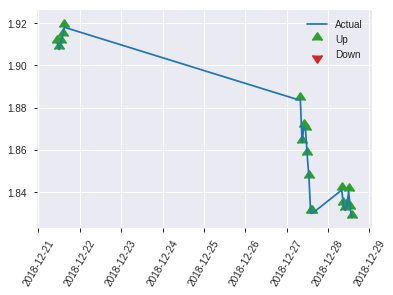


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25091063440971817
RMSE: 0.5009098066615567
LogLoss: 0.6949699964144441
Null degrees of freedom: 193
Residual degrees of freedom: -275
Null deviance: 269.09965128819607
Residual deviance: 269.6483586088043
AIC: 1207.6483586088043
AUC: 0.4717604433077579
pr_auc: 0.43271498173672057
Gini: -0.05647911338448419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4514989550738864: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451499     0.643357  193
max f2                       0.451499     0.818505  193
max f0point5                 0.478039     0.539474  166
max accuracy                 0.53419      0.530928  0
max precision                0.53419      1         0
max recall                   0.451499     1         193
max specificity              0.53419      1         0
max absolute_mcc             0.508798     0.199578  31
max min_per_class_accuracy   0.495111     0.478261  95
max mean_per_class_accuracy  0.483998     0.534527  148

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 49.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103093                   0.526158           1.05435   1.05435            0.5              0.532217  0.5                         0.532217            0.0108696       0.0108696                  5.43478    5.43478
    2        0.0206186                   0.525135           0         0.527174           0                0.525724  0.25                        0.52897             0               0.0108696                  -100       -47.2826
    3        0.0309278                   0.524815           1.05435   0.702899           0.5              0.524987  0.333333                    0.527643            0.0108696       0.0217391                  5.43478    -29.7101
    4        0.0412371                   0.523849           2.1087    1.05435            1                0.524361  0.5                         0.526822            0.0217391       0.0434783                  110.87     5.43478
    5        0.0515464                   0.522242           0         0.843478           0                0.523086  0.4                         0.526075            0               0.0434783                  -100       -15.6522
    6        0.103093                    0.514304           0.632609  0.738043           0.3              0.518069  0.35                        0.522072            0.0326087       0.076087                   -36.7391   -26.1957
    7        0.149485                    0.510054           0.2343    0.581709           0.111111         0.511752  0.275862                    0.518869            0.0108696       0.0869565                  -76.57     -41.8291
    8        0.201031                    0.506118           1.05435   0.702899           0.5              0.507994  0.333333                    0.516081            0.0543478       0.141304                   5.43478    -29.7101
    9        0.298969                    0.502175           1.33181   0.908921           0.631579         0.503707  0.431034                    0.512027            0.130435        0.271739                   33.1808    -9.10795
    10       0.402062                    0.498306           1.05435   0.94621            0.5              0.500555  0.448718                    0.509086            0.108696        0.380435                   5.43478    -5.37904
    11       0.5                         0.494205           0.998856  0.956522           0.473684         0.496256  0.453608                    0.506573            0.0978261       0.478261                   -0.114416  -4.34783
    12       0.597938                    0.490121           1.10984   0.981634           0.526316         0.491994  0.465517                    0.504185            0.108696        0.586957                   10.984     -1.83658
    13       0.701031                    0.486639           1.15978   1.00783            0.55             0.488366  0.477941                    0.501859            0.119565        0.706522                   15.9783    0.783248
    14       0.798969                    0.483003           1.10984   1.02034            0.526316         0.484769  0.483871                    0.499764            0.108696        0.815217                   10.984     2.03366
    15       0.896907                    0.475888           0.998856  1.01799            0.473684         0.478941  0.482759                    0.49749             0.0978261       0.913043                   -0.114416  1.7991
    16       1                           0.451499           0.843478  1                  0.4              0.467353  0.474227          

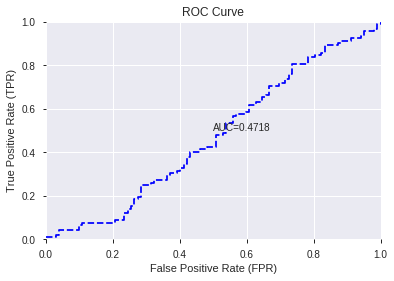

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


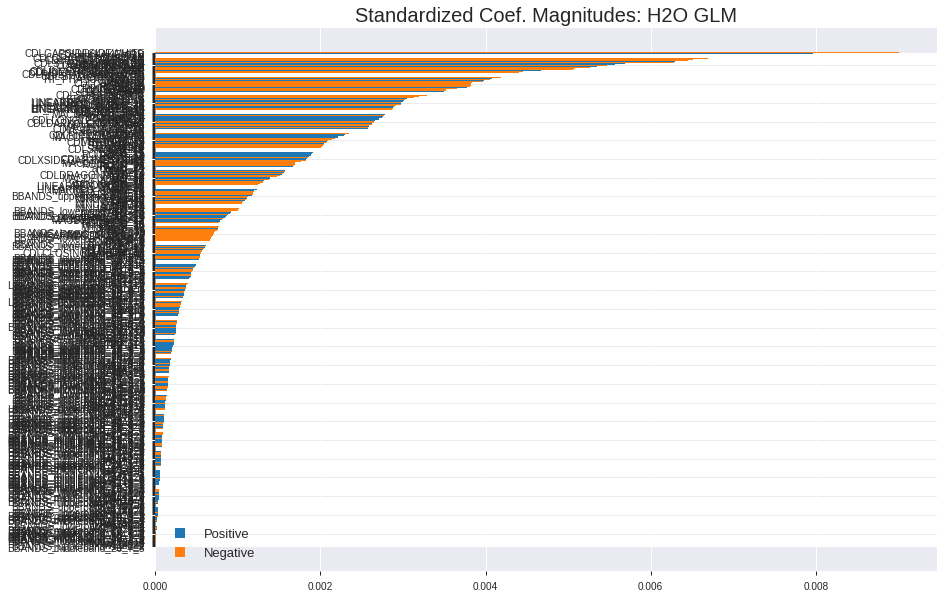

'log_likelihood'
--2019-09-06 02:49:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_024903_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_024903_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLGAPSIDESIDEWHITE',
 'CDLHIKKAKEMOD',
 'OBV',
 'CDLTASUKIGAP',
 'CDLGRAVESTONEDOJI',
 'CDLDOJISTAR',
 'CDLSHOOTINGSTAR',
 'aroondown_12',
 'BETA_24',
 'CDLSTALLEDPATTERN',
 'AROONOSC_12',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'CDLHIKKAKE',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLINVERTEDHAMMER',
 'CDLIDENTICAL3CROWS',
 'aroondown_14',
 'CDLRISEFALL3METHODS',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'MOM_20',
 'HT_PHASOR_inphase',
 'ADOSC',
 'CCI_12',
 'WILLR_8',
 'CDLLONGLINE',
 'ATR_8',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'BETA_20',
 'CDLHIGHWAVE',
 'BOP',
 'CDLHARAMI',
 'CDLHAMMER',
 'TRANGE',
 'CDLSPINNINGTOP',
 'CDL3INSIDE',
 'BETA_8',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'CORREL_8',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'MACDFIX_hist_24',
 'AROONOSC_14',
 'NATR_8',
 'aroonup_30',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'HT_PHASOR_quadrature',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDL3OUTSIDE',
 'MACDFIX_signal_24',
 'MACDEXT_hist',
 'aroondown_8',
 'STDDEV_8

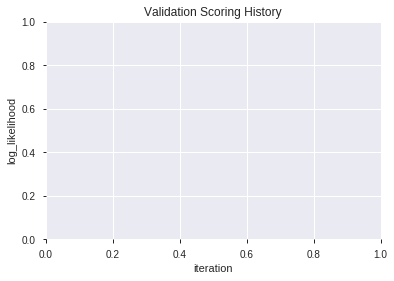

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_024930_model_6  0.535060  0.720038              0.500000  0.511442  0.261573
1  XGBoost_grid_1_AutoML_20190906_024930_model_2  0.492008  0.704163              0.500000  0.505203  0.255230
2  XGBoost_grid_1_AutoML_20190906_024930_model_1  0.491155  0.788820              0.500000  0.538494  0.289975
3  XGBoost_grid_1_AutoML_20190906_024930_model_5  0.486253  0.803575              0.500000  0.543681  0.295589
4  XGBoost_grid_1_AutoML_20190906_024930_model_4  0.483855  0.710881              0.495098  0.508412  0.258483
5               XGBoost_3_AutoML_20190906_024930  0.482417  0.760267              0.500000  0.527636  0.278400
6               XGBoost_1_AutoML_20190906_024930  0.478687  0.724591              0.500000  0.514098  0.264296
7  XGBoost_grid_1_AutoML_20190906_024930_model_3  0.473785  0.773563              0.500000  0.532840  0.283918
8               XGBoost_2_AutoML_20190906_024930  0.465686  0.726607              0.500000  0.514869  0.265090
9  XGBoost_grid_1_AutoML_20190906_024930_model_7  0.447570  0.762603              0.500000  0.529232  0.280087

variable  relative_importance  scaled_importance  percentage
0                        BOP           231.094543           1.000000    0.037323
1                        OBV           178.330246           0.771677    0.028801
2       HT_PHASOR_quadrature           133.929062           0.579542    0.021630
3                   CORREL_8           122.782845           0.531310    0.019830
4                    BETA_20           121.869637           0.527358    0.019683
..                       ...                  ...                ...         ...
212                   ROC_14             4.196186           0.018158    0.000678
213         MACDFIX_signal_8             4.194211           0.018149    0.000677
214  BBANDS_upperband_14_1_2             4.035545           0.017463    0.000652
215                   CMO_20             3.780459           0.016359    0.000611
216  BBANDS_lowerband_14_6_2             3.632062           0.015717    0.000587

[217 rows x 4 columns]

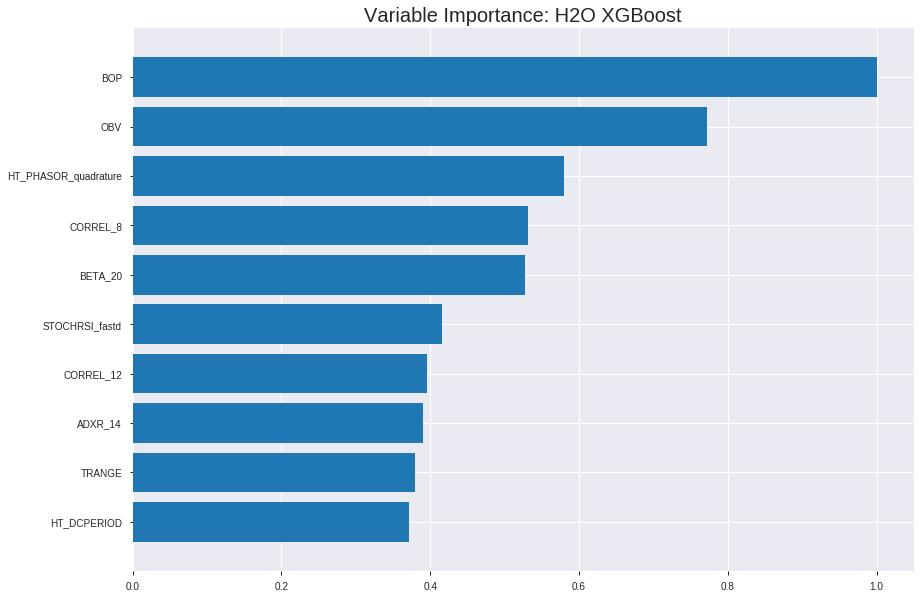

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_024930_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1724621451099909
RMSE: 0.4152856187131826
LogLoss: 0.5333401790492954
Mean Per-Class Error: 0.10882676698376847
AUC: 0.9591542638050906
pr_auc: 0.9601787689808805
Gini: 0.9183085276101812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4993857145309448: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      589  82   0.1222   (82.0/671.0)
1      65   616  0.0954   (65.0/681.0)
Total  654  698  0.1087   (147.0/1352.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499386     0.893401  198
max f2                       0.467865     0.927237  228
max f0point5                 0.526786     0.905102  174
max accuracy                 0.499386     0.891272  198
max precision                0.809632     1         0
max recall                   0.306188     1         366
max specificity              0.809632     1         0
max absolute_mcc             0.499386     0.78274   198
max min_per_class_accuracy   0.503513     0.888227  194
max mean_per_class_accuracy  0.499386     0.891173  198

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010355                    0.751716           1.98532    1.98532            1                0.778451  1                           0.778451            0.020558        0.020558                   98.5316   98.5316
    2        0.0207101                   0.72539            1.98532    1.98532            1                0.738992  1                           0.758722            0.020558        0.041116                   98.5316   98.5316
    3        0.0303254                   0.708197           1.98532    1.98532            1                0.715646  1                           0.745064            0.0190896       0.0602056                  98.5316   98.5316
    4        0.0406805                   0.699318           1.98532    1.98532            1                0.703159  1                           0.734397            0.020558        0.0807636                  98.5316   98.5316
    5        0.0502959                   0.690312           1.98532    1.98532            1                0.695307  1                           0.726924            0.0190896       0.0998532                  98.5316   98.5316
    6        0.100592                    0.659719           1.98532    1.98532            1                0.672904  1                           0.699914            0.0998532       0.199706                   98.5316   98.5316
    7        0.150148                    0.633598           1.98532    1.98532            1                0.646348  1                           0.682235            0.0983847       0.298091                   98.5316   98.5316
    8        0.200444                    0.614054           1.95612    1.97799            0.985294         0.623812  0.99631                     0.667575            0.0983847       0.396476                   95.612    97.799
    9        0.300296                    0.580009           1.92649    1.96087            0.97037          0.596474  0.987685                    0.643933            0.192364        0.58884                    92.6492   96.0866
    10       0.400148                    0.543225           1.61766    1.87522            0.814815         0.562044  0.944547                    0.623499            0.161527        0.750367                   61.7665   87.5224
    11       0.5                         0.504324           1.32354    1.76505            0.666667         0.522863  0.889053                    0.603401            0.132159        0.882526                   32.3544   76.5051
    12       0.599852                    0.466644           0.794126   1.60343            0.4              0.486434  0.807645                    0.583931            0.0792952       0.961821                   -20.5874  60.343
    13       0.699704                    0.430553           0.294121   1.41658            0.148148         0.449103  0.713531                    0.56469             0.0293686       0.991189                   -70.5879  41.6584
    14       0.799556                    0.389804           0.0588242  1.24702            0.0296296        0.409843  0.628122                    0.545352            0.00587372      0.997063                   -94.1176  24.7021
    15       0.899408                    0.348852           0          1.10858            0                0.372523  0.558388                    0.526165            0               0.997063                   -100      10.8577
    16       1                           0.218197           0.0291958  1                  0.0147059        0.309419  0.503698                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2726111809269828
RMSE: 0.5221218065997462
LogLoss: 0.7412683582714372
Mean Per-Class Error: 0.4541666666666666
AUC: 0.5087096774193549
pr_auc: 0.5169604761509952
Gini: 0.017419354838709822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23588259518146515: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   174  0.9355   (174.0/186.0)
1      2    198  0.01     (2.0/200.0)
Total  14   372  0.456    (176.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.235883     0.692308  371
max f2                       0.224313     0.846088  375
max f0point5                 0.281042     0.592949  339
max accuracy                 0.281042     0.559585  339
max precision                0.717636     1         0
max recall                   0.195712     1         384
max specificity              0.717636     1         0
max absolute_mcc             0.235883     0.1457    371
max min_per_class_accuracy   0.383158     0.483871  192
max mean_per_class_accuracy  0.281042     0.545833  339

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 38.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.613529           1.4475    1.4475             0.75             0.681636  0.75                        0.681636            0.015           0.015                      44.75     44.75
    2        0.0207254                   0.568862           0         0.72375            0                0.587846  0.375                       0.634741            0               0.015                      -100      -27.625
    3        0.0310881                   0.555829           1.4475    0.965              0.75             0.559827  0.5                         0.609769            0.015           0.03                       44.75     -3.5
    4        0.0414508                   0.54692            1.4475    1.08563            0.75             0.550931  0.5625                      0.59506             0.015           0.045                      44.75     8.5625
    5        0.0518135                   0.541826           0.965     1.0615             0.5              0.543961  0.55                        0.58484             0.01            0.055                      -3.5      6.15
    6        0.101036                    0.50982            0.812632  0.940256           0.421053         0.520959  0.487179                    0.553718            0.04            0.095                      -18.7368  -5.97436
    7        0.150259                    0.480401           1.21895   1.03155            0.631579         0.496121  0.534483                    0.53485             0.06            0.155                      21.8947   3.15517
    8        0.202073                    0.459283           0.8685    0.989744           0.45             0.469594  0.512821                    0.518118            0.045           0.2                        -13.15    -1.02564
    9        0.300518                    0.426472           1.06658   1.01491            0.552632         0.44047   0.525862                    0.492681            0.105           0.305                      6.65789   1.49138
    10       0.401554                    0.405259           0.890769  0.983677           0.461538         0.414889  0.509677                    0.473108            0.09            0.395                      -10.9231  -1.63226
    11       0.5                         0.382592           0.914211  0.97               0.473684         0.394003  0.502591                    0.457533            0.09            0.485                      -8.57895  -3
    12       0.601036                    0.357232           1.03923   0.981638           0.538462         0.369926  0.508621                    0.442806            0.105           0.59                       3.92308   -1.83621
    13       0.699482                    0.333187           1.26974   1.02219            0.657895         0.345423  0.52963                     0.4291              0.125           0.715                      26.9737   2.21852
    14       0.800518                    0.307955           1.18769   1.04307            0.615385         0.32172   0.540453                    0.415547            0.12            0.835                      18.7692   4.30744
    15       0.898964                    0.269291           1.01579   1.04009            0.526316         0.290662  0.538905                    0.401871            0.1             0.935                      1.57895   4.00865
    16       1                           0.185219           0.643333  1                  0.333333         0.237572  0.518135                    0.385271            0.065  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:49:47  9.586 sec   0                  0.5              0.693147            0.5             0                  1                0.496302                         0.5                0.693147              0.5               0                    1                  0.481865
    2019-09-06 02:49:47  9.783 sec   5                  0.489812         0.672942            0.785362        0.796481           1.98532          0.297337                         0.502152           0.697476              0.517177          0.524627             1.28667            0.474093
    2019-09-06 02:49:47  9.870 sec   10                 0.480115         0.653989            0.840051        0.843789           1.98532          0.258876                         0.503377           0.699946              0.508884          0.511339             0.965              0.476684
    2019-09-06 02:49:47  9.945 sec   15                 0.469267         0.633092            0.879584        0.884408           1.98532          0.200444                         0.504696           0.702683              0.517755          0.517962             0.4825             0.455959
    2019-09-06 02:49:47  10.021 sec  20                 0.460873         0.61712             0.900246        0.904622           1.98532          0.184172                         0.509088           0.711841              0.508629          0.512934             1.4475             0.453368
    2019-09-06 02:49:48  10.119 sec  25                 0.451277         0.599096            0.916561        0.921031           1.98532          0.164201                         0.50959            0.712995              0.513911          0.518573             1.4475             0.455959
    2019-09-06 02:49:48  10.197 sec  30                 0.443039         0.583823            0.92958         0.930261           1.98532          0.153846                         0.511298           0.716684              0.507151          0.51875              1.4475             0.458549
    2019-09-06 02:49:48  10.275 sec  35                 0.43618          0.571177            0.938188        0.93702            1.98532          0.140533                         0.510686           0.715246              0.517419          0.521349             1.4475             0.46114
    2019-09-06 02:49:48  10.356 sec  40                 0.428639         0.557423            0.946193        0.948146           1.98532          0.133136                         0.514032           0.72264               0.51414           0.51833              1.4475             0.448187
    2019-09-06 02:49:48  10.435 sec  45                 0.422486         0.546189            0.950535        0.951853           1.98532          0.130917                         0.519188           0.734233              0.504597          0.513492             1.4475             0.440415
    2019-09-06 02:49:48  10.515 sec  50                 0.415286         0.53334             0.959154        0.960179           1.98532          0.108728                         0.522122           0.741268              0.50871           0.51696              1.4475             0.455959

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      231.09454345703125     1.0                   0.03732317285387359
OBV                      178.3302459716797      0.7716765757597287    0.028801418224365632
HT_PHASOR_quadrature     133.92906188964844     0.5795422941890043    0.02163035722214667
CORREL_8                 122.78284454345703     0.5313100115074191    0.01983017539848497
BETA_20                  121.86963653564453     0.5273583474215802    0.01968268675674876
---                      ---                    ---                   ---
ROC_14                   4.196186065673828      0.01815787600564463   0.0006777095448178783
MACDFIX_signal_8         4.194210529327393      0.018149327399014276  0.0006773904836949538
BBANDS_upperband_14_1_2  4.035545349121094      0.0174627461503497    0.0006517650930728175
CMO_20                   3.780459403991699      0.016358929758523797  0.0006105671630817602
BBANDS_lowerband_14_6_2  3.6320621967315674     0.015716780424142287  0.0005866001124766393


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5721649484536082)

('F1', 0.6433566433566433)

('auc', 0.5350596760443308)

('logloss', 0.7200376618402157)

('mean_per_class_error', 0.43808610400682013)

('rmse', 0.511442148091444)

('mse', 0.2615730708443905)

xgboost prediction progress: |████████████████████████████████████████████| 100%


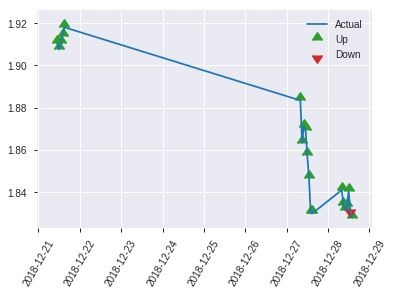


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2615730708443905
RMSE: 0.511442148091444
LogLoss: 0.7200376618402157
Mean Per-Class Error: 0.43808610400682013
AUC: 0.5350596760443308
pr_auc: 0.4943673604304454
Gini: 0.0701193520886616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17627549171447754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    92   0        (0.0/92.0)
Total  0    194  0.5258   (102.0/194.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.176275     0.643357  193
max f2                       0.176275     0.818505  193
max f0point5                 0.353593     0.548561  115
max accuracy                 0.510831     0.572165  26
max precision                0.709211     1         0
max recall                   0.176275     1         193
max specificity              0.709211     1         0
max absolute_mcc             0.258648     0.166454  185
max min_per_class_accuracy   0.38495      0.5       94
max mean_per_class_accuracy  0.353593     0.561914  115

Gains/Lift Table: Avg response rate: 47.42 %, avg score: 39.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103093                   0.667253           1.05435   1.05435            0.5              0.70003   0.5                         0.70003             0.0108696       0.0108696                  5.43478    5.43478
    2        0.0206186                   0.646841           0         0.527174           0                0.656241  0.25                        0.678136            0               0.0108696                  -100       -47.2826
    3        0.0309278                   0.637918           0         0.351449           0                0.646402  0.166667                    0.667558            0               0.0108696                  -100       -64.8551
    4        0.0412371                   0.606873           2.1087    0.790761           1                0.630048  0.375                       0.65818             0.0217391       0.0326087                  110.87     -20.9239
    5        0.0515464                   0.592643           1.05435   0.843478           0.5              0.597917  0.4                         0.646128            0.0108696       0.0434783                  5.43478    -15.6522
    6        0.103093                    0.532241           1.47609   1.15978            0.7              0.558458  0.55                        0.602293            0.076087        0.119565                   47.6087    15.9783
    7        0.149485                    0.503768           1.6401    1.30885            0.777778         0.51493   0.62069                     0.57518             0.076087        0.195652                   64.0097    30.8846
    8        0.201031                    0.482069           0.632609  1.13545            0.3              0.494081  0.538462                    0.554385            0.0326087       0.228261                   -36.7391   13.5452
    9        0.298969                    0.447448           0.998856  1.0907             0.473684         0.464708  0.517241                    0.525008            0.0978261       0.326087                   -0.114416  9.07046
    10       0.402062                    0.408597           0.843478  1.02731            0.4              0.426364  0.487179                    0.499715            0.0869565       0.413043                   -15.6522   2.73133
    11       0.5                         0.381927           0.887872  1                  0.421053         0.39453   0.474227                    0.479112            0.0869565       0.5                        -11.2128   0
    12       0.597938                    0.353379           1.66476   1.10888            0.789474         0.363643  0.525862                    0.460199            0.163043        0.663043                   66.476     10.8883
    13       0.701031                    0.333711           0.738043  1.05435            0.35             0.341625  0.5                         0.442761            0.076087        0.73913                    -26.1957   5.43478
    14       0.798969                    0.316235           0.776888  1.02034            0.368421         0.324972  0.483871                    0.428323            0.076087        0.815217                   -22.3112   2.03366
    15       0.896907                    0.281878           0.776888  0.993753           0.368421         0.30178   0.471264                    0.414505            0.076087        0.891304                   -22.3112   -0.624688
    16       1                           0.176275           1.05435   1                  0.5              0.251372  0.474227                    

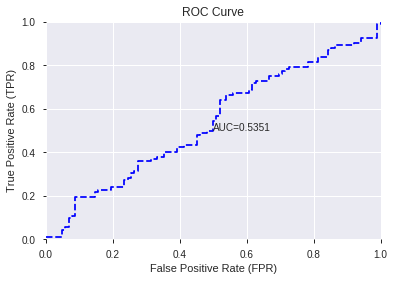

This function is available for GLM models only


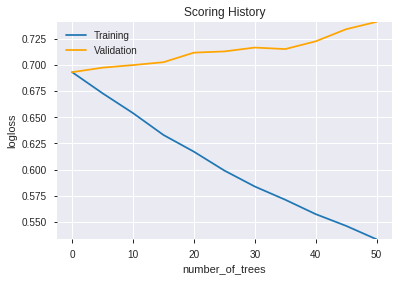

--2019-09-06 02:49:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_024930_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_024930_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_96e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'OBV',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'BETA_20',
 'STOCHRSI_fastd',
 'CORREL_12',
 'ADXR_14',
 'TRANGE',
 'HT_DCPERIOD',
 'MFI_14',
 'BETA_14',
 'DX_20',
 'LINEARREG_ANGLE_12',
 'BETA_24',
 'ADOSC',
 'TRIX_8',
 'ATR_8',
 'MOM_20',
 'CCI_8',
 'HT_PHASOR_inphase',
 'MINUS_DM_30',
 'BETA_8',
 'ULTOSC',
 'CORREL_20',
 'STOCH_slowd',
 'MACDEXT_hist',
 'CCI_12',
 'STOCHF_fastk',
 'ATR_20',
 'PPO',
 'MFI_12',
 'DX_14',
 'aroondown_12',
 'AROONOSC_30',
 'STOCH_slowk',
 'MFI_20',
 'LINEARREG_ANGLE_14',
 'CCI_30',
 'MFI_8',
 'MINUS_DM_8',
 'MOM_14',
 'DX_24',
 'STOCHRSI_fastk',
 'CMO_8',
 'ROC_8',
 'ADX_14',
 'AROONOSC_12',
 'STDDEV_20',
 'BETA_12',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_14',
 'ROC_24',
 'ATR_24',
 'WILLR_8',
 'NATR_20',
 'PLUS_DM_12',
 'CCI_14',
 'AROONOSC_20',
 'DX_30',
 'ADX_12',
 'ATR_30',
 'BBANDS_upperband_20_7_5',
 'MINUS_DI_12',
 'PLUS_DM_14',
 'AROONOSC_14',
 'MOM_24',
 'MOM_30',
 'STOCHF_fastd',
 'STDDEV_14',
 'MINUS_DI_30',
 'NATR_30',
 'BBANDS_upperband_14_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.577
GLM             0.572
XGBoost         0.572
dtype: float64

DeepLearning    GLM  XGBoost
All          0.474  0.541    0.567
DLF          0.552  0.572    0.552
Fwe          0.474  0.541    0.567
RFE          0.541  0.531    0.572
XGBF         0.577  0.572    0.552





F1


DeepLearning    0.646
GLM             0.652
XGBoost         0.646
dtype: float64

DeepLearning    GLM  XGBoost
All          0.643  0.643    0.643
DLF          0.646  0.652    0.646
Fwe          0.643  0.643    0.643
RFE          0.646  0.643    0.643
XGBF         0.646  0.652    0.646





auc


DeepLearning    0.543
GLM             0.550
XGBoost         0.535
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.471    0.525
DLF          0.526  0.550    0.523
Fwe          0.500  0.471    0.525
RFE          0.515  0.472    0.535
XGBF         0.543  0.550    0.523





logloss


DeepLearning    0.906
GLM             0.696
XGBoost         0.750
dtype: float64

DeepLearning    GLM  XGBoost
All          0.694  0.696    0.750
DLF          0.906  0.691    0.735
Fwe          0.693  0.696    0.750
RFE          0.694  0.695    0.720
XGBF         0.870  0.691    0.735





mean_per_class_error


DeepLearning    0.500
GLM             0.465
XGBoost         0.460
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.464    0.452
DLF          0.453  0.424    0.460
Fwe          0.500  0.464    0.452
RFE          0.466  0.465    0.438
XGBF         0.430  0.424    0.460





rmse


DeepLearning    0.562
GLM             0.501
XGBoost         0.524
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.501    0.524
DLF          0.562  0.499    0.518
Fwe          0.500  0.501    0.524
RFE          0.500  0.501    0.511
XGBF         0.552  0.499    0.518





mse


DeepLearning    0.316
GLM             0.251
XGBoost         0.275
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.251    0.275
DLF          0.316  0.249    0.268
Fwe          0.250  0.251    0.275
RFE          0.250  0.251    0.262
XGBF         0.304  0.249    0.268

{'F1':       DeepLearning    GLM  XGBoost
 All          0.643    NaN      NaN
 DLF          0.646    NaN      NaN
 DLF            NaN  0.652      NaN
 DLF            NaN    NaN    0.646
 All            NaN  0.643      NaN
 All            NaN    NaN    0.643
 XGBF         0.646    NaN      NaN
 XGBF           NaN  0.652      NaN
 XGBF           NaN    NaN    0.646
 Fwe          0.643    NaN      NaN
 Fwe            NaN  0.643      NaN
 Fwe            NaN    NaN    0.643
 RFE          0.646    NaN      NaN
 RFE            NaN  0.643      NaN
 RFE            NaN    NaN    0.643,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.474    NaN      NaN
 DLF          0.552    NaN      NaN
 DLF            NaN  0.572      NaN
 DLF            NaN    NaN    0.552
 All            NaN  0.541      NaN
 All            NaN    NaN    0.567
 XGBF         0.577    NaN      NaN
 XGBF           NaN  0.572      NaN
 XGBF           NaN    NaN    0.552
 Fwe          0.474    NaN      NaN
 Fwe     